# Requirements

In [1]:
#!python --version
#!pip install --upgrade pip
#!pip uninstall keras tensorflow
!pip install -r ../requirements.txt

# Imports

In [19]:
import torch
import os
from tqdm import tqdm

import numpy as np
import keras
from tensorflow import keras
from keras.datasets import cifar10
from __future__ import print_function
from keras.models import Sequential
from keras.models import save_model, load_model
from keras.layers import Dense, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

import keras.backend as K
K.clear_session()

# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score
# from model import Mamba, ModelArgs  # Import your custom Mamba implementation
# Assuming the model classes are defined in `model.py`
from model import ImageMamba, ModelArgs

In [14]:
# Load CIFAR-10 data
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()

# Reshape and preprocess the CIFAR-10 dataset for PyTorch models
X_train = X_train.transpose(0, 3, 1, 2)  # Shape: (batch_size, channels, height, width)
X_test = X_test.transpose(0, 3, 1, 2)

# Convert data to float and normalize pixel values in the range [0, 1]
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Convert the train/test data into PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.long)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.long)

# Your existing train loader code
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Add test loader
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)  # Note: shuffle=False for test data

In [4]:
# Define the unique class names for CIFAR-10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']


# Code to save a model

In [5]:
def save_pytorch_model(model, filepath, epoch=None):
    """
    Save a PyTorch model to disk, including both architecture and weights.
    
    Args:
        model: PyTorch model (nn.Module)
        filepath: Path to save the model
        epoch: Optional epoch number to include in the save
    """
    # Create the directory if it doesn't exist
    os.makedirs(os.path.dirname(filepath) if os.path.dirname(filepath) else '.', exist_ok=True)
    
    # Prepare the save dictionary
    save_dict = {
        'model_state_dict': model.state_dict(),
        'model_args': model.args,  # Saving the model arguments
        'epoch': epoch if epoch is not None else None
    }
    
    # Save the model
    torch.save(save_dict, filepath)
    print(f"Model saved successfully to {filepath}")

def load_pytorch_model(filepath):
    """
    Load a PyTorch model from disk.
    
    Args:
        filepath: Path to the saved model
        
    Returns:
        model: Loaded PyTorch model
        epoch: Epoch number when the model was saved (if available)
    """
    # Load the save dictionary
    save_dict = torch.load(filepath)
    
    # Create a new model instance with the saved arguments
    model = ImageMamba(args=save_dict['model_args'], num_classes=1000)  # Adjust num_classes as needed
    
    # Load the state dictionary
    model.load_state_dict(save_dict['model_state_dict'])
    
    return model, save_dict.get('epoch')

# Example usage:
# Saving the model
# save_pytorch_model(complex_model, '25epoch_complex_model.pt', epoch=25)

# Loading the model
# loaded_model, epoch = load_pytorch_model('25epoch_complex_model.pt')

# Defining the model

In [6]:
# Define model parameters
d_model = 64
n_layer = 4
num_classes = 10  # CIFAR-10 has 10 classes

# Create an instance of ModelArgs
model_args = ModelArgs(d_model=d_model, n_layer=n_layer, vocab_size=0)  # vocab_size is unused here

# Instantiate the ImageMamba model
model = ImageMamba(model_args, num_classes=num_classes)

# Set the device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ImageMamba(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (layers): ModuleList(
    (0-3): 4 x ImageResidualBlock(
      (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (norm_f): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=128, out_features=10, bias=True)
)

## Training MAMBA on CIFAR10

In [7]:
print(f"Model device: {next(model.parameters()).device}")
print(f"Is CUDA available? {torch.cuda.is_available()}")

Model device: cuda:0
Is CUDA available? True


In [8]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Sep_12_02:55:00_Pacific_Daylight_Time_2024
Cuda compilation tools, release 12.6, V12.6.77
Build cuda_12.6.r12.6/compiler.34841621_0


In [9]:
#!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124

In [10]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

# Training MAMBA on CIFAR10

In [ ]:
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        logits, probabilities = model(inputs)  # Unpack the logits and probabilities

        # Flatten labels if they are not already
        labels = labels.view(-1)  # Flatten the labels to [batch_size]

        # Compute loss
        loss = criterion(logits, labels)  # Use logits for loss computation

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}')

## Evaluating the model + testing inference

In [ ]:
# Switch to evaluation mode
model.eval()
y_pred = []
y_true = []
y_prob = []  # List to store probabilities

# Test the model on the test dataset
with torch.no_grad():
    for inputs, labels in test_dataset:  # Use test_dataset directly
        inputs, labels = inputs.to(device), labels.to(device)
        logits, probabilities = model(inputs)  # Now get both logits and probabilities
        _, predicted = torch.max(logits, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())
        y_prob.extend(probabilities.cpu().numpy())  # Store probabilities

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy on the test set: {accuracy:.4f}')

# Convert probabilities to percentages
y_prob_percentages = np.array(y_prob) * 100  # Convert probabilities to percentages

# Display the first few predicted class names along with their probabilities and the correct class
print("First few predicted class names and their probabilities (in percentages):")
for i in range(5):
    print(f"Instance {i+1}:")
    print(f"  Correct Class: {class_names[y_true[i]]}")
    for class_index, class_name in enumerate(class_names):
        print(f"  Class: {class_name}, Probability: {y_prob_percentages[i][class_index]:.2f}%")

# Switch to evaluation mode for training data
model.eval()
y_pred_train = []
y_true_train = []
y_prob_train = []  # List to store probabilities

# Test the model on training data
with torch.no_grad():
    for inputs, labels in train_dataset:  # Use train_dataset directly
        inputs, labels = inputs.to(device), labels.to(device)
        logits, probabilities = model(inputs)  # Now get both logits and probabilities
        _, predicted = torch.max(logits, 1)
        y_pred_train.extend(predicted.cpu().numpy())
        y_true_train.extend(labels.cpu().numpy())
        y_prob_train.extend(probabilities.cpu().numpy())  # Store probabilities

# Calculate accuracy on training data
accuracy_train = accuracy_score(y_true_train, y_pred_train)
print(f'Accuracy on the training set: {accuracy_train:.4f}')

# Convert probabilities to percentages
y_prob_train_percentages = np.array(y_prob_train) * 100  # Convert probabilities to percentages

# Display the first few predicted class names along with their probabilities and the correct class
print("First few predicted class names and their probabilities (in percentages) for training data:")
for i in range(5):
    print(f"Instance {i+1}:")
    print(f"  Correct Class: {class_names[y_true_train[i]]}")
    for class_index, class_name in enumerate(class_names):
        print(f"  Class: {class_name}, Probability: {y_prob_train_percentages[i][class_index]:.2f}%")

In [ ]:
# Extract probabilities for the correct class on the test data
correct_class_probs_test = [y_prob[i][y_true[i]] for i in range(len(y_true))]
average_prob_correct_class_test = np.mean(correct_class_probs_test)
print(f'Average probability for the correct class on the test data: {average_prob_correct_class_test:.4f}')

# Extract probabilities for the correct class on the training data
correct_class_probs_train = [y_prob_train[i][y_true_train[i]] for i in range(len(y_true_train))]
average_prob_correct_class_train = np.mean(correct_class_probs_train)
print(f'Average probability for the correct class on the training data: {average_prob_correct_class_train:.4f}')

# Try 2, more epochs
As we can see there is not much difference between the probabilities of true class predictions on the traindataset instances, and the testdataset instances.

This might indicate that the dataset was hard easy for 10 epochs, lets add 15 more epochs, to get to a total of 25 epochs

In [ ]:
# Training loop
num_epochs = 15
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
 
        # Forward pass
        logits, probabilities = model(inputs)  # Unpack the logits and probabilities

        # Flatten labels if they are not already
        labels = labels.view(-1)  # Flatten the labels to [batch_size]

        # Compute loss
        loss = criterion(logits, labels)  # Use logits for loss computation

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}')

In [ ]:
# Switch to evaluation mode
model.eval()
y_pred = []
y_true = []
y_prob = []  # List to store probabilities

# Test the model on the test dataset
with torch.no_grad():
    for inputs, labels in test_dataset:  # Use test_dataset directly
        inputs, labels = inputs.to(device), labels.to(device)
        logits, probabilities = model(inputs)  # Now get both logits and probabilities
        _, predicted = torch.max(logits, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())
        y_prob.extend(probabilities.cpu().numpy())  # Store probabilities

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy on the test set: {accuracy:.4f}')

# Convert probabilities to percentages
y_prob_percentages = np.array(y_prob) * 100  # Convert probabilities to percentages

# Display the first few predicted class names along with their probabilities and the correct class
print("First few predicted class names and their probabilities (in percentages):")
for i in range(5):
    print(f"Instance {i+1}:")
    print(f"  Correct Class: {class_names[y_true[i]]}")
    for class_index, class_name in enumerate(class_names):
        print(f"  Class: {class_name}, Probability: {y_prob_percentages[i][class_index]:.2f}%")

# Switch to evaluation mode for training data
model.eval()
y_pred_train = []
y_true_train = []
y_prob_train = []  # List to store probabilities

# Test the model on training data
with torch.no_grad():
    for inputs, labels in train_dataset:  # Use train_dataset directly
        inputs, labels = inputs.to(device), labels.to(device)
        logits, probabilities = model(inputs)  # Now get both logits and probabilities
        _, predicted = torch.max(logits, 1)
        y_pred_train.extend(predicted.cpu().numpy())
        y_true_train.extend(labels.cpu().numpy())
        y_prob_train.extend(probabilities.cpu().numpy())  # Store probabilities

# Calculate accuracy on training data
accuracy_train = accuracy_score(y_true_train, y_pred_train)
print(f'Accuracy on the training set: {accuracy_train:.4f}')

# Convert probabilities to percentages
y_prob_train_percentages = np.array(y_prob_train) * 100  # Convert probabilities to percentages

# Display the first few predicted class names along with their probabilities and the correct class
print("First few predicted class names and their probabilities (in percentages) for training data:")
for i in range(5):
    print(f"Instance {i+1}:")
    print(f"  Correct Class: {class_names[y_true_train[i]]}")
    for class_index, class_name in enumerate(class_names):
        print(f"  Class: {class_name}, Probability: {y_prob_train_percentages[i][class_index]:.2f}%")

In [ ]:
# Extract probabilities for the correct class on the test data
correct_class_probs_test = [y_prob[i][y_true[i]] for i in range(len(y_true))]
average_prob_correct_class_test = np.mean(correct_class_probs_test)
print(f'Average probability for the correct class on the test data: {average_prob_correct_class_test:.4f}')

# Extract probabilities for the correct class on the training data
correct_class_probs_train = [y_prob_train[i][y_true_train[i]] for i in range(len(y_true_train))]
average_prob_correct_class_train = np.mean(correct_class_probs_train)
print(f'Average probability for the correct class on the training data: {average_prob_correct_class_train:.4f}')

As we see still no significant diffirence, lets make a stronger model, and train more epochs to achieve a loss close to 0, and then try inference again:

# Try 3, complex model
To get a much lower loss, we will both increase the number of epochs and make the model more complex.

In [ ]:
# Define model parameters
d_model = 128
n_layer = 8
num_classes = 10  # CIFAR-10 has 10 classes

# Create an instance of ModelArgs
model_args = ModelArgs(d_model=d_model, n_layer=n_layer, vocab_size=0)  # vocab_size is unused here

# Instantiate the ImageMamba model
complex_model = ImageMamba(model_args, num_classes=num_classes)

# Set the device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
complex_model.to(device)

In [ ]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(complex_model.parameters(), lr=1e-4, weight_decay=1e-5)

# Training loop
num_epochs = 25 
for epoch in range(num_epochs):
    complex_model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        logits, probabilities = complex_model(inputs)  # Unpack the logits and probabilities

        # Flatten labels if they are not already
        labels = labels.view(-1)  # Flatten the labels to [batch_size]

        # Compute loss
        loss = criterion(logits, labels)  # Use logits for loss computation

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}')

In [ ]:
# Save the model after 25 epochs
save_pytorch_model(complex_model, '../trained_models/25epoch_complex_model.pt', epoch=25)

# Later, to load the model:
# loaded_model, epoch = load_pytorch_model('25epoch_complex_model.pt')

In [ ]:
# Switch to evaluation mode
complex_model.eval()
y_pred = []
y_true = []
y_prob = []  # List to store probabilities

# Test the model on the test dataset
with torch.no_grad():
    for inputs, labels in test_dataset:  # Use test_dataset directly
        inputs, labels = inputs.to(device), labels.to(device)
        logits, probabilities = complex_model(inputs)  # Now get both logits and probabilities
        _, predicted = torch.max(logits, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())
        y_prob.extend(probabilities.cpu().numpy())  # Store probabilities

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy on the test set: {accuracy:.4f}')

# Convert probabilities to percentages
y_prob_percentages = np.array(y_prob) * 100  # Convert probabilities to percentages

# Display the first few predicted class names along with their probabilities and the correct class
print("First few predicted class names and their probabilities (in percentages):")
for i in range(5):
    print(f"Instance {i+1}:")
    print(f"  Correct Class: {class_names[y_true[i]]}")
    for class_index, class_name in enumerate(class_names):
        print(f"  Class: {class_name}, Probability: {y_prob_percentages[i][class_index]:.2f}%")

# Switch to evaluation mode for training data
complex_model.eval()
y_pred_train = []
y_true_train = []
y_prob_train = []  # List to store probabilities

# Test the model on training data
with torch.no_grad():
    for inputs, labels in train_dataset:  # Use train_dataset directly
        inputs, labels = inputs.to(device), labels.to(device)
        logits, probabilities = complex_model(inputs)  # Now get both logits and probabilities
        _, predicted = torch.max(logits, 1)
        y_pred_train.extend(predicted.cpu().numpy())
        y_true_train.extend(labels.cpu().numpy())
        y_prob_train.extend(probabilities.cpu().numpy())  # Store probabilities

# Calculate accuracy on training data
accuracy_train = accuracy_score(y_true_train, y_pred_train)
print(f'Accuracy on the training set: {accuracy_train:.4f}')

# Convert probabilities to percentages
y_prob_train_percentages = np.array(y_prob_train) * 100  # Convert probabilities to percentages

# Display the first few predicted class names along with their probabilities and the correct class
print("First few predicted class names and their probabilities (in percentages) for training data:")
for i in range(5):
    print(f"Instance {i+1}:")
    print(f"  Correct Class: {class_names[y_true_train[i]]}")
    for class_index, class_name in enumerate(class_names):
        print(f"  Class: {class_name}, Probability: {y_prob_train_percentages[i][class_index]:.2f}%")

In [ ]:
# Extract probabilities for the correct class on the test data
correct_class_probs_test = [y_prob[i][y_true[i]] for i in range(len(y_true))]
average_prob_correct_class_test = np.mean(correct_class_probs_test)
print(f'Average probability for the correct class on the test data: {average_prob_correct_class_test:.4f}')

# Extract probabilities for the correct class on the training data
correct_class_probs_train = [y_prob_train[i][y_true_train[i]] for i in range(len(y_true_train))]
average_prob_correct_class_train = np.mean(correct_class_probs_train)
print(f'Average probability for the correct class on the training data: {average_prob_correct_class_train:.4f}')

In [ ]:
print("Difference in percentage is: ", (average_prob_correct_class_train - average_prob_correct_class_test)/average_prob_correct_class_train*100)

I think the model started to overfit which is why the loss stopped decreasing, now we will try a different optimiser and scheduler

In [ ]:
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.optim as optim

# Define optimizer with AdamW
optimizer = optim.AdamW(complex_model.parameters(), lr=1e-3, weight_decay=1e-4)

# Cosine Annealing Scheduler
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)

# Training Loop with Scheduler
num_epochs = 50  # More epochs to ensure convergence
for epoch in range(num_epochs):
    complex_model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        logits, probabilities = complex_model(inputs)

        # Flatten labels if necessary
        labels = labels.view(-1)

        # Compute loss
        loss = criterion(logits, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Step the scheduler at each epoch
    scheduler.step()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}')


In [ ]:
# Save the model after 25 epochs
save_pytorch_model(complex_model, '../trained_models/different_50epoch_complex_model.pt', epoch=25)

# Later, to load the model:
# loaded_model, epoch = load_pytorch_model('25epoch_complex_model.pt')

In [ ]:
# Switch to evaluation mode
complex_model.eval()
y_pred = []
y_true = []
y_prob = []  # List to store probabilities

# Test the model on the test dataset
with torch.no_grad():
    for inputs, labels in test_dataset:  # Use test_dataset directly
        inputs, labels = inputs.to(device), labels.to(device)
        logits, probabilities = complex_model(inputs)  # Now get both logits and probabilities
        _, predicted = torch.max(logits, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())
        y_prob.extend(probabilities.cpu().numpy())  # Store probabilities

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy on the test set: {accuracy:.4f}')

# Convert probabilities to percentages
y_prob_percentages = np.array(y_prob) * 100  # Convert probabilities to percentages

# Display the first few predicted class names along with their probabilities and the correct class
print("First few predicted class names and their probabilities (in percentages):")
for i in range(5):
    print(f"Instance {i+1}:")
    print(f"  Correct Class: {class_names[y_true[i]]}")
    for class_index, class_name in enumerate(class_names):
        print(f"  Class: {class_name}, Probability: {y_prob_percentages[i][class_index]:.2f}%")

# Switch to evaluation mode for training data
complex_model.eval()
y_pred_train = []
y_true_train = []
y_prob_train = []  # List to store probabilities

# Test the model on training data
with torch.no_grad():
    for inputs, labels in train_dataset:  # Use train_dataset directly
        inputs, labels = inputs.to(device), labels.to(device)
        logits, probabilities = complex_model(inputs)  # Now get both logits and probabilities
        _, predicted = torch.max(logits, 1)
        y_pred_train.extend(predicted.cpu().numpy())
        y_true_train.extend(labels.cpu().numpy())
        y_prob_train.extend(probabilities.cpu().numpy())  # Store probabilities

# Calculate accuracy on training data
accuracy_train = accuracy_score(y_true_train, y_pred_train)
print(f'Accuracy on the training set: {accuracy_train:.4f}')

# Convert probabilities to percentages
y_prob_train_percentages = np.array(y_prob_train) * 100  # Convert probabilities to percentages

# Display the first few predicted class names along with their probabilities and the correct class
print("First few predicted class names and their probabilities (in percentages) for training data:")
for i in range(5):
    print(f"Instance {i+1}:")
    print(f"  Correct Class: {class_names[y_true_train[i]]}")
    for class_index, class_name in enumerate(class_names):
        print(f"  Class: {class_name}, Probability: {y_prob_train_percentages[i][class_index]:.2f}%")

In [ ]:
# Extract probabilities for the correct class on the test data
correct_class_probs_test = [y_prob[i][y_true[i]] for i in range(len(y_true))]
average_prob_correct_class_test = np.mean(correct_class_probs_test)
print(f'Average probability for the correct class on the test data: {average_prob_correct_class_test:.4f}')

# Extract probabilities for the correct class on the training data
correct_class_probs_train = [y_prob_train[i][y_true_train[i]] for i in range(len(y_true_train))]
average_prob_correct_class_train = np.mean(correct_class_probs_train)
print(f'Average probability for the correct class on the training data: {average_prob_correct_class_train:.4f}')

In [ ]:
print("Difference in percentage is: ", (average_prob_correct_class_train - average_prob_correct_class_test)/average_prob_correct_class_train*100)

# Ai

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np

class TrainingMetricsTracker:
    def __init__(self):
        self.train_losses = []
        self.test_losses = []
        self.train_accuracies = []
        self.test_accuracies = []
        self.train_confidences = []
        self.test_confidences = []
        self.confidence_gaps = []
        self.epoch_train_confidences = []  # Store all confidence values for each epoch
        self.epoch_test_confidences = []

    def update(self, train_loss, test_loss, train_acc, test_acc, 
              train_conf, test_conf, train_epoch_confs, test_epoch_confs):
        self.train_losses.append(train_loss)
        self.test_losses.append(test_loss)
        self.train_accuracies.append(train_acc)
        self.test_accuracies.append(test_acc)
        self.train_confidences.append(train_conf)
        self.test_confidences.append(test_conf)
        self.confidence_gaps.append(train_conf - test_conf)
        self.epoch_train_confidences.append(train_epoch_confs)
        self.epoch_test_confidences.append(test_epoch_confs)

    def plot_metrics(self, save_path=None):
        epochs = range(1, len(self.train_losses) + 1)
        
        # Create a figure with subplots
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
        
        # Plot Loss
        ax1.plot(epochs, self.train_losses, 'b-', label='Training Loss')
        ax1.plot(epochs, self.test_losses, 'r-', label='Test Loss')
        ax1.set_title('Loss over Epochs')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True)

        # Plot Accuracy
        ax2.plot(epochs, self.train_accuracies, 'b-', label='Training Accuracy')
        ax2.plot(epochs, self.test_accuracies, 'r-', label='Test Accuracy')
        ax2.set_title('Accuracy over Epochs')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy (%)')
        ax2.legend()
        ax2.grid(True)

        # Plot Confidence
        ax3.plot(epochs, self.train_confidences, 'b-', label='Training Confidence')
        ax3.plot(epochs, self.test_confidences, 'r-', label='Test Confidence')
        ax3.set_title('Average Confidence over Epochs')
        ax3.set_xlabel('Epoch')
        ax3.set_ylabel('Confidence')
        ax3.legend()
        ax3.grid(True)

        # Plot Confidence Gap
        ax4.plot(epochs, self.confidence_gaps, 'g-', label='Confidence Gap')
        ax4.set_title('Confidence Gap over Epochs')
        ax4.set_xlabel('Epoch')
        ax4.set_ylabel('Gap (Train - Test)')
        ax4.legend()
        ax4.grid(True)

        plt.tight_layout()
        if save_path:
            plt.savefig(save_path)
        plt.show()

    def plot_confidence_distributions(self, epoch):
        """Plot confidence distributions for a specific epoch"""
        plt.figure(figsize=(10, 6))
        
        # Create density plots
        sns.kdeplot(data=self.epoch_train_confidences[epoch], label='Training', color='blue')
        sns.kdeplot(data=self.epoch_test_confidences[epoch], label='Test', color='red')
        
        plt.title(f'Confidence Distributions (Epoch {epoch+1})')
        plt.xlabel('Confidence')
        plt.ylabel('Density')
        plt.legend()
        plt.grid(True)
        plt.show()

    def statistical_tests(self, epoch=-1):
        """Perform statistical tests on confidence distributions"""
        if epoch == -1:
            epoch = len(self.epoch_train_confidences) - 1

        train_conf = self.epoch_train_confidences[epoch]
        test_conf = self.epoch_test_confidences[epoch]

        # Kolmogorov-Smirnov test
        ks_stat, ks_pval = stats.ks_2samp(train_conf, test_conf)
        
        # Mann-Whitney U test
        mw_stat, mw_pval = stats.mannwhitneyu(train_conf, test_conf, alternative='two-sided')
        
        # Effect size (Cohen's d)
        cohens_d = (np.mean(train_conf) - np.mean(test_conf)) / np.sqrt(
            (np.var(train_conf) + np.var(test_conf)) / 2)

        return {
            'ks_test': {'statistic': ks_stat, 'p_value': ks_pval},
            'mw_test': {'statistic': mw_stat, 'p_value': mw_pval},
            'cohens_d': cohens_d
        }

In [16]:
# In both the training loop and evaluation function, we need to detach tensors before converting to numpy

def evaluate_model(model, data_loader, device):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0
    confidence_sum = 0
    all_confidences = []
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.view(-1)
            
            logits, probabilities = model(inputs)
            loss = criterion(logits, labels)
            
            _, predicted = torch.max(logits, 1)
            confidence, _ = torch.max(probabilities, 1)
            
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            total_loss += loss.item()
            confidence_sum += confidence.sum().item()
            all_confidences.extend(confidence.detach().cpu().numpy())  # Fixed here
    
    accuracy = (correct / total) * 100
    avg_loss = total_loss / len(data_loader)
    avg_confidence = confidence_sum / total
    
    return accuracy, avg_loss, avg_confidence, all_confidences

# Train Ai

In [18]:
# Initialize metrics tracker
metrics_tracker = TrainingMetricsTracker()

# Create directory for model checkpoints
checkpoint_dir = 'model_checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_correct = 0
    total_samples = 0
    train_confidence_sum = 0
    train_epoch_confidences = []
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.view(-1)
        logits, probabilities = model(inputs)
        loss = criterion(logits, labels)
        _, predicted = torch.max(logits, 1)
        confidence, _ = torch.max(probabilities, 1)
        running_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)
        train_confidence_sum += confidence.sum().item()
        train_epoch_confidences.extend(confidence.detach().cpu().numpy())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    # Calculate training metrics
    train_loss = running_loss / len(train_loader)
    train_accuracy = (running_correct / total_samples) * 100
    train_avg_confidence = train_confidence_sum / total_samples
    
    # Evaluate on test set
    test_accuracy, test_loss, test_avg_confidence, test_epoch_confidences = evaluate_model(model, test_loader, device)
    
    # Update metrics tracker
    metrics_tracker.update(
        train_loss, test_loss,
        train_accuracy, test_accuracy,
        train_avg_confidence, test_avg_confidence,
        train_epoch_confidences, test_epoch_confidences
    )
    
    # Print metrics
    print(f'Epoch [{epoch + 1}/{num_epochs}]')
    print(f'  Training:')
    print(f'    Loss: {train_loss:.4f}')
    print(f'    Accuracy: {train_accuracy:.2f}%')
    print(f'    Average Confidence: {train_avg_confidence:.4f}')
    print(f'  Testing:')
    print(f'    Loss: {test_loss:.4f}')
    print(f'    Accuracy: {test_accuracy:.2f}%')
    print(f'    Average Confidence: {test_avg_confidence:.4f}')
    
    # Save model every 20 epochs
    if (epoch + 1) % 20 == 0:
        checkpoint_path = os.path.join(checkpoint_dir, f'model_epoch_{epoch+1}.pt')
        save_pytorch_model(model, checkpoint_path, epoch=epoch+1)
        print(f'Saved model checkpoint at epoch {epoch+1}')
    
    # Perform statistical tests every 5 epochs
    if (epoch + 1) % 5 == 0:
        print("\nStatistical Tests:")
        stats_results = metrics_tracker.statistical_tests(epoch)
        print(f"  Kolmogorov-Smirnov test:")
        print(f"    Statistic: {stats_results['ks_test']['statistic']:.4f}")
        print(f"    p-value: {stats_results['ks_test']['p_value']:.4f}")
        print(f"  Mann-Whitney U test:")
        print(f"    Statistic: {stats_results['mw_test']['statistic']:.4f}")
        print(f"    p-value: {stats_results['mw_test']['p_value']:.4f}")
        print(f"  Cohen's d: {stats_results['cohens_d']:.4f}")
        
        # Plot confidence distributions
        metrics_tracker.plot_confidence_distributions(epoch)
    
    print('-' * 50)

# After training, plot all metrics
metrics_tracker.plot_metrics(save_path='training_metrics.png')

KeyboardInterrupt: 

Loading model from model_checkpoints\model_epoch_100.pt


C:\Users\baris\AppData\Local\Temp\ipykernel_5476\3904989722.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_model = torch.load(checkpoint_path)


Epoch [101/400]
  Training: Loss: 0.9636, Accuracy: 66.63%, Confidence: 0.6059
  Testing:  Loss: 1.0061, Accuracy: 64.71%, Confidence: 0.6094
--------------------------------------------------
Epoch [102/400]
  Training: Loss: 0.9603, Accuracy: 66.76%, Confidence: 0.6070
  Testing:  Loss: 1.0541, Accuracy: 62.79%, Confidence: 0.6243
--------------------------------------------------
Epoch [103/400]
  Training: Loss: 0.9584, Accuracy: 67.05%, Confidence: 0.6084
  Testing:  Loss: 6.4631, Accuracy: 22.66%, Confidence: 0.8497
--------------------------------------------------
Epoch [104/400]
  Training: Loss: 0.9600, Accuracy: 66.89%, Confidence: 0.6075
  Testing:  Loss: 0.9848, Accuracy: 65.79%, Confidence: 0.6267
--------------------------------------------------
Epoch [105/400]
  Training: Loss: 0.9549, Accuracy: 66.85%, Confidence: 0.6103
  Testing:  Loss: 0.9800, Accuracy: 65.46%, Confidence: 0.6201
Stats: KS=0.0236(p=0.0002), MW=243543914.5000(p=0.0000), Cohen's d=-0.0463


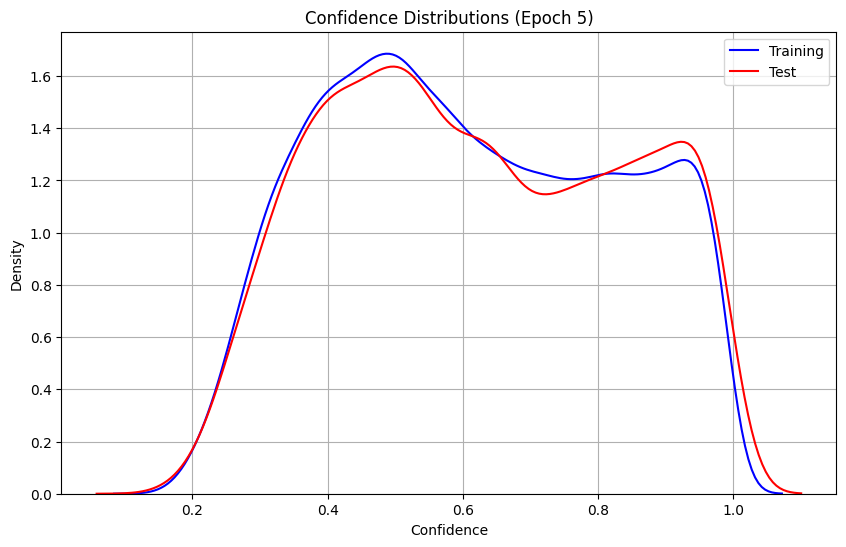

--------------------------------------------------
Epoch [106/400]
  Training: Loss: 0.9472, Accuracy: 67.26%, Confidence: 0.6109
  Testing:  Loss: 0.9978, Accuracy: 65.07%, Confidence: 0.6170
--------------------------------------------------
Epoch [107/400]
  Training: Loss: 0.9389, Accuracy: 67.70%, Confidence: 0.6153
  Testing:  Loss: 0.9663, Accuracy: 66.19%, Confidence: 0.6172
--------------------------------------------------
Epoch [108/400]
  Training: Loss: 0.9352, Accuracy: 67.68%, Confidence: 0.6152
  Testing:  Loss: 1.0021, Accuracy: 64.81%, Confidence: 0.6183
--------------------------------------------------
Epoch [109/400]
  Training: Loss: 0.9314, Accuracy: 67.81%, Confidence: 0.6160
  Testing:  Loss: 0.9675, Accuracy: 65.82%, Confidence: 0.6268
--------------------------------------------------
Epoch [110/400]
  Training: Loss: 0.9293, Accuracy: 68.04%, Confidence: 0.6193
  Testing:  Loss: 0.9645, Accuracy: 66.30%, Confidence: 0.6318
Stats: KS=0.0282(p=0.0000), MW=2415

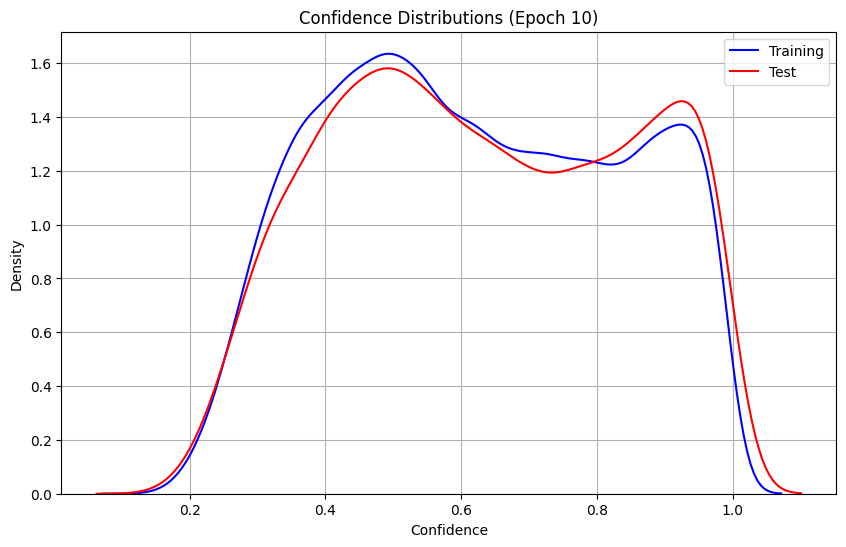

--------------------------------------------------
Epoch [111/400]
  Training: Loss: 0.9228, Accuracy: 68.20%, Confidence: 0.6211
  Testing:  Loss: 0.9684, Accuracy: 65.91%, Confidence: 0.6263
--------------------------------------------------
Epoch [112/400]
  Training: Loss: 0.9145, Accuracy: 68.45%, Confidence: 0.6251
  Testing:  Loss: 0.9454, Accuracy: 67.20%, Confidence: 0.6291
--------------------------------------------------
Epoch [113/400]
  Training: Loss: 0.9108, Accuracy: 68.42%, Confidence: 0.6260
  Testing:  Loss: 0.9650, Accuracy: 66.18%, Confidence: 0.6235
--------------------------------------------------
Epoch [114/400]
  Training: Loss: 0.9182, Accuracy: 68.40%, Confidence: 0.6234
  Testing:  Loss: 1.0726, Accuracy: 61.90%, Confidence: 0.6191
--------------------------------------------------
Epoch [115/400]
  Training: Loss: 0.9430, Accuracy: 67.41%, Confidence: 0.6134
  Testing:  Loss: 0.9737, Accuracy: 66.07%, Confidence: 0.6104
Stats: KS=0.0166(p=0.0196), MW=2520

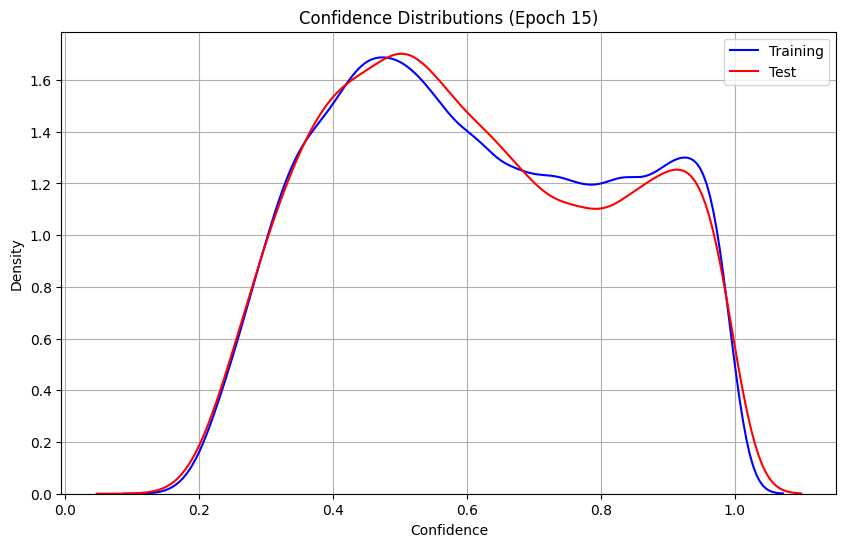

--------------------------------------------------
Epoch [116/400]
  Training: Loss: 0.9415, Accuracy: 67.47%, Confidence: 0.6157
  Testing:  Loss: 0.9849, Accuracy: 65.32%, Confidence: 0.6195
--------------------------------------------------
Epoch [117/400]
  Training: Loss: 0.9327, Accuracy: 67.82%, Confidence: 0.6156
  Testing:  Loss: 1.0592, Accuracy: 61.57%, Confidence: 0.6221
--------------------------------------------------
Epoch [118/400]
  Training: Loss: 0.9476, Accuracy: 67.39%, Confidence: 0.6130
  Testing:  Loss: 0.9847, Accuracy: 66.09%, Confidence: 0.6149
--------------------------------------------------
Epoch [119/400]
  Training: Loss: 0.9296, Accuracy: 68.04%, Confidence: 0.6187
  Testing:  Loss: 0.9513, Accuracy: 66.48%, Confidence: 0.6281
--------------------------------------------------
Epoch [120/400]
  Training: Loss: 0.9208, Accuracy: 68.16%, Confidence: 0.6218
  Testing:  Loss: 1.0498, Accuracy: 62.25%, Confidence: 0.5958
Model saved successfully to model_c

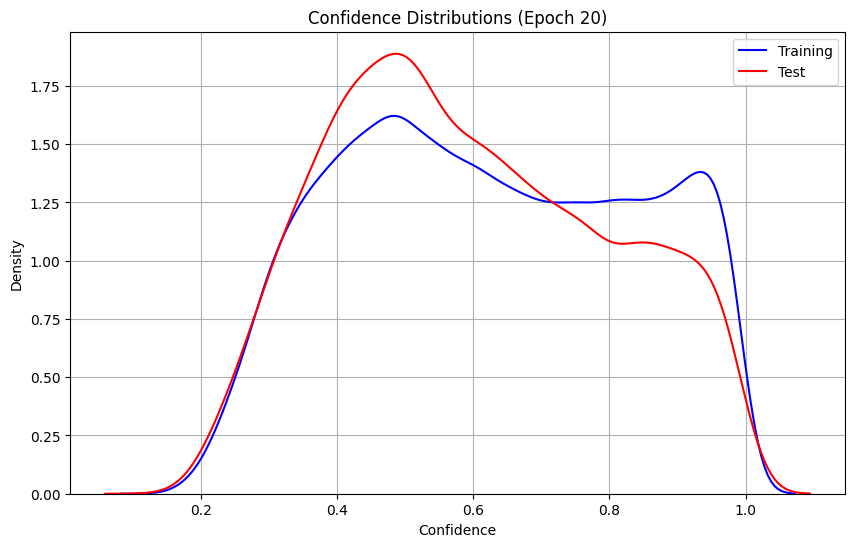

--------------------------------------------------
Epoch [121/400]
  Training: Loss: 0.9173, Accuracy: 68.39%, Confidence: 0.6224
  Testing:  Loss: 0.9531, Accuracy: 67.20%, Confidence: 0.6258
--------------------------------------------------
Epoch [122/400]
  Training: Loss: 0.9144, Accuracy: 68.39%, Confidence: 0.6258
  Testing:  Loss: 0.9701, Accuracy: 66.08%, Confidence: 0.6248
--------------------------------------------------
Epoch [123/400]
  Training: Loss: 0.9076, Accuracy: 68.72%, Confidence: 0.6296
  Testing:  Loss: 0.9588, Accuracy: 66.22%, Confidence: 0.6320
--------------------------------------------------
Epoch [124/400]
  Training: Loss: 0.9052, Accuracy: 68.78%, Confidence: 0.6290
  Testing:  Loss: 0.9352, Accuracy: 67.22%, Confidence: 0.6407
--------------------------------------------------
Epoch [125/400]
  Training: Loss: 0.8919, Accuracy: 69.35%, Confidence: 0.6338
  Testing:  Loss: 0.9231, Accuracy: 68.08%, Confidence: 0.6334
Stats: KS=0.0082(p=0.6327), MW=2502

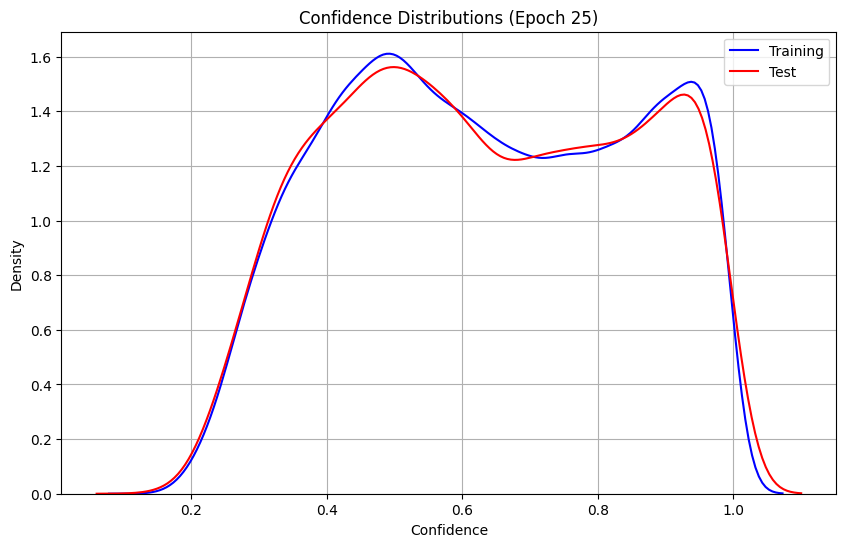

--------------------------------------------------
Epoch [126/400]
  Training: Loss: 0.8918, Accuracy: 69.40%, Confidence: 0.6344
  Testing:  Loss: 2.5480, Accuracy: 40.18%, Confidence: 0.6974
--------------------------------------------------
Epoch [127/400]
  Training: Loss: 0.8952, Accuracy: 69.12%, Confidence: 0.6332
  Testing:  Loss: 0.9758, Accuracy: 65.68%, Confidence: 0.6495
--------------------------------------------------
Epoch [128/400]
  Training: Loss: 0.9047, Accuracy: 68.75%, Confidence: 0.6337
  Testing:  Loss: 0.9441, Accuracy: 66.63%, Confidence: 0.6329
--------------------------------------------------
Epoch [129/400]
  Training: Loss: 0.9228, Accuracy: 67.81%, Confidence: 0.6279
  Testing:  Loss: 0.9693, Accuracy: 65.80%, Confidence: 0.6307
--------------------------------------------------
Epoch [130/400]
  Training: Loss: 0.9182, Accuracy: 68.30%, Confidence: 0.6278
  Testing:  Loss: 0.9672, Accuracy: 66.18%, Confidence: 0.6309
Stats: KS=0.0089(p=0.5241), MW=2480

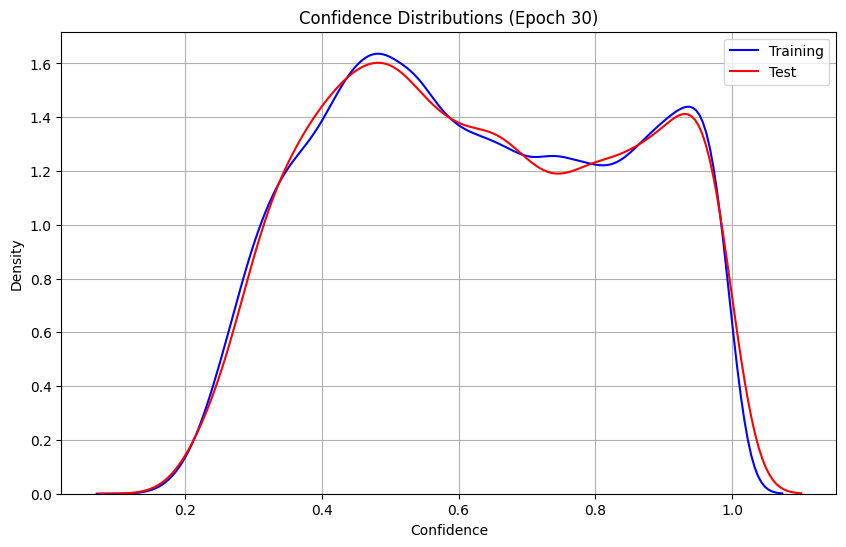

--------------------------------------------------
Epoch [131/400]
  Training: Loss: 0.9112, Accuracy: 68.43%, Confidence: 0.6279
  Testing:  Loss: 0.9411, Accuracy: 67.15%, Confidence: 0.6380
--------------------------------------------------
Epoch [132/400]
  Training: Loss: 0.8982, Accuracy: 68.93%, Confidence: 0.6321
  Testing:  Loss: 0.9630, Accuracy: 66.20%, Confidence: 0.6268
--------------------------------------------------
Epoch [133/400]
  Training: Loss: 0.8938, Accuracy: 69.14%, Confidence: 0.6362
  Testing:  Loss: 0.9207, Accuracy: 68.01%, Confidence: 0.6460
--------------------------------------------------
Epoch [134/400]
  Training: Loss: 0.8901, Accuracy: 69.16%, Confidence: 0.6377
  Testing:  Loss: 0.9379, Accuracy: 67.00%, Confidence: 0.6475
--------------------------------------------------
Epoch [135/400]
  Training: Loss: 0.8870, Accuracy: 69.44%, Confidence: 0.6392
  Testing:  Loss: 0.9648, Accuracy: 66.93%, Confidence: 0.6435
Stats: KS=0.0132(p=0.1077), MW=2469

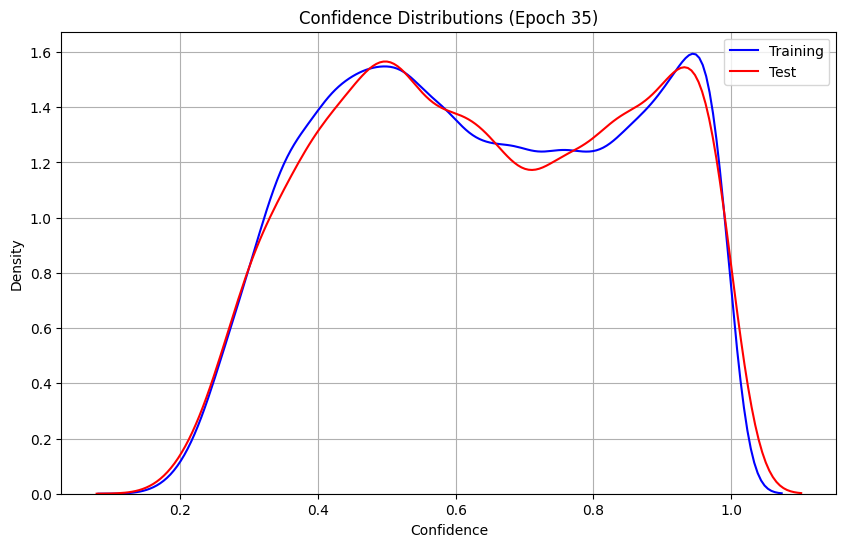

--------------------------------------------------
Epoch [136/400]
  Training: Loss: 0.8737, Accuracy: 69.81%, Confidence: 0.6433
  Testing:  Loss: 0.9258, Accuracy: 67.82%, Confidence: 0.6474
--------------------------------------------------
Epoch [137/400]
  Training: Loss: 0.8739, Accuracy: 70.00%, Confidence: 0.6428
  Testing:  Loss: 0.9248, Accuracy: 67.94%, Confidence: 0.6438
--------------------------------------------------
Epoch [138/400]
  Training: Loss: 0.8662, Accuracy: 70.39%, Confidence: 0.6448
  Testing:  Loss: 0.9382, Accuracy: 66.96%, Confidence: 0.6330
--------------------------------------------------
Epoch [139/400]
  Training: Loss: 0.8687, Accuracy: 70.04%, Confidence: 0.6455
  Testing:  Loss: 0.9363, Accuracy: 67.27%, Confidence: 0.6554
--------------------------------------------------
Epoch [140/400]
  Training: Loss: 0.8605, Accuracy: 70.37%, Confidence: 0.6473
  Testing:  Loss: 0.9458, Accuracy: 67.03%, Confidence: 0.6455
Model saved successfully to model_c

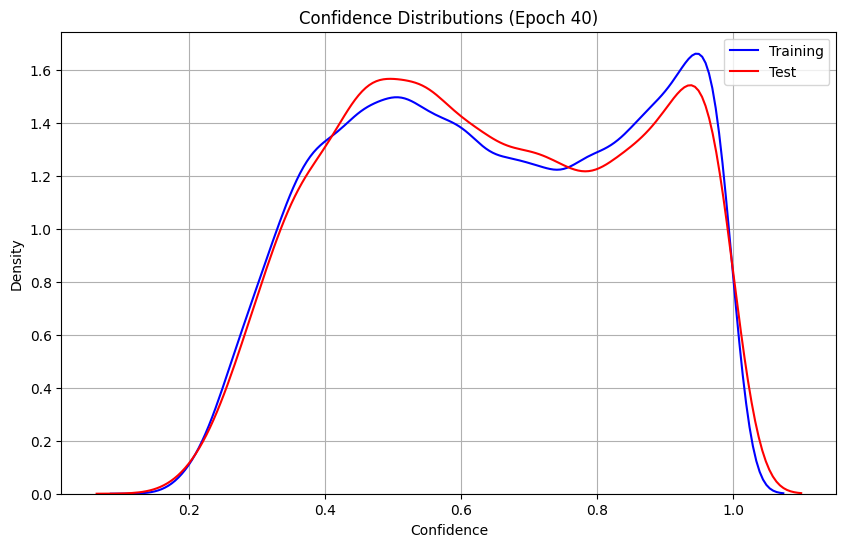

--------------------------------------------------
Epoch [141/400]
  Training: Loss: 0.8626, Accuracy: 70.22%, Confidence: 0.6467
  Testing:  Loss: 0.9107, Accuracy: 68.13%, Confidence: 0.6456
--------------------------------------------------
Epoch [142/400]
  Training: Loss: 0.8582, Accuracy: 70.47%, Confidence: 0.6484
  Testing:  Loss: 0.9282, Accuracy: 67.43%, Confidence: 0.6461
--------------------------------------------------
Epoch [143/400]
  Training: Loss: 0.8663, Accuracy: 70.11%, Confidence: 0.6441
  Testing:  Loss: 0.9047, Accuracy: 68.99%, Confidence: 0.6514
--------------------------------------------------
Epoch [144/400]
  Training: Loss: 0.8567, Accuracy: 70.43%, Confidence: 0.6487
  Testing:  Loss: 0.9093, Accuracy: 68.30%, Confidence: 0.6520
--------------------------------------------------
Epoch [145/400]
  Training: Loss: 0.8548, Accuracy: 70.54%, Confidence: 0.6495
  Testing:  Loss: 0.8995, Accuracy: 68.94%, Confidence: 0.6614
Stats: KS=0.0300(p=0.0000), MW=2420

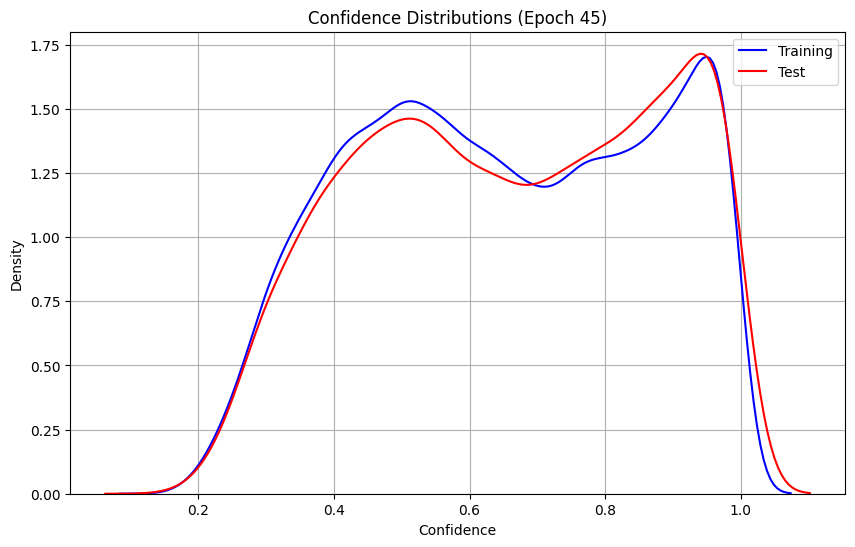

--------------------------------------------------
Epoch [146/400]
  Training: Loss: 0.8481, Accuracy: 70.64%, Confidence: 0.6508
  Testing:  Loss: 0.8883, Accuracy: 69.25%, Confidence: 0.6503
--------------------------------------------------
Epoch [147/400]
  Training: Loss: 0.8473, Accuracy: 71.01%, Confidence: 0.6519
  Testing:  Loss: 0.9092, Accuracy: 68.73%, Confidence: 0.6596
--------------------------------------------------
Epoch [148/400]
  Training: Loss: 0.8521, Accuracy: 70.66%, Confidence: 0.6506
  Testing:  Loss: 0.8958, Accuracy: 68.87%, Confidence: 0.6561
--------------------------------------------------
Epoch [149/400]
  Training: Loss: 0.8505, Accuracy: 70.62%, Confidence: 0.6512
  Testing:  Loss: 0.9008, Accuracy: 68.90%, Confidence: 0.6592
--------------------------------------------------
Epoch [150/400]
  Training: Loss: 0.8494, Accuracy: 70.83%, Confidence: 0.6538
  Testing:  Loss: 0.8964, Accuracy: 68.93%, Confidence: 0.6562
Stats: KS=0.0082(p=0.6296), MW=2482

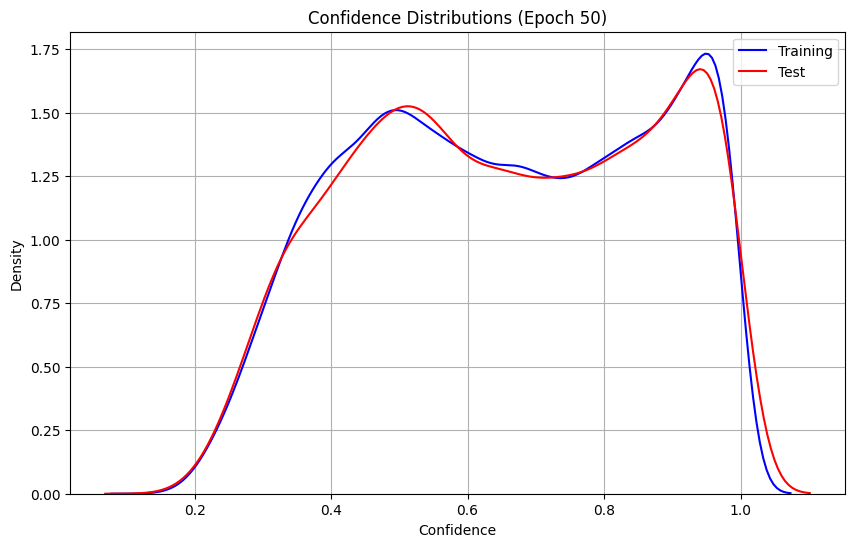

--------------------------------------------------
Epoch [151/400]
  Training: Loss: 0.8499, Accuracy: 70.73%, Confidence: 0.6517
  Testing:  Loss: 0.9068, Accuracy: 68.38%, Confidence: 0.6475
--------------------------------------------------
Epoch [152/400]
  Training: Loss: 0.8453, Accuracy: 70.95%, Confidence: 0.6532
  Testing:  Loss: 1.0017, Accuracy: 64.42%, Confidence: 0.6480
--------------------------------------------------
Epoch [153/400]
  Training: Loss: 0.8501, Accuracy: 70.68%, Confidence: 0.6541
  Testing:  Loss: 0.8914, Accuracy: 69.11%, Confidence: 0.6534
--------------------------------------------------
Epoch [154/400]
  Training: Loss: 0.8418, Accuracy: 71.07%, Confidence: 0.6541
  Testing:  Loss: 0.8998, Accuracy: 68.99%, Confidence: 0.6574
--------------------------------------------------
Epoch [155/400]
  Training: Loss: 0.8481, Accuracy: 70.74%, Confidence: 0.6515
  Testing:  Loss: 0.8935, Accuracy: 68.92%, Confidence: 0.6542
Stats: KS=0.0118(p=0.1947), MW=2481

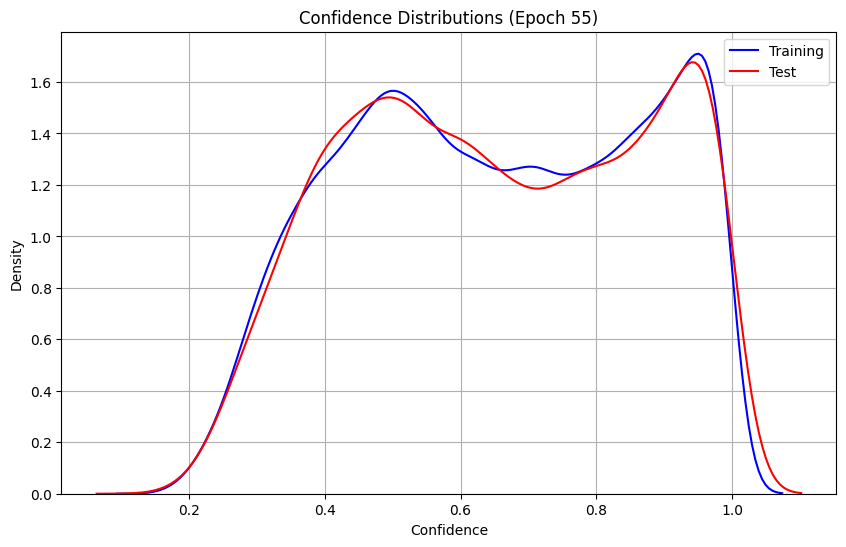

--------------------------------------------------
Epoch [156/400]
  Training: Loss: 0.8544, Accuracy: 70.60%, Confidence: 0.6505
  Testing:  Loss: 0.9065, Accuracy: 68.58%, Confidence: 0.6525
--------------------------------------------------
Epoch [157/400]
  Training: Loss: 0.8535, Accuracy: 70.48%, Confidence: 0.6522
  Testing:  Loss: 0.9057, Accuracy: 68.58%, Confidence: 0.6593
--------------------------------------------------
Epoch [158/400]
  Training: Loss: 0.8509, Accuracy: 70.65%, Confidence: 0.6546
  Testing:  Loss: 0.9021, Accuracy: 68.95%, Confidence: 0.6586
--------------------------------------------------
Epoch [159/400]
  Training: Loss: 0.8909, Accuracy: 69.51%, Confidence: 0.6422
  Testing:  Loss: 0.9183, Accuracy: 68.20%, Confidence: 0.6505
--------------------------------------------------
Epoch [160/400]
  Training: Loss: 0.8716, Accuracy: 70.00%, Confidence: 0.6434
  Testing:  Loss: 0.9827, Accuracy: 65.79%, Confidence: 0.6538
Model saved successfully to model_c

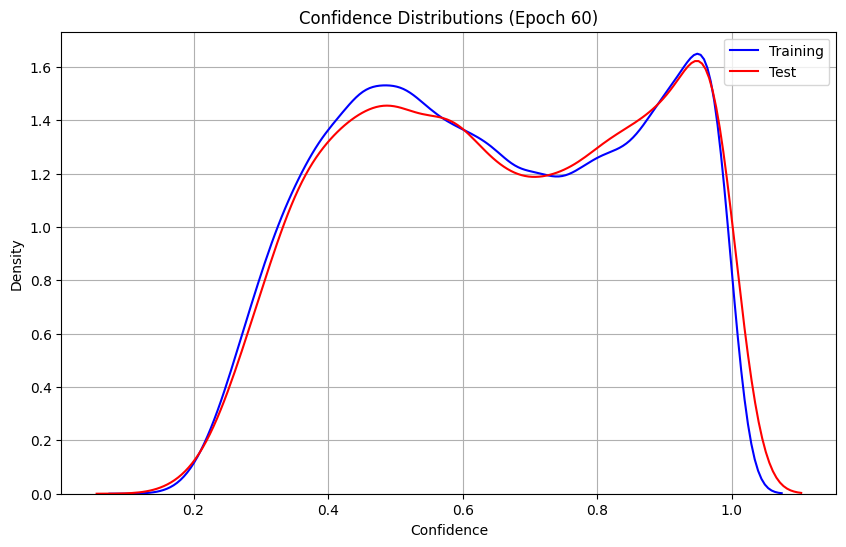

--------------------------------------------------
Epoch [161/400]
  Training: Loss: 0.8611, Accuracy: 70.52%, Confidence: 0.6473
  Testing:  Loss: 0.9272, Accuracy: 67.76%, Confidence: 0.6541
--------------------------------------------------
Epoch [162/400]
  Training: Loss: 0.8634, Accuracy: 70.53%, Confidence: 0.6474
  Testing:  Loss: 0.9027, Accuracy: 68.81%, Confidence: 0.6451
--------------------------------------------------
Epoch [163/400]
  Training: Loss: 0.8639, Accuracy: 70.39%, Confidence: 0.6430
  Testing:  Loss: 0.9248, Accuracy: 67.73%, Confidence: 0.6451
--------------------------------------------------
Epoch [164/400]
  Training: Loss: 0.8582, Accuracy: 70.49%, Confidence: 0.6480
  Testing:  Loss: 1.1989, Accuracy: 58.19%, Confidence: 0.6634
--------------------------------------------------
Epoch [165/400]
  Training: Loss: 0.8650, Accuracy: 70.15%, Confidence: 0.6458
  Testing:  Loss: 0.9452, Accuracy: 66.42%, Confidence: 0.6454
Stats: KS=0.0110(p=0.2598), MW=2502

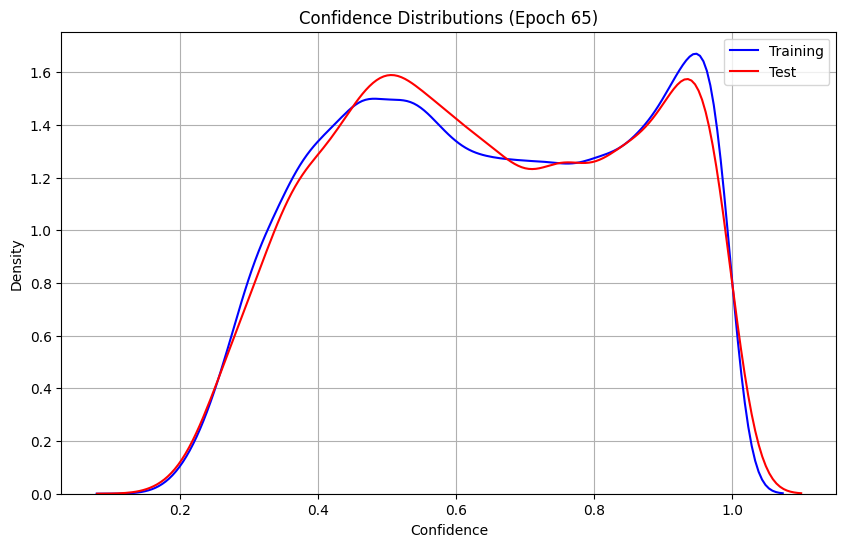

--------------------------------------------------
Epoch [166/400]
  Training: Loss: 0.8625, Accuracy: 70.08%, Confidence: 0.6469
  Testing:  Loss: 0.9182, Accuracy: 68.03%, Confidence: 0.6486
--------------------------------------------------
Epoch [167/400]
  Training: Loss: 0.8629, Accuracy: 70.21%, Confidence: 0.6472
  Testing:  Loss: 1.0597, Accuracy: 62.18%, Confidence: 0.6416
--------------------------------------------------
Epoch [168/400]
  Training: Loss: 0.8522, Accuracy: 70.74%, Confidence: 0.6498
  Testing:  Loss: 0.8965, Accuracy: 68.80%, Confidence: 0.6480
--------------------------------------------------
Epoch [169/400]
  Training: Loss: 0.8505, Accuracy: 70.79%, Confidence: 0.6523
  Testing:  Loss: 0.9023, Accuracy: 68.39%, Confidence: 0.6570
--------------------------------------------------
Epoch [170/400]
  Training: Loss: 0.8414, Accuracy: 71.16%, Confidence: 0.6556
  Testing:  Loss: 0.9419, Accuracy: 66.29%, Confidence: 0.6598
Stats: KS=0.0146(p=0.0579), MW=2474

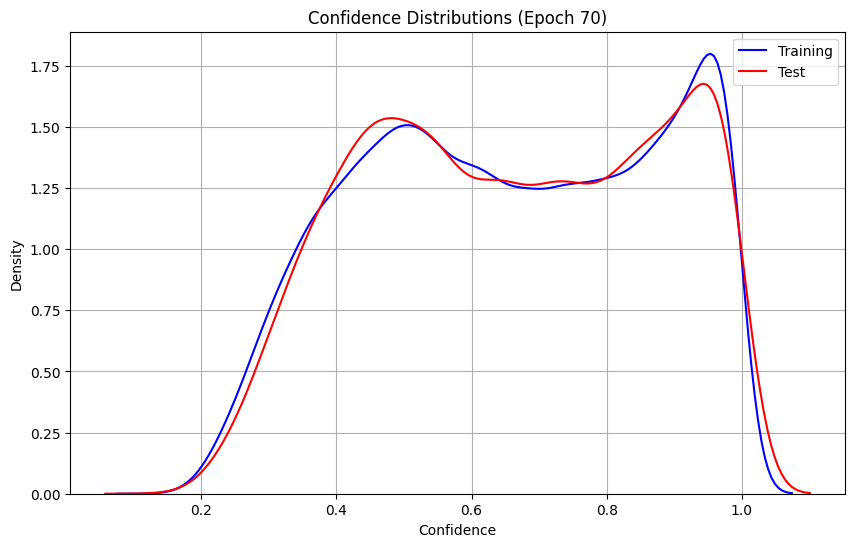

--------------------------------------------------
Epoch [171/400]
  Training: Loss: 0.8410, Accuracy: 71.27%, Confidence: 0.6542
  Testing:  Loss: 0.9174, Accuracy: 67.96%, Confidence: 0.6655
--------------------------------------------------
Epoch [172/400]
  Training: Loss: 0.8517, Accuracy: 70.75%, Confidence: 0.6560
  Testing:  Loss: 0.8993, Accuracy: 68.71%, Confidence: 0.6556
--------------------------------------------------
Epoch [173/400]
  Training: Loss: 0.8602, Accuracy: 70.52%, Confidence: 0.6501
  Testing:  Loss: 0.9128, Accuracy: 67.83%, Confidence: 0.6589
--------------------------------------------------
Epoch [174/400]
  Training: Loss: 0.8517, Accuracy: 70.93%, Confidence: 0.6535
  Testing:  Loss: 0.9062, Accuracy: 68.77%, Confidence: 0.6623
--------------------------------------------------
Epoch [175/400]
  Training: Loss: 0.8420, Accuracy: 71.11%, Confidence: 0.6546
  Testing:  Loss: 0.9162, Accuracy: 68.21%, Confidence: 0.6665
Stats: KS=0.0313(p=0.0000), MW=2416

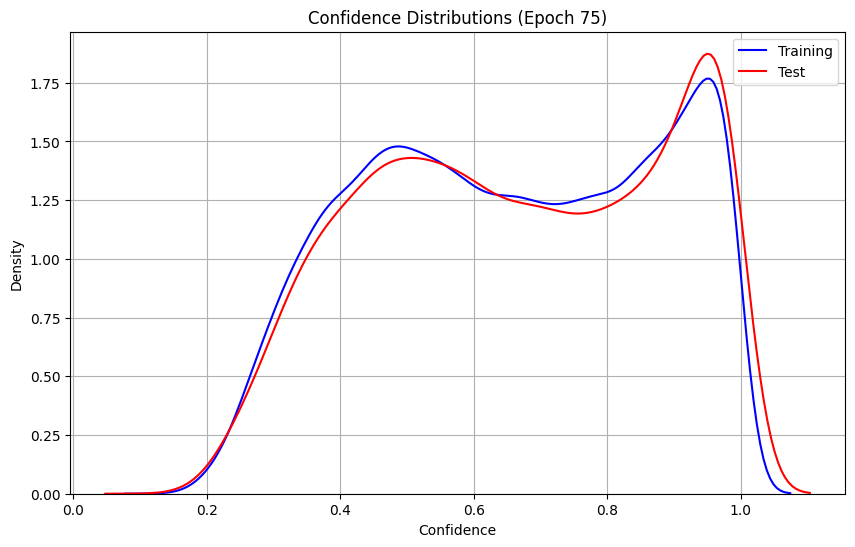

--------------------------------------------------
Epoch [176/400]
  Training: Loss: 0.8385, Accuracy: 71.07%, Confidence: 0.6585
  Testing:  Loss: 0.8996, Accuracy: 68.49%, Confidence: 0.6532
--------------------------------------------------
Epoch [177/400]
  Training: Loss: 0.8336, Accuracy: 71.47%, Confidence: 0.6587
  Testing:  Loss: 0.8916, Accuracy: 69.06%, Confidence: 0.6626
--------------------------------------------------
Epoch [178/400]
  Training: Loss: 0.8242, Accuracy: 71.56%, Confidence: 0.6616
  Testing:  Loss: 0.8841, Accuracy: 69.59%, Confidence: 0.6606
--------------------------------------------------
Epoch [179/400]
  Training: Loss: 0.8210, Accuracy: 71.97%, Confidence: 0.6628
  Testing:  Loss: 0.8941, Accuracy: 69.18%, Confidence: 0.6583
--------------------------------------------------
Epoch [180/400]
  Training: Loss: 0.8278, Accuracy: 71.53%, Confidence: 0.6612
  Testing:  Loss: 0.9114, Accuracy: 68.45%, Confidence: 0.6644
Model saved successfully to model_c

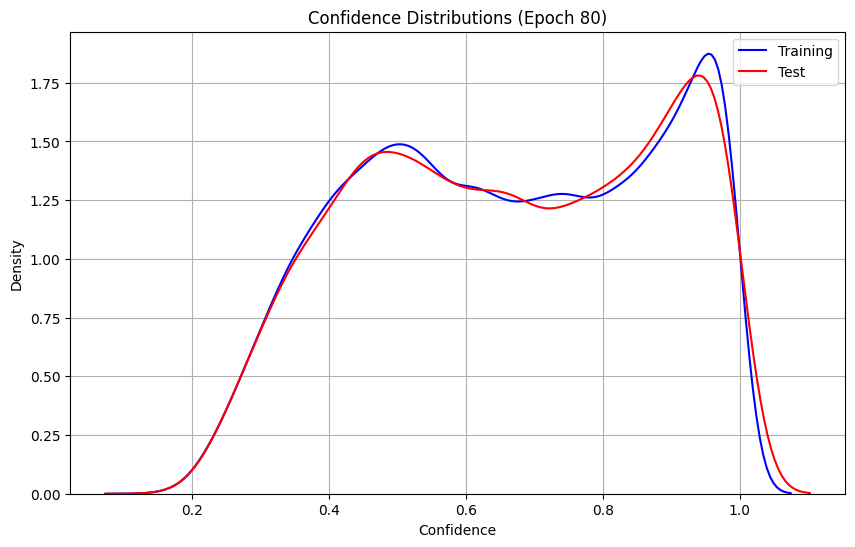

--------------------------------------------------
Epoch [181/400]
  Training: Loss: 0.8136, Accuracy: 72.15%, Confidence: 0.6644
  Testing:  Loss: 0.8818, Accuracy: 69.00%, Confidence: 0.6676
--------------------------------------------------
Epoch [182/400]
  Training: Loss: 0.8139, Accuracy: 72.16%, Confidence: 0.6649
  Testing:  Loss: 0.9129, Accuracy: 68.54%, Confidence: 0.6717
--------------------------------------------------
Epoch [183/400]
  Training: Loss: 0.8166, Accuracy: 71.95%, Confidence: 0.6634
  Testing:  Loss: 0.8729, Accuracy: 70.07%, Confidence: 0.6709
--------------------------------------------------
Epoch [184/400]
  Training: Loss: 0.8164, Accuracy: 72.10%, Confidence: 0.6645
  Testing:  Loss: 0.9188, Accuracy: 68.43%, Confidence: 0.6553
--------------------------------------------------
Epoch [185/400]
  Training: Loss: 0.8158, Accuracy: 72.02%, Confidence: 0.6636
  Testing:  Loss: 0.9064, Accuracy: 68.62%, Confidence: 0.6664
Stats: KS=0.0158(p=0.0302), MW=2475

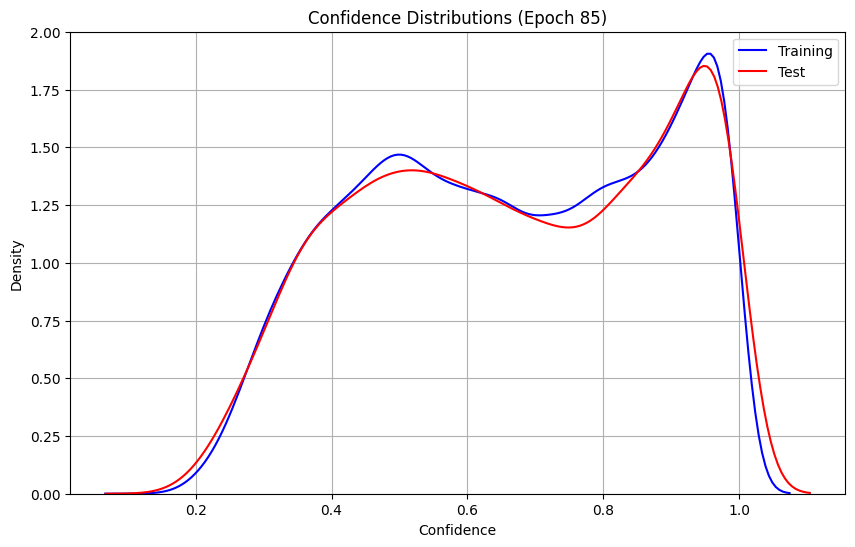

--------------------------------------------------
Epoch [186/400]
  Training: Loss: 0.8113, Accuracy: 72.35%, Confidence: 0.6663
  Testing:  Loss: 0.9204, Accuracy: 67.64%, Confidence: 0.6644
--------------------------------------------------
Epoch [187/400]
  Training: Loss: 0.8430, Accuracy: 70.93%, Confidence: 0.6566
  Testing:  Loss: 0.8788, Accuracy: 69.89%, Confidence: 0.6677
--------------------------------------------------
Epoch [188/400]
  Training: Loss: 0.8194, Accuracy: 71.66%, Confidence: 0.6640
  Testing:  Loss: 0.8920, Accuracy: 69.24%, Confidence: 0.6596
--------------------------------------------------
Epoch [189/400]
  Training: Loss: 0.8221, Accuracy: 71.78%, Confidence: 0.6645
  Testing:  Loss: 0.9360, Accuracy: 66.85%, Confidence: 0.6533
--------------------------------------------------
Epoch [190/400]
  Training: Loss: 0.8268, Accuracy: 71.66%, Confidence: 0.6615
  Testing:  Loss: 1.1129, Accuracy: 61.22%, Confidence: 0.6761
Stats: KS=0.0370(p=0.0000), MW=2395

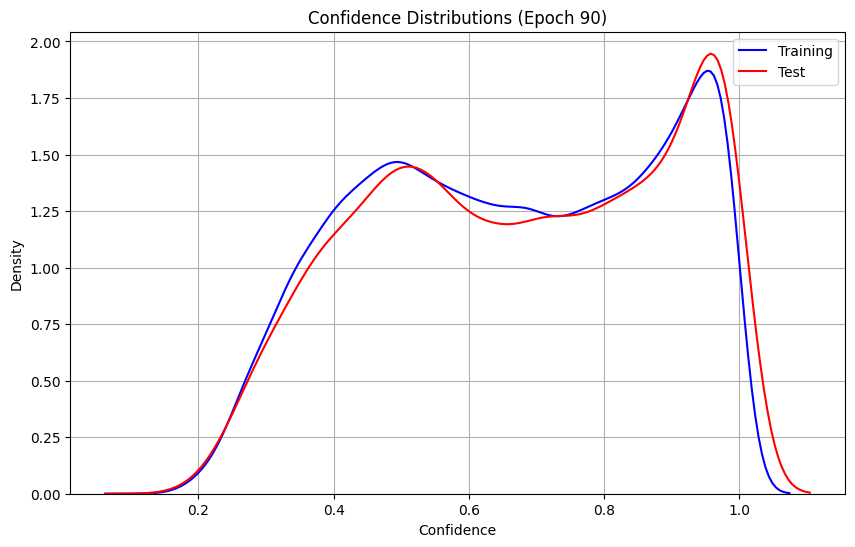

--------------------------------------------------
Epoch [191/400]
  Training: Loss: 0.8414, Accuracy: 70.97%, Confidence: 0.6583
  Testing:  Loss: 1.8391, Accuracy: 43.65%, Confidence: 0.6714
--------------------------------------------------
Epoch [192/400]
  Training: Loss: 0.8280, Accuracy: 71.26%, Confidence: 0.6614
  Testing:  Loss: 1.0985, Accuracy: 60.84%, Confidence: 0.6575
--------------------------------------------------
Epoch [193/400]
  Training: Loss: 0.8164, Accuracy: 72.18%, Confidence: 0.6641
  Testing:  Loss: 0.8959, Accuracy: 69.18%, Confidence: 0.6632
--------------------------------------------------
Epoch [194/400]
  Training: Loss: 0.8079, Accuracy: 72.39%, Confidence: 0.6687
  Testing:  Loss: 0.8918, Accuracy: 69.06%, Confidence: 0.6672
--------------------------------------------------
Epoch [195/400]
  Training: Loss: 0.8057, Accuracy: 72.23%, Confidence: 0.6679
  Testing:  Loss: 0.8588, Accuracy: 70.27%, Confidence: 0.6738
Stats: KS=0.0191(p=0.0045), MW=2462

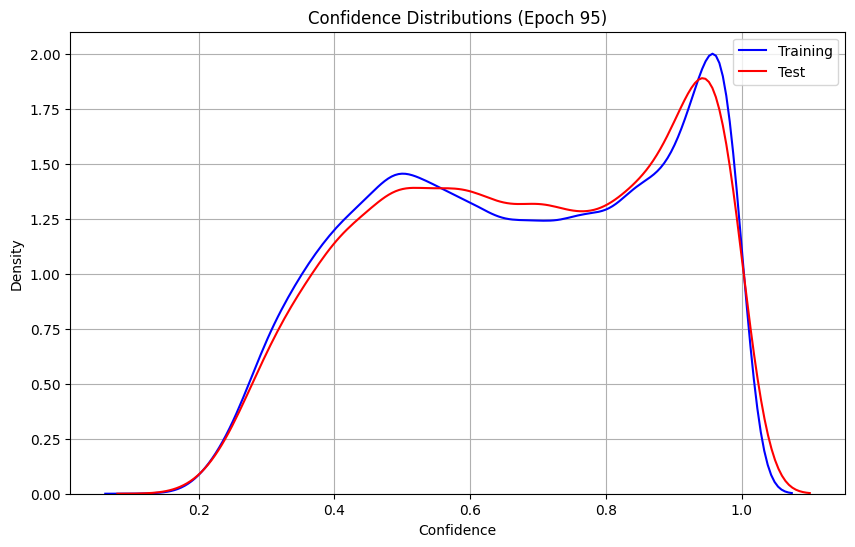

--------------------------------------------------
Epoch [196/400]
  Training: Loss: 0.8035, Accuracy: 72.42%, Confidence: 0.6718
  Testing:  Loss: 0.8744, Accuracy: 69.88%, Confidence: 0.6652
--------------------------------------------------
Epoch [197/400]
  Training: Loss: 0.7985, Accuracy: 72.62%, Confidence: 0.6715
  Testing:  Loss: 0.8599, Accuracy: 70.26%, Confidence: 0.6778
--------------------------------------------------
Epoch [198/400]
  Training: Loss: 0.8268, Accuracy: 71.47%, Confidence: 0.6628
  Testing:  Loss: 0.9457, Accuracy: 66.61%, Confidence: 0.6691
--------------------------------------------------
Epoch [199/400]
  Training: Loss: 0.8170, Accuracy: 71.81%, Confidence: 0.6674
  Testing:  Loss: 0.8735, Accuracy: 69.55%, Confidence: 0.6693
--------------------------------------------------
Epoch [200/400]
  Training: Loss: 0.7991, Accuracy: 72.60%, Confidence: 0.6745
  Testing:  Loss: 0.8790, Accuracy: 69.44%, Confidence: 0.6706
Model saved successfully to model_c

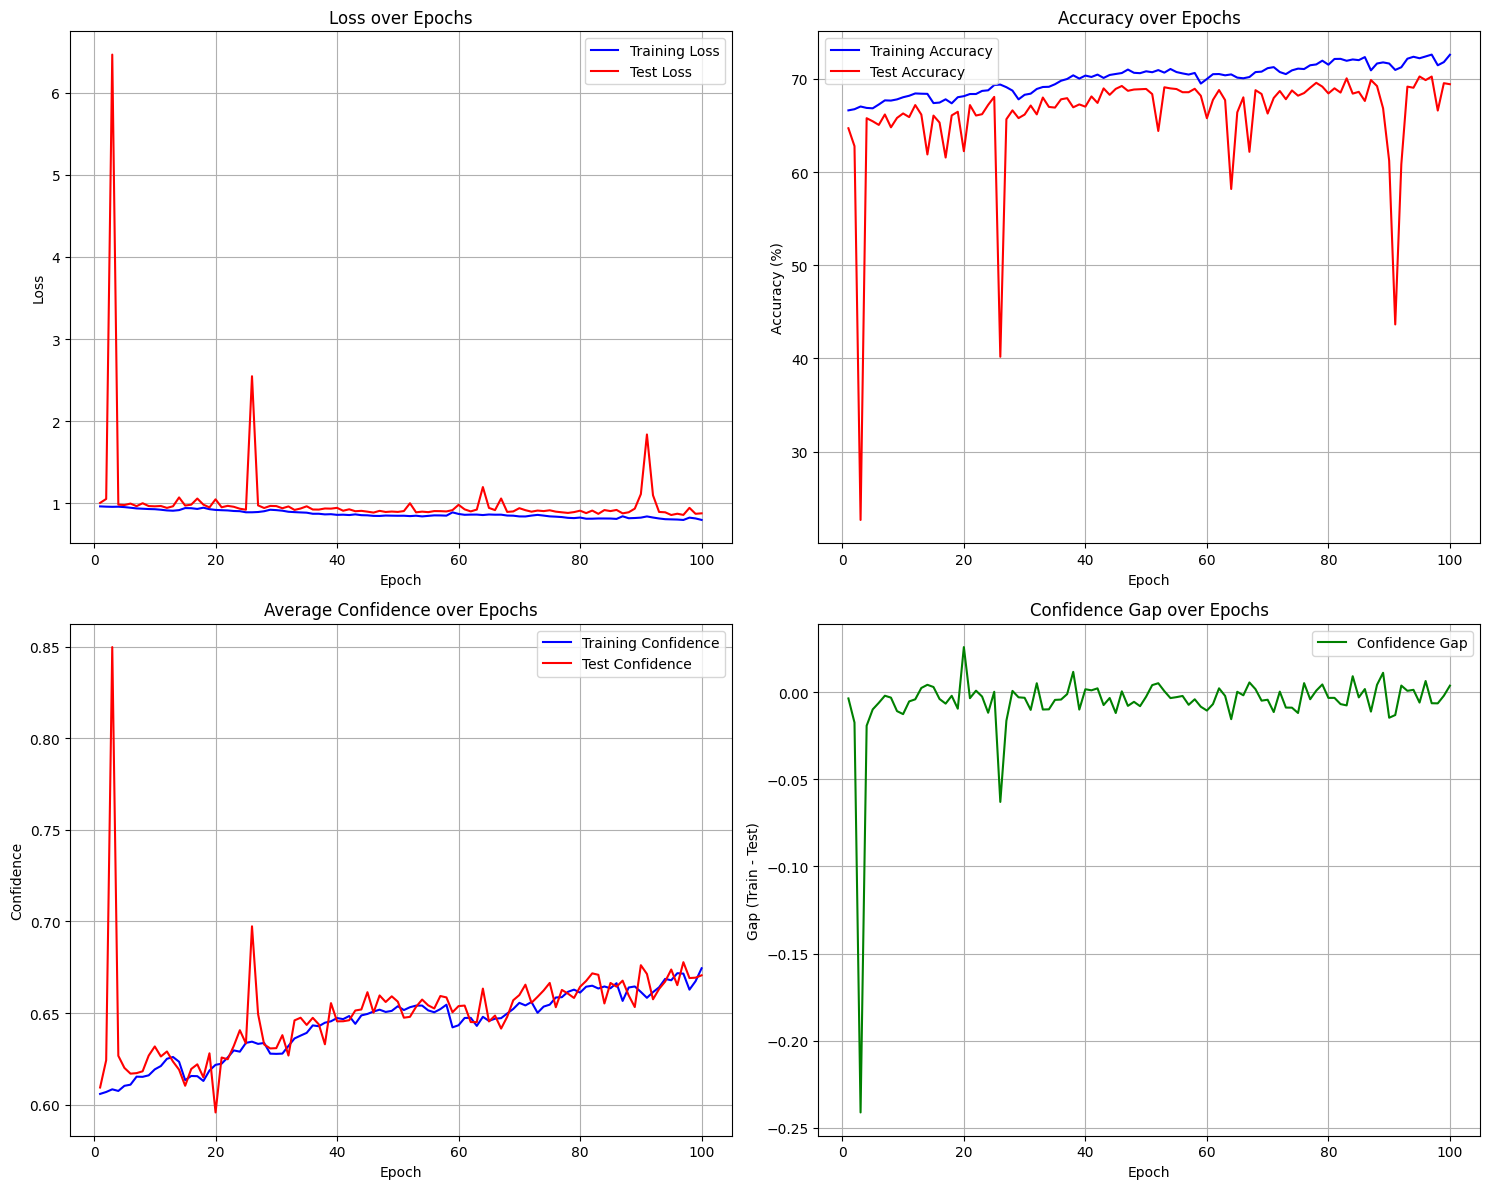

Saved plots for epochs 101-200
--------------------------------------------------
Epoch [201/400]
  Training: Loss: 0.7942, Accuracy: 72.57%, Confidence: 0.6734
  Testing:  Loss: 0.9321, Accuracy: 67.24%, Confidence: 0.6686
--------------------------------------------------
Epoch [202/400]
  Training: Loss: 0.8250, Accuracy: 71.48%, Confidence: 0.6665
  Testing:  Loss: 1.5029, Accuracy: 53.26%, Confidence: 0.6803
--------------------------------------------------
Epoch [203/400]
  Training: Loss: 0.8174, Accuracy: 71.92%, Confidence: 0.6663
  Testing:  Loss: 0.8851, Accuracy: 68.77%, Confidence: 0.6660
--------------------------------------------------
Epoch [204/400]
  Training: Loss: 0.8064, Accuracy: 72.31%, Confidence: 0.6695
  Testing:  Loss: 0.9032, Accuracy: 68.37%, Confidence: 0.6681
--------------------------------------------------
Epoch [205/400]
  Training: Loss: 0.8242, Accuracy: 71.77%, Confidence: 0.6636
  Testing:  Loss: 0.9460, Accuracy: 66.89%, Confidence: 0.6603
Stat

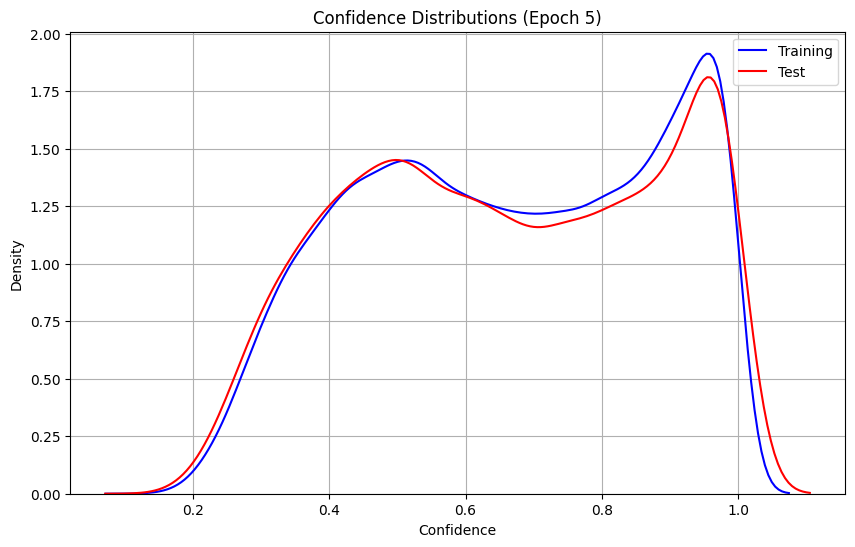

--------------------------------------------------
Epoch [206/400]
  Training: Loss: 0.8162, Accuracy: 71.95%, Confidence: 0.6646
  Testing:  Loss: 0.8763, Accuracy: 69.49%, Confidence: 0.6687
--------------------------------------------------
Epoch [207/400]
  Training: Loss: 0.7924, Accuracy: 72.81%, Confidence: 0.6767
  Testing:  Loss: 0.8563, Accuracy: 70.56%, Confidence: 0.6685
--------------------------------------------------
Epoch [208/400]
  Training: Loss: 0.7865, Accuracy: 72.99%, Confidence: 0.6774
  Testing:  Loss: 0.8602, Accuracy: 69.78%, Confidence: 0.6736
--------------------------------------------------
Epoch [209/400]
  Training: Loss: 0.7873, Accuracy: 73.19%, Confidence: 0.6761
  Testing:  Loss: 0.8804, Accuracy: 69.37%, Confidence: 0.6744
--------------------------------------------------
Epoch [210/400]
  Training: Loss: 0.7895, Accuracy: 72.84%, Confidence: 0.6768
  Testing:  Loss: 0.8647, Accuracy: 69.91%, Confidence: 0.6744
Stats: KS=0.0124(p=0.1516), MW=2518

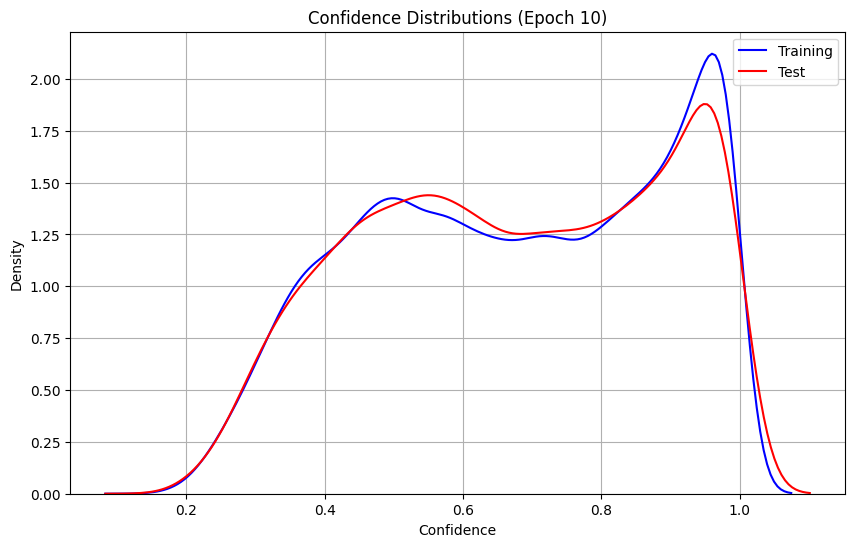

--------------------------------------------------
Epoch [211/400]
  Training: Loss: 0.7871, Accuracy: 72.93%, Confidence: 0.6783
  Testing:  Loss: 0.8836, Accuracy: 68.68%, Confidence: 0.6806
--------------------------------------------------
Epoch [212/400]
  Training: Loss: 0.7867, Accuracy: 73.02%, Confidence: 0.6795
  Testing:  Loss: 0.8534, Accuracy: 70.55%, Confidence: 0.6851
--------------------------------------------------
Epoch [213/400]
  Training: Loss: 0.7834, Accuracy: 73.01%, Confidence: 0.6803
  Testing:  Loss: 0.8830, Accuracy: 68.96%, Confidence: 0.6718
--------------------------------------------------
Epoch [214/400]
  Training: Loss: 0.8012, Accuracy: 72.41%, Confidence: 0.6748
  Testing:  Loss: 0.8821, Accuracy: 69.53%, Confidence: 0.6694
--------------------------------------------------
Epoch [215/400]
  Training: Loss: 0.7911, Accuracy: 72.86%, Confidence: 0.6789
  Testing:  Loss: 0.9055, Accuracy: 68.72%, Confidence: 0.6836
Stats: KS=0.0141(p=0.0728), MW=2466

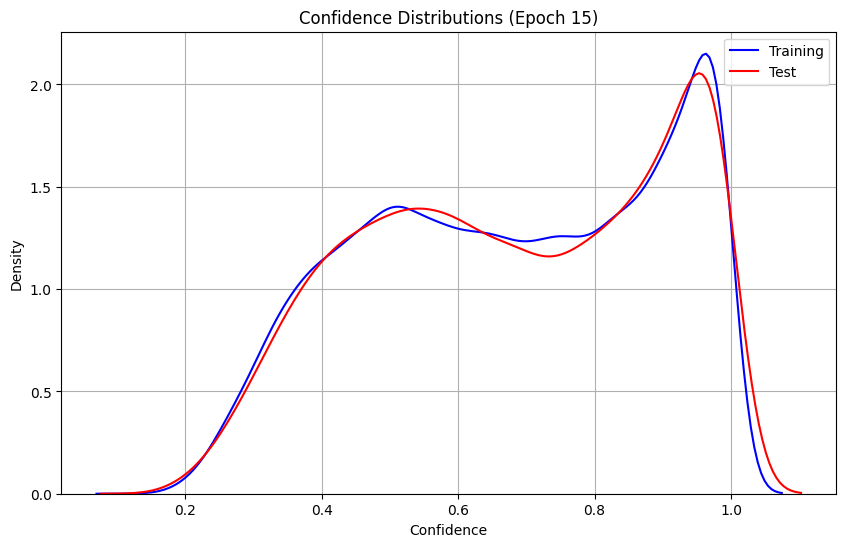

--------------------------------------------------
Epoch [216/400]
  Training: Loss: 0.7954, Accuracy: 72.61%, Confidence: 0.6780
  Testing:  Loss: 0.8702, Accuracy: 70.05%, Confidence: 0.6805
--------------------------------------------------
Epoch [217/400]
  Training: Loss: 0.7811, Accuracy: 73.23%, Confidence: 0.6818
  Testing:  Loss: 0.8517, Accuracy: 70.35%, Confidence: 0.6866
--------------------------------------------------
Epoch [218/400]
  Training: Loss: 0.7790, Accuracy: 73.17%, Confidence: 0.6809
  Testing:  Loss: 0.8431, Accuracy: 70.83%, Confidence: 0.6822
--------------------------------------------------
Epoch [219/400]
  Training: Loss: 0.7831, Accuracy: 72.93%, Confidence: 0.6800
  Testing:  Loss: 0.8451, Accuracy: 71.09%, Confidence: 0.6834
--------------------------------------------------
Epoch [220/400]
  Training: Loss: 0.7944, Accuracy: 72.71%, Confidence: 0.6773
  Testing:  Loss: 0.8756, Accuracy: 69.83%, Confidence: 0.6675
Model saved successfully to model_c

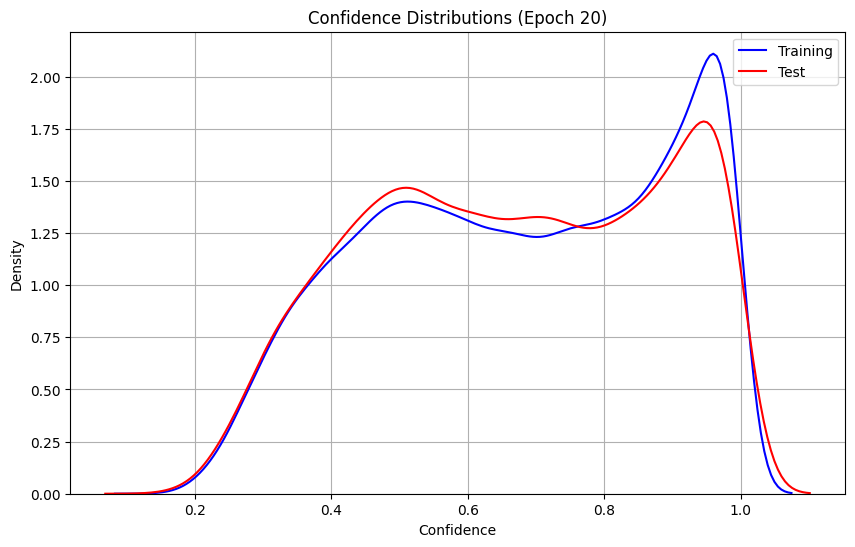

--------------------------------------------------
Epoch [221/400]
  Training: Loss: 0.7860, Accuracy: 73.06%, Confidence: 0.6754
  Testing:  Loss: 0.8506, Accuracy: 70.76%, Confidence: 0.6742
--------------------------------------------------
Epoch [222/400]
  Training: Loss: 0.7752, Accuracy: 73.31%, Confidence: 0.6815
  Testing:  Loss: 0.8530, Accuracy: 70.29%, Confidence: 0.6807
--------------------------------------------------
Epoch [223/400]
  Training: Loss: 0.7994, Accuracy: 72.52%, Confidence: 0.6744
  Testing:  Loss: 0.8582, Accuracy: 70.55%, Confidence: 0.6780
--------------------------------------------------
Epoch [224/400]
  Training: Loss: 0.7952, Accuracy: 72.78%, Confidence: 0.6753
  Testing:  Loss: 0.8669, Accuracy: 69.71%, Confidence: 0.6686
--------------------------------------------------
Epoch [225/400]
  Training: Loss: 0.7886, Accuracy: 73.01%, Confidence: 0.6781
  Testing:  Loss: 0.8567, Accuracy: 70.27%, Confidence: 0.6799
Stats: KS=0.0089(p=0.5270), MW=2487

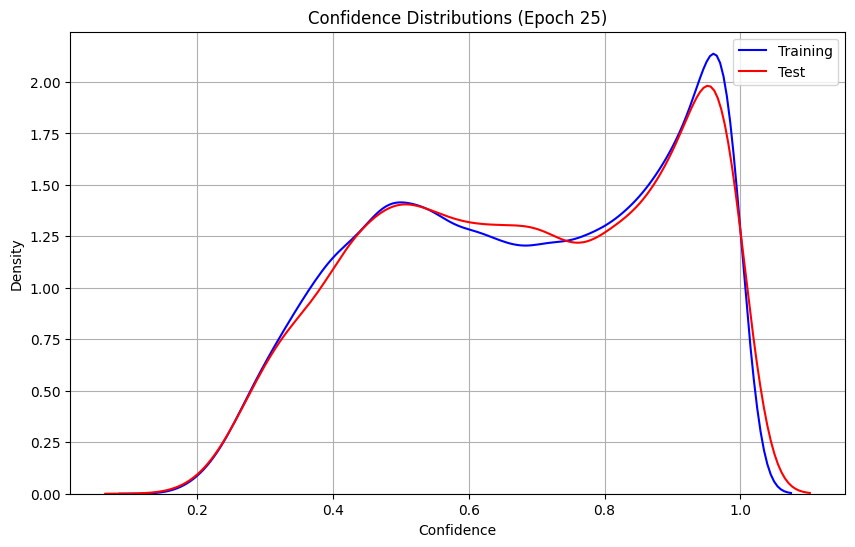

--------------------------------------------------
Epoch [226/400]
  Training: Loss: 0.7857, Accuracy: 72.95%, Confidence: 0.6768
  Testing:  Loss: 2.0306, Accuracy: 43.95%, Confidence: 0.6949
--------------------------------------------------
Epoch [227/400]
  Training: Loss: 0.7801, Accuracy: 73.36%, Confidence: 0.6798
  Testing:  Loss: 0.8563, Accuracy: 70.31%, Confidence: 0.6796
--------------------------------------------------
Epoch [228/400]
  Training: Loss: 0.7875, Accuracy: 73.18%, Confidence: 0.6755
  Testing:  Loss: 0.8504, Accuracy: 70.71%, Confidence: 0.6782
--------------------------------------------------
Epoch [229/400]
  Training: Loss: 0.7764, Accuracy: 73.52%, Confidence: 0.6791
  Testing:  Loss: 1.1853, Accuracy: 58.75%, Confidence: 0.6752
--------------------------------------------------
Epoch [230/400]
  Training: Loss: 0.7839, Accuracy: 73.26%, Confidence: 0.6782
  Testing:  Loss: 0.8366, Accuracy: 71.27%, Confidence: 0.6806
Stats: KS=0.0092(p=0.4725), MW=2484

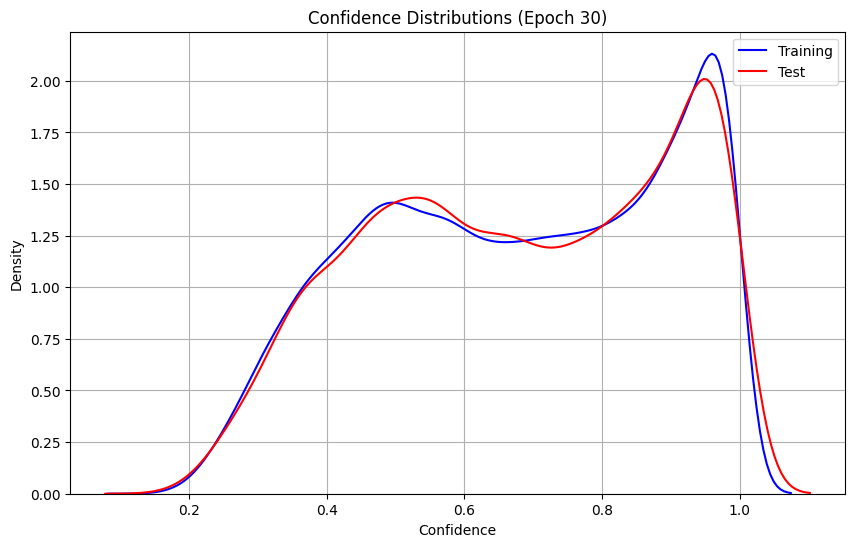

--------------------------------------------------
Epoch [231/400]
  Training: Loss: 0.7827, Accuracy: 73.24%, Confidence: 0.6787
  Testing:  Loss: 0.8773, Accuracy: 69.10%, Confidence: 0.6850
--------------------------------------------------
Epoch [232/400]
  Training: Loss: 0.7839, Accuracy: 73.17%, Confidence: 0.6787
  Testing:  Loss: 0.8414, Accuracy: 70.57%, Confidence: 0.6854
--------------------------------------------------
Epoch [233/400]
  Training: Loss: 0.7750, Accuracy: 73.51%, Confidence: 0.6809
  Testing:  Loss: 0.8763, Accuracy: 69.47%, Confidence: 0.6797
--------------------------------------------------
Epoch [234/400]
  Training: Loss: 0.7675, Accuracy: 73.81%, Confidence: 0.6840
  Testing:  Loss: 0.8631, Accuracy: 69.87%, Confidence: 0.6778
--------------------------------------------------
Epoch [235/400]
  Training: Loss: 0.7637, Accuracy: 73.72%, Confidence: 0.6864
  Testing:  Loss: 0.8293, Accuracy: 71.33%, Confidence: 0.6888
Stats: KS=0.0097(p=0.4157), MW=2481

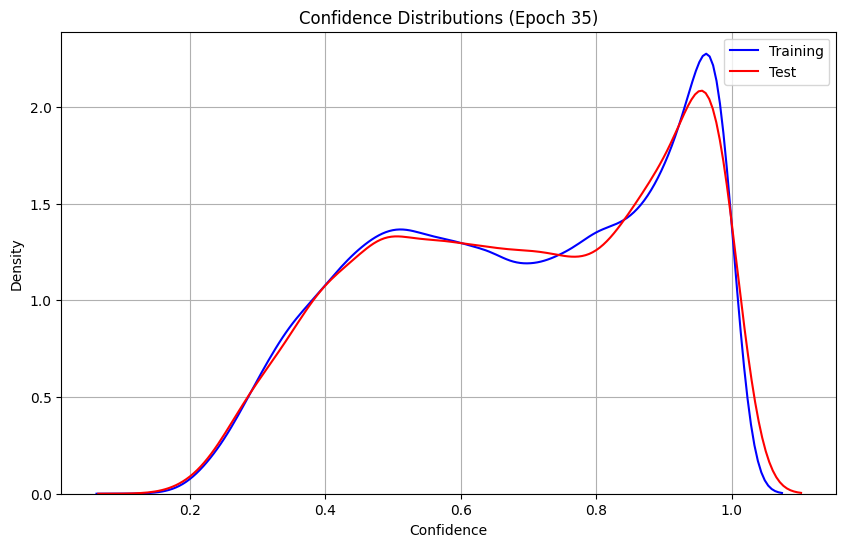

--------------------------------------------------
Epoch [236/400]
  Training: Loss: 0.7801, Accuracy: 73.26%, Confidence: 0.6853
  Testing:  Loss: 0.8600, Accuracy: 70.45%, Confidence: 0.6923
--------------------------------------------------
Epoch [237/400]
  Training: Loss: 0.7779, Accuracy: 73.42%, Confidence: 0.6838
  Testing:  Loss: 0.8484, Accuracy: 70.54%, Confidence: 0.6880
--------------------------------------------------
Epoch [238/400]
  Training: Loss: 0.7744, Accuracy: 73.33%, Confidence: 0.6850
  Testing:  Loss: 0.8580, Accuracy: 70.68%, Confidence: 0.6877
--------------------------------------------------
Epoch [239/400]
  Training: Loss: 0.7782, Accuracy: 73.48%, Confidence: 0.6826
  Testing:  Loss: 0.8432, Accuracy: 70.73%, Confidence: 0.6851
--------------------------------------------------
Epoch [240/400]
  Training: Loss: 0.7576, Accuracy: 74.07%, Confidence: 0.6884
  Testing:  Loss: 0.9211, Accuracy: 66.84%, Confidence: 0.6978
Model saved successfully to model_c

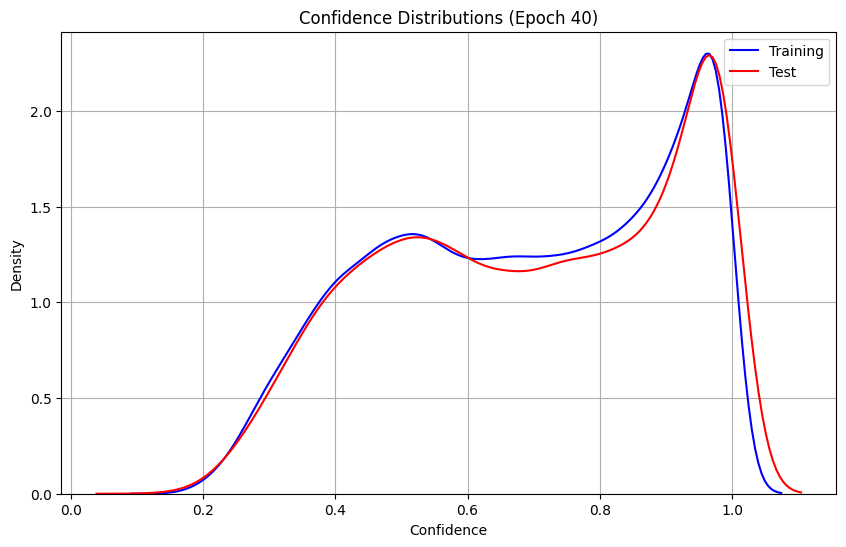

--------------------------------------------------
Epoch [241/400]
  Training: Loss: 0.7545, Accuracy: 74.32%, Confidence: 0.6916
  Testing:  Loss: 0.8209, Accuracy: 71.41%, Confidence: 0.6949
--------------------------------------------------
Epoch [242/400]
  Training: Loss: 0.7529, Accuracy: 74.33%, Confidence: 0.6915
  Testing:  Loss: 0.8310, Accuracy: 71.00%, Confidence: 0.6941
--------------------------------------------------
Epoch [243/400]
  Training: Loss: 0.7600, Accuracy: 73.74%, Confidence: 0.6894
  Testing:  Loss: 0.8450, Accuracy: 70.53%, Confidence: 0.6903
--------------------------------------------------
Epoch [244/400]
  Training: Loss: 0.7632, Accuracy: 73.93%, Confidence: 0.6889
  Testing:  Loss: 0.8216, Accuracy: 71.82%, Confidence: 0.6926
--------------------------------------------------
Epoch [245/400]
  Training: Loss: 0.7432, Accuracy: 74.66%, Confidence: 0.6943
  Testing:  Loss: 0.8578, Accuracy: 70.37%, Confidence: 0.6938
Stats: KS=0.0071(p=0.7921), MW=2500

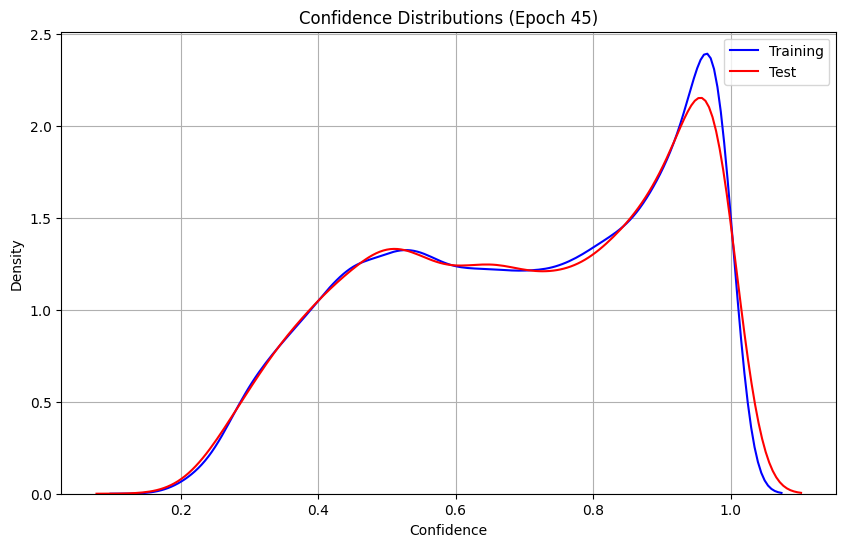

--------------------------------------------------
Epoch [246/400]
  Training: Loss: 0.7500, Accuracy: 74.39%, Confidence: 0.6900
  Testing:  Loss: 0.8281, Accuracy: 71.42%, Confidence: 0.6948
--------------------------------------------------
Epoch [247/400]
  Training: Loss: 0.7713, Accuracy: 73.39%, Confidence: 0.6852
  Testing:  Loss: 0.8578, Accuracy: 70.40%, Confidence: 0.6858
--------------------------------------------------
Epoch [248/400]
  Training: Loss: 0.7773, Accuracy: 73.39%, Confidence: 0.6842
  Testing:  Loss: 0.8836, Accuracy: 69.68%, Confidence: 0.6908
--------------------------------------------------
Epoch [249/400]
  Training: Loss: 0.7695, Accuracy: 73.64%, Confidence: 0.6871
  Testing:  Loss: 0.8357, Accuracy: 71.22%, Confidence: 0.6911
--------------------------------------------------
Epoch [250/400]
  Training: Loss: 0.7622, Accuracy: 73.86%, Confidence: 0.6885
  Testing:  Loss: 0.8341, Accuracy: 71.32%, Confidence: 0.6892
Stats: KS=0.0058(p=0.9435), MW=2497

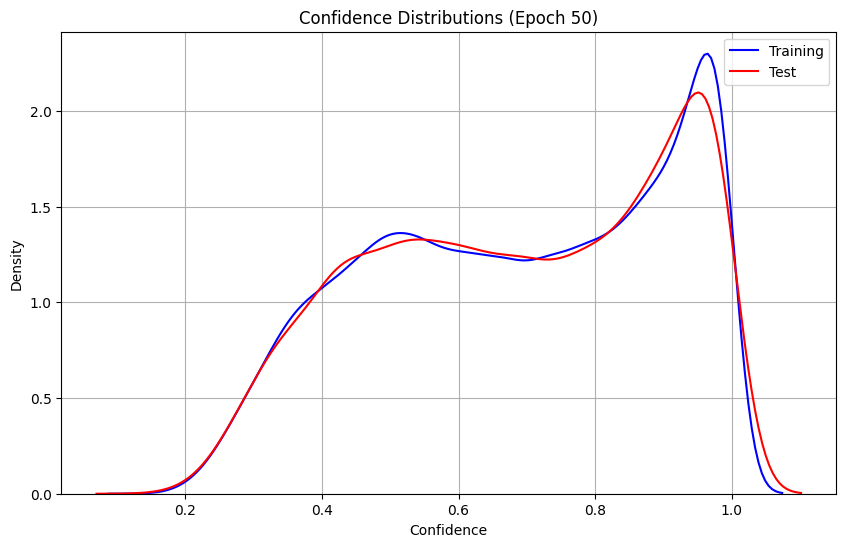

--------------------------------------------------
Epoch [251/400]
  Training: Loss: 0.7677, Accuracy: 73.63%, Confidence: 0.6844
  Testing:  Loss: 0.8592, Accuracy: 70.47%, Confidence: 0.6815
--------------------------------------------------
Epoch [252/400]
  Training: Loss: 0.7707, Accuracy: 73.52%, Confidence: 0.6845
  Testing:  Loss: 0.8682, Accuracy: 69.91%, Confidence: 0.6947
--------------------------------------------------
Epoch [253/400]
  Training: Loss: 0.7522, Accuracy: 74.33%, Confidence: 0.6910
  Testing:  Loss: 0.8328, Accuracy: 70.94%, Confidence: 0.6955
--------------------------------------------------
Epoch [254/400]
  Training: Loss: 0.7499, Accuracy: 74.31%, Confidence: 0.6920
  Testing:  Loss: 0.8392, Accuracy: 70.34%, Confidence: 0.6933
--------------------------------------------------
Epoch [255/400]
  Training: Loss: 0.7503, Accuracy: 74.28%, Confidence: 0.6916
  Testing:  Loss: 0.8314, Accuracy: 71.57%, Confidence: 0.6945
Stats: KS=0.0105(p=0.3150), MW=2479

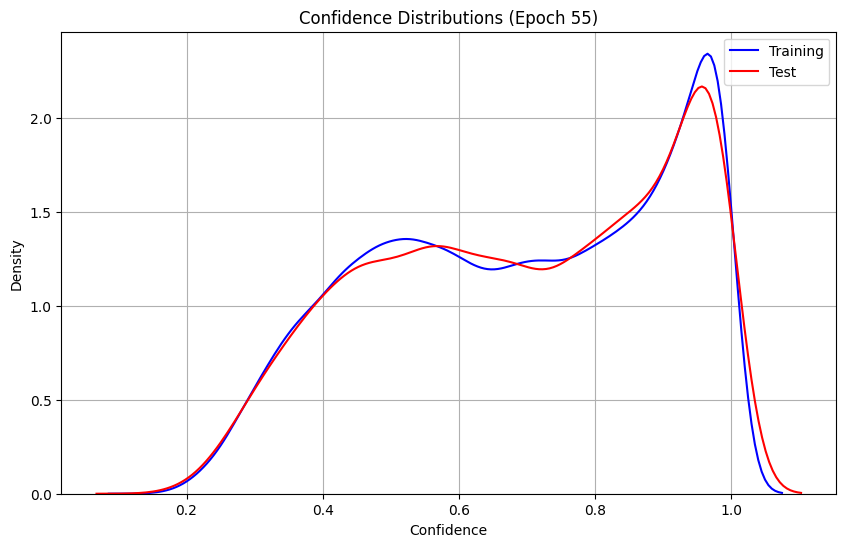

--------------------------------------------------
Epoch [256/400]
  Training: Loss: 0.7717, Accuracy: 73.49%, Confidence: 0.6867
  Testing:  Loss: 0.8407, Accuracy: 71.22%, Confidence: 0.6880
--------------------------------------------------
Epoch [257/400]
  Training: Loss: 0.7709, Accuracy: 73.49%, Confidence: 0.6846
  Testing:  Loss: 0.8333, Accuracy: 70.79%, Confidence: 0.6856
--------------------------------------------------
Epoch [258/400]
  Training: Loss: 0.7875, Accuracy: 72.75%, Confidence: 0.6820
  Testing:  Loss: 0.8841, Accuracy: 68.98%, Confidence: 0.6900
--------------------------------------------------
Epoch [259/400]
  Training: Loss: 0.7790, Accuracy: 73.07%, Confidence: 0.6836
  Testing:  Loss: 0.8670, Accuracy: 69.95%, Confidence: 0.6840
--------------------------------------------------
Epoch [260/400]
  Training: Loss: 0.7809, Accuracy: 72.94%, Confidence: 0.6850
  Testing:  Loss: 0.8787, Accuracy: 69.67%, Confidence: 0.6765
Model saved successfully to model_c

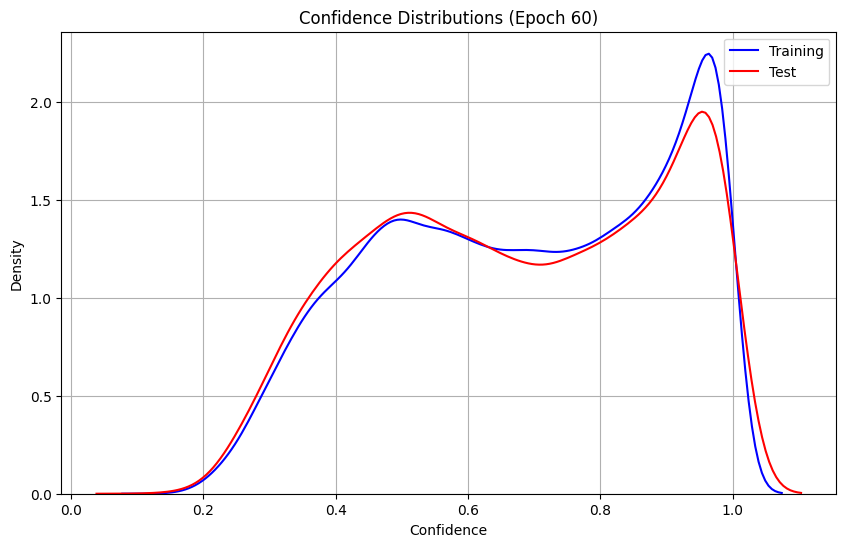

--------------------------------------------------
Epoch [261/400]
  Training: Loss: 0.7983, Accuracy: 72.62%, Confidence: 0.6788
  Testing:  Loss: 0.8409, Accuracy: 70.81%, Confidence: 0.6795
--------------------------------------------------
Epoch [262/400]
  Training: Loss: 0.7703, Accuracy: 73.51%, Confidence: 0.6848
  Testing:  Loss: 0.8669, Accuracy: 70.17%, Confidence: 0.6856
--------------------------------------------------
Epoch [263/400]
  Training: Loss: 0.7791, Accuracy: 73.09%, Confidence: 0.6829
  Testing:  Loss: 0.9760, Accuracy: 65.94%, Confidence: 0.6568
--------------------------------------------------
Epoch [264/400]
  Training: Loss: 0.7814, Accuracy: 73.09%, Confidence: 0.6835
  Testing:  Loss: 0.8859, Accuracy: 69.15%, Confidence: 0.6889
--------------------------------------------------
Epoch [265/400]
  Training: Loss: 0.7624, Accuracy: 73.92%, Confidence: 0.6881
  Testing:  Loss: 0.8397, Accuracy: 71.37%, Confidence: 0.6921
Stats: KS=0.0100(p=0.3679), MW=2473

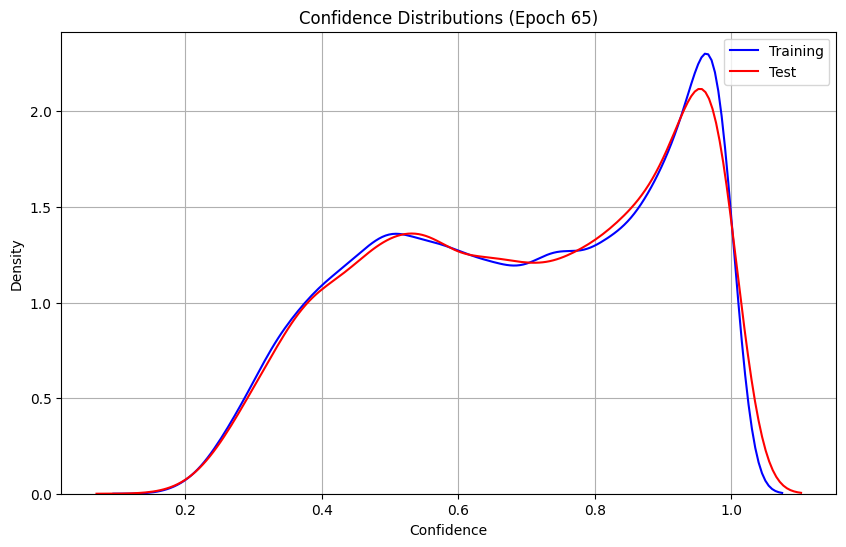

--------------------------------------------------
Epoch [266/400]
  Training: Loss: 0.7525, Accuracy: 74.06%, Confidence: 0.6936
  Testing:  Loss: 0.8274, Accuracy: 71.57%, Confidence: 0.6941
--------------------------------------------------
Epoch [267/400]
  Training: Loss: 0.7469, Accuracy: 74.56%, Confidence: 0.6942
  Testing:  Loss: 0.8169, Accuracy: 71.67%, Confidence: 0.6981
--------------------------------------------------
Epoch [268/400]
  Training: Loss: 0.7477, Accuracy: 74.46%, Confidence: 0.6936
  Testing:  Loss: 0.8214, Accuracy: 71.37%, Confidence: 0.6898
--------------------------------------------------
Epoch [269/400]
  Training: Loss: 0.7365, Accuracy: 74.65%, Confidence: 0.6955
  Testing:  Loss: 0.8283, Accuracy: 71.23%, Confidence: 0.6933
--------------------------------------------------
Epoch [270/400]
  Training: Loss: 0.7534, Accuracy: 73.98%, Confidence: 0.6929
  Testing:  Loss: 0.9418, Accuracy: 67.08%, Confidence: 0.6822
Stats: KS=0.0287(p=0.0000), MW=2568

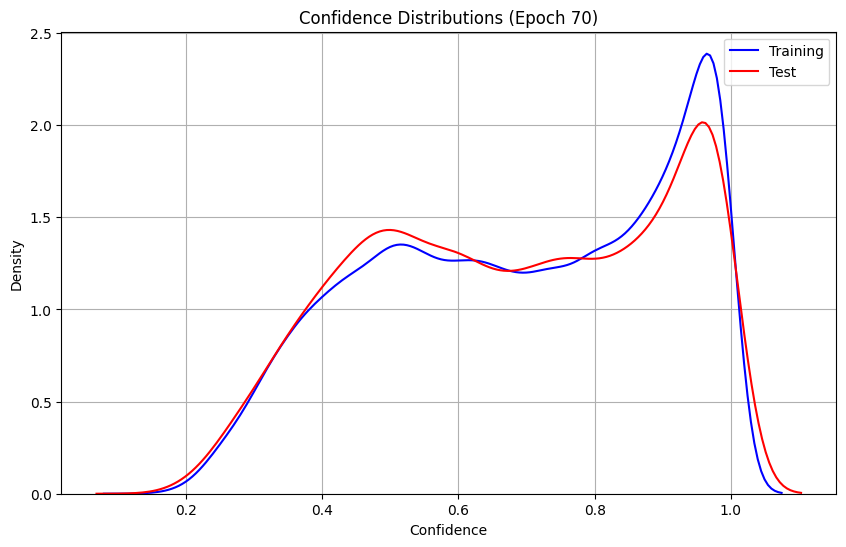

--------------------------------------------------
Epoch [271/400]
  Training: Loss: 0.7463, Accuracy: 74.33%, Confidence: 0.6937
  Testing:  Loss: 0.8286, Accuracy: 71.11%, Confidence: 0.6899
--------------------------------------------------
Epoch [272/400]
  Training: Loss: 0.7663, Accuracy: 73.91%, Confidence: 0.6885
  Testing:  Loss: 0.8472, Accuracy: 70.25%, Confidence: 0.6891
--------------------------------------------------
Epoch [273/400]
  Training: Loss: 0.7650, Accuracy: 74.04%, Confidence: 0.6859
  Testing:  Loss: 0.8440, Accuracy: 70.47%, Confidence: 0.6911
--------------------------------------------------
Epoch [274/400]
  Training: Loss: 0.7561, Accuracy: 73.89%, Confidence: 0.6905
  Testing:  Loss: 0.9907, Accuracy: 65.47%, Confidence: 0.6737
--------------------------------------------------
Epoch [275/400]
  Training: Loss: 0.8060, Accuracy: 72.26%, Confidence: 0.6776
  Testing:  Loss: 0.9442, Accuracy: 66.81%, Confidence: 0.6574
Stats: KS=0.0481(p=0.0000), MW=2635

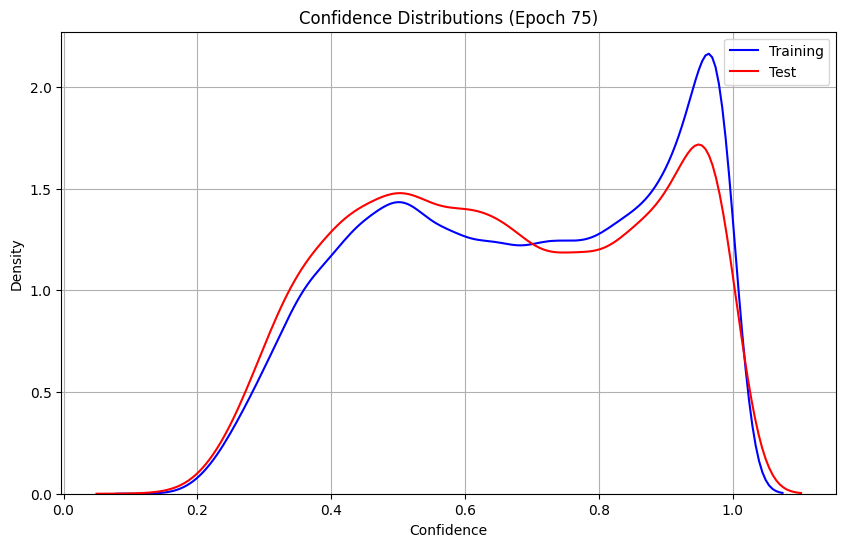

--------------------------------------------------
Epoch [276/400]
  Training: Loss: 0.7891, Accuracy: 72.89%, Confidence: 0.6826
  Testing:  Loss: 0.8466, Accuracy: 70.37%, Confidence: 0.6916
--------------------------------------------------
Epoch [277/400]
  Training: Loss: 0.7623, Accuracy: 73.61%, Confidence: 0.6883
  Testing:  Loss: 0.8442, Accuracy: 70.69%, Confidence: 0.6926
--------------------------------------------------
Epoch [278/400]
  Training: Loss: 0.7761, Accuracy: 73.38%, Confidence: 0.6838
  Testing:  Loss: 0.8677, Accuracy: 70.12%, Confidence: 0.6886
--------------------------------------------------
Epoch [279/400]
  Training: Loss: 0.7603, Accuracy: 73.75%, Confidence: 0.6888
  Testing:  Loss: 0.8316, Accuracy: 71.17%, Confidence: 0.6936
--------------------------------------------------
Epoch [280/400]
  Training: Loss: 0.7538, Accuracy: 74.08%, Confidence: 0.6904
  Testing:  Loss: 0.8629, Accuracy: 69.89%, Confidence: 0.6914
Model saved successfully to model_c

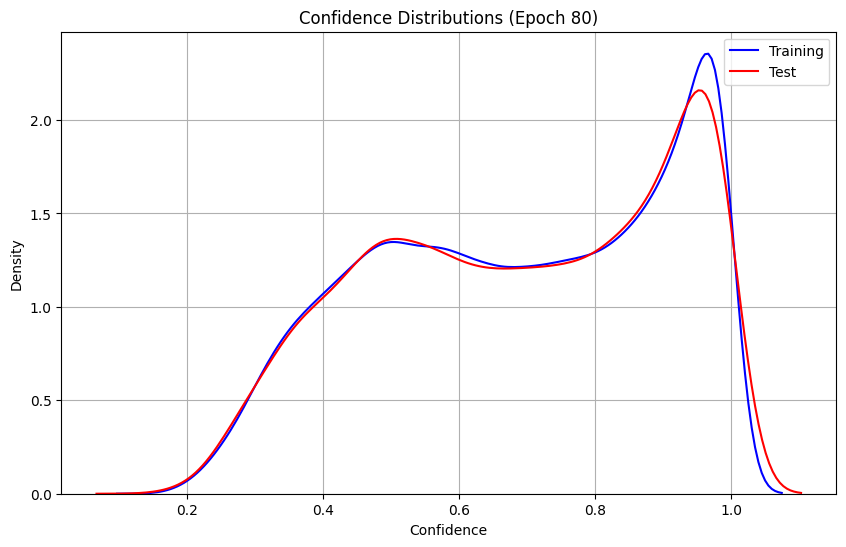

--------------------------------------------------
Epoch [281/400]
  Training: Loss: 0.7539, Accuracy: 74.17%, Confidence: 0.6906
  Testing:  Loss: 0.9344, Accuracy: 67.03%, Confidence: 0.6724
--------------------------------------------------
Epoch [282/400]
  Training: Loss: 0.7650, Accuracy: 73.66%, Confidence: 0.6885
  Testing:  Loss: 0.8516, Accuracy: 70.50%, Confidence: 0.6881
--------------------------------------------------
Epoch [283/400]
  Training: Loss: 0.7767, Accuracy: 73.39%, Confidence: 0.6858
  Testing:  Loss: 0.9384, Accuracy: 67.27%, Confidence: 0.6956
--------------------------------------------------
Epoch [284/400]
  Training: Loss: 0.7527, Accuracy: 74.33%, Confidence: 0.6914
  Testing:  Loss: 0.8545, Accuracy: 70.20%, Confidence: 0.6822
--------------------------------------------------
Epoch [285/400]
  Training: Loss: 0.7688, Accuracy: 73.41%, Confidence: 0.6937
  Testing:  Loss: 0.8500, Accuracy: 70.79%, Confidence: 0.7005
Stats: KS=0.0169(p=0.0169), MW=2450

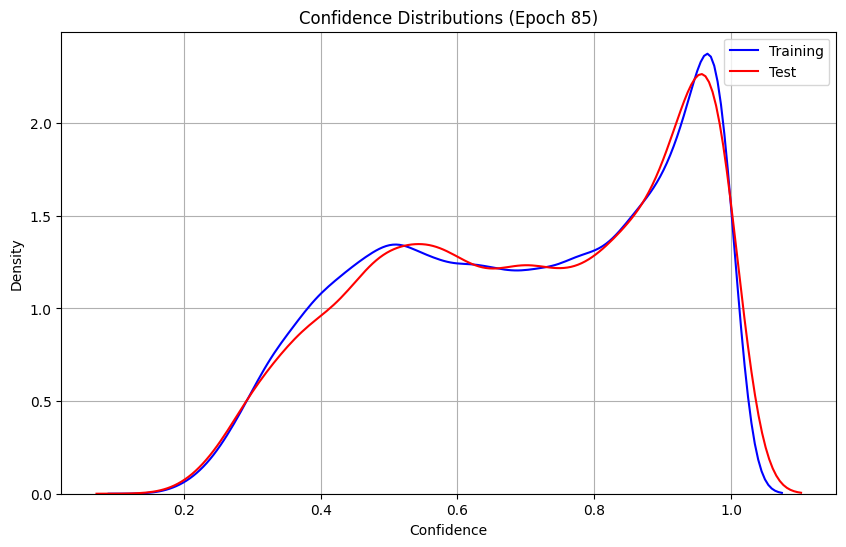

--------------------------------------------------
Epoch [286/400]
  Training: Loss: 0.7567, Accuracy: 74.00%, Confidence: 0.6958
  Testing:  Loss: 0.8382, Accuracy: 70.77%, Confidence: 0.7013
--------------------------------------------------
Epoch [287/400]
  Training: Loss: 0.7667, Accuracy: 73.55%, Confidence: 0.6914
  Testing:  Loss: 0.8954, Accuracy: 68.36%, Confidence: 0.6911
--------------------------------------------------
Epoch [288/400]
  Training: Loss: 0.7713, Accuracy: 73.42%, Confidence: 0.6899
  Testing:  Loss: 0.8746, Accuracy: 69.53%, Confidence: 0.6791
--------------------------------------------------
Epoch [289/400]
  Training: Loss: 0.7555, Accuracy: 73.81%, Confidence: 0.6936
  Testing:  Loss: 0.8252, Accuracy: 71.14%, Confidence: 0.6980
--------------------------------------------------
Epoch [290/400]
  Training: Loss: 0.7669, Accuracy: 73.52%, Confidence: 0.6898
  Testing:  Loss: 0.8793, Accuracy: 68.99%, Confidence: 0.6760
Stats: KS=0.0286(p=0.0000), MW=2590

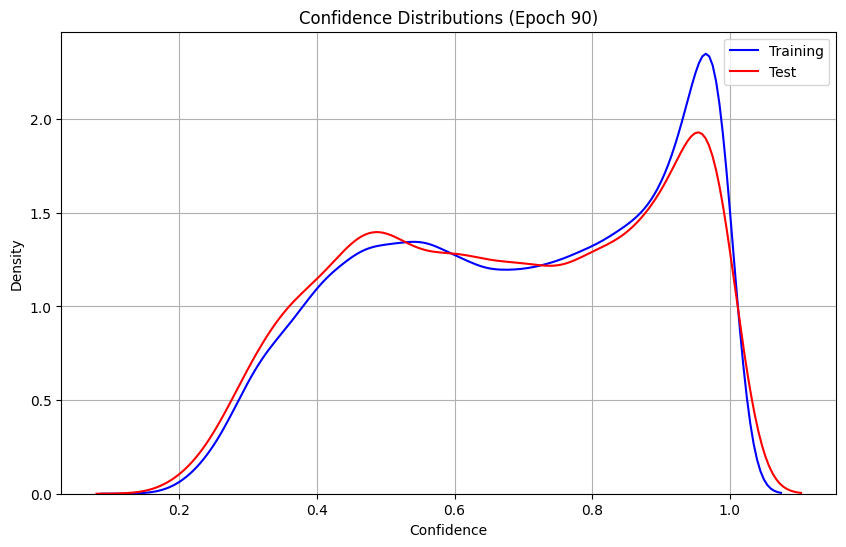

--------------------------------------------------
Epoch [291/400]
  Training: Loss: 0.7600, Accuracy: 73.97%, Confidence: 0.6896
  Testing:  Loss: 0.8518, Accuracy: 70.32%, Confidence: 0.6905
--------------------------------------------------
Epoch [292/400]
  Training: Loss: 0.7550, Accuracy: 73.97%, Confidence: 0.6939
  Testing:  Loss: 0.8371, Accuracy: 71.07%, Confidence: 0.6968
--------------------------------------------------
Epoch [293/400]
  Training: Loss: 0.7404, Accuracy: 74.61%, Confidence: 0.6981
  Testing:  Loss: 0.8129, Accuracy: 71.72%, Confidence: 0.7038
--------------------------------------------------
Epoch [294/400]
  Training: Loss: 0.7256, Accuracy: 75.17%, Confidence: 0.7016
  Testing:  Loss: 0.8046, Accuracy: 72.23%, Confidence: 0.7053
--------------------------------------------------
Epoch [295/400]
  Training: Loss: 0.7365, Accuracy: 74.80%, Confidence: 0.6997
  Testing:  Loss: 0.8542, Accuracy: 70.33%, Confidence: 0.6964
Stats: KS=0.0139(p=0.0806), MW=2528

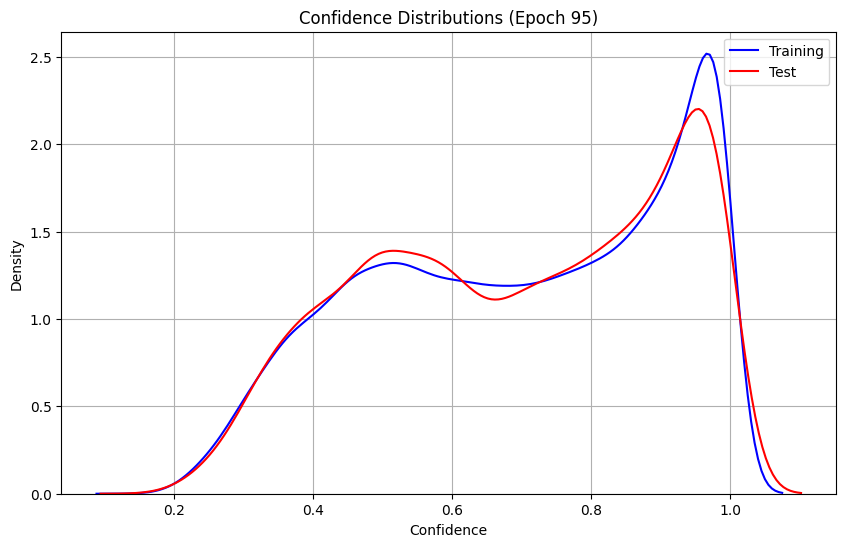

--------------------------------------------------
Epoch [296/400]
  Training: Loss: 0.7615, Accuracy: 73.72%, Confidence: 0.6907
  Testing:  Loss: 0.8379, Accuracy: 70.94%, Confidence: 0.7063
--------------------------------------------------
Epoch [297/400]
  Training: Loss: 0.7313, Accuracy: 74.89%, Confidence: 0.7010
  Testing:  Loss: 0.8221, Accuracy: 71.78%, Confidence: 0.6948
--------------------------------------------------
Epoch [298/400]
  Training: Loss: 0.7386, Accuracy: 74.54%, Confidence: 0.6983
  Testing:  Loss: 0.8262, Accuracy: 71.18%, Confidence: 0.7021
--------------------------------------------------
Epoch [299/400]
  Training: Loss: 0.7228, Accuracy: 75.26%, Confidence: 0.7035
  Testing:  Loss: 0.8157, Accuracy: 72.15%, Confidence: 0.7052
--------------------------------------------------
Epoch [300/400]
  Training: Loss: 0.7679, Accuracy: 73.53%, Confidence: 0.6938
  Testing:  Loss: 0.8855, Accuracy: 69.40%, Confidence: 0.6840
Model saved successfully to model_c

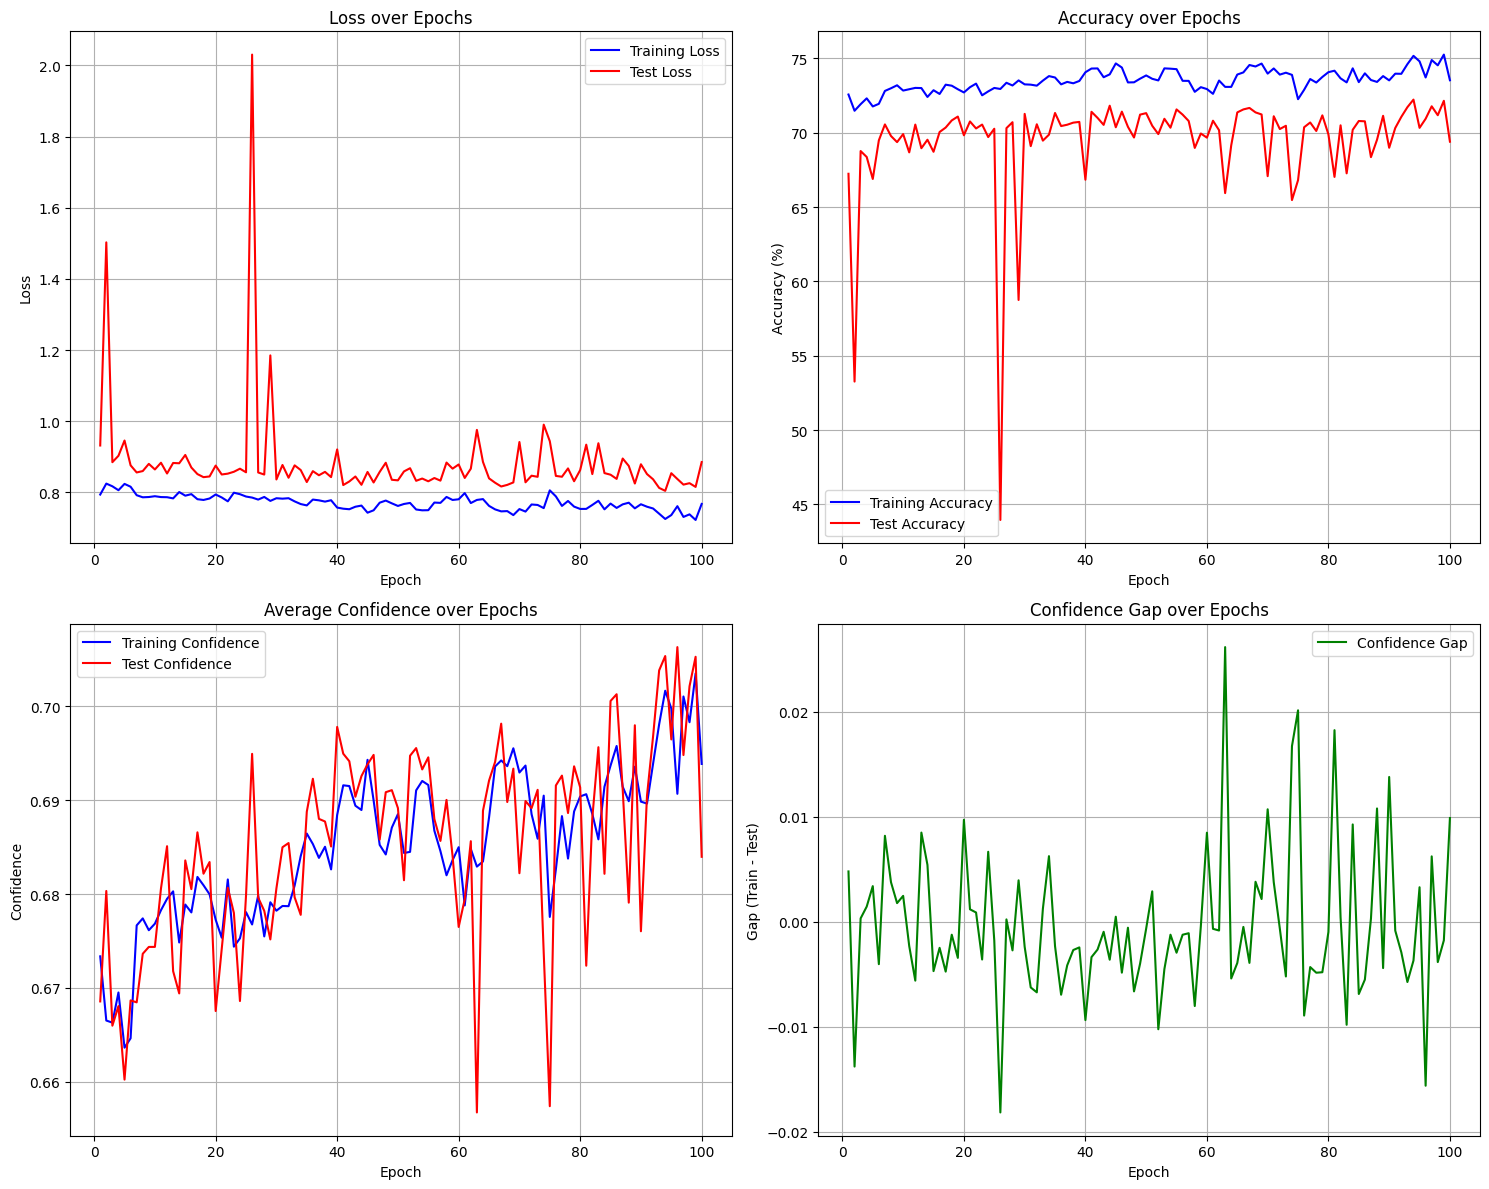

Saved plots for epochs 201-300
--------------------------------------------------
Epoch [301/400]
  Training: Loss: 0.7736, Accuracy: 73.45%, Confidence: 0.6863
  Testing:  Loss: 0.8566, Accuracy: 70.16%, Confidence: 0.7018
--------------------------------------------------
Epoch [302/400]
  Training: Loss: 0.7407, Accuracy: 74.49%, Confidence: 0.6976
  Testing:  Loss: 0.8274, Accuracy: 70.72%, Confidence: 0.7050
--------------------------------------------------
Epoch [303/400]
  Training: Loss: 0.7624, Accuracy: 73.90%, Confidence: 0.6900
  Testing:  Loss: 0.9491, Accuracy: 66.35%, Confidence: 0.6924
--------------------------------------------------
Epoch [304/400]
  Training: Loss: 0.7672, Accuracy: 73.69%, Confidence: 0.6929
  Testing:  Loss: 4.8904, Accuracy: 34.82%, Confidence: 0.7974
--------------------------------------------------
Epoch [305/400]
  Training: Loss: 0.7914, Accuracy: 72.69%, Confidence: 0.6877
  Testing:  Loss: 0.8415, Accuracy: 71.15%, Confidence: 0.6935
Stat

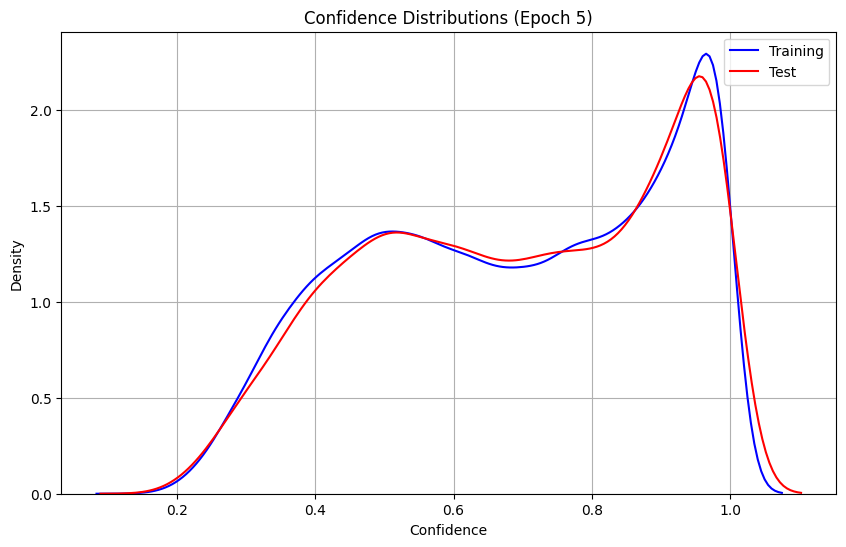

--------------------------------------------------
Epoch [306/400]
  Training: Loss: 0.7641, Accuracy: 73.87%, Confidence: 0.6930
  Testing:  Loss: 0.8481, Accuracy: 70.61%, Confidence: 0.6981
--------------------------------------------------
Epoch [307/400]
  Training: Loss: 0.7519, Accuracy: 74.18%, Confidence: 0.6943
  Testing:  Loss: 0.8328, Accuracy: 70.91%, Confidence: 0.7005
--------------------------------------------------
Epoch [308/400]
  Training: Loss: 0.7531, Accuracy: 74.07%, Confidence: 0.6945
  Testing:  Loss: 0.8516, Accuracy: 70.40%, Confidence: 0.6986
--------------------------------------------------
Epoch [309/400]
  Training: Loss: 0.7479, Accuracy: 74.43%, Confidence: 0.6958
  Testing:  Loss: 47.5875, Accuracy: 13.48%, Confidence: 0.9468
--------------------------------------------------
Epoch [310/400]
  Training: Loss: 0.7583, Accuracy: 73.93%, Confidence: 0.6951
  Testing:  Loss: 0.8737, Accuracy: 69.68%, Confidence: 0.6859
Stats: KS=0.0274(p=0.0000), MW=256

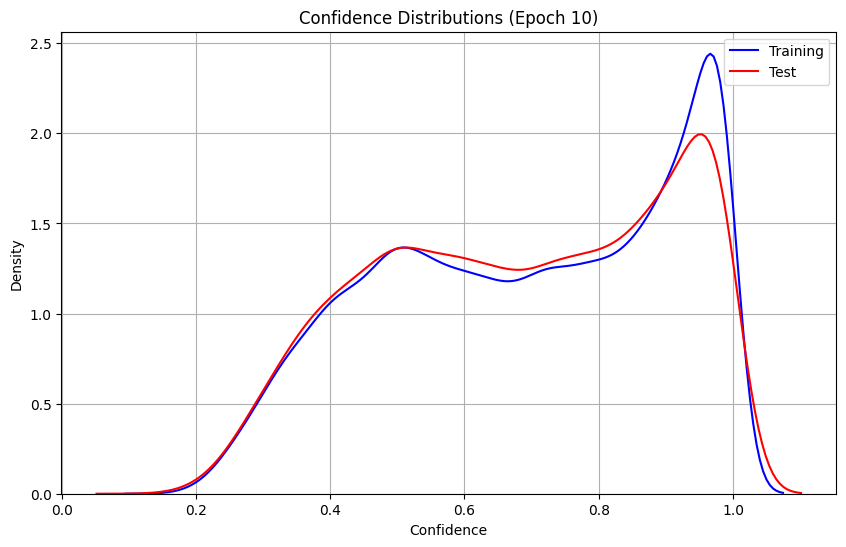

--------------------------------------------------
Epoch [311/400]
  Training: Loss: 0.7664, Accuracy: 73.53%, Confidence: 0.6910
  Testing:  Loss: 0.8272, Accuracy: 71.64%, Confidence: 0.6997
--------------------------------------------------
Epoch [312/400]
  Training: Loss: 0.7954, Accuracy: 72.65%, Confidence: 0.6828
  Testing:  Loss: 0.8788, Accuracy: 69.43%, Confidence: 0.6938
--------------------------------------------------
Epoch [313/400]
  Training: Loss: 0.7826, Accuracy: 72.85%, Confidence: 0.6840
  Testing:  Loss: 1.3580, Accuracy: 54.36%, Confidence: 0.6608
--------------------------------------------------
Epoch [314/400]
  Training: Loss: 0.7754, Accuracy: 73.37%, Confidence: 0.6850
  Testing:  Loss: 0.8570, Accuracy: 70.18%, Confidence: 0.6930
--------------------------------------------------
Epoch [315/400]
  Training: Loss: 0.7605, Accuracy: 73.99%, Confidence: 0.6908
  Testing:  Loss: 0.8555, Accuracy: 70.19%, Confidence: 0.6944
Stats: KS=0.0173(p=0.0136), MW=2469

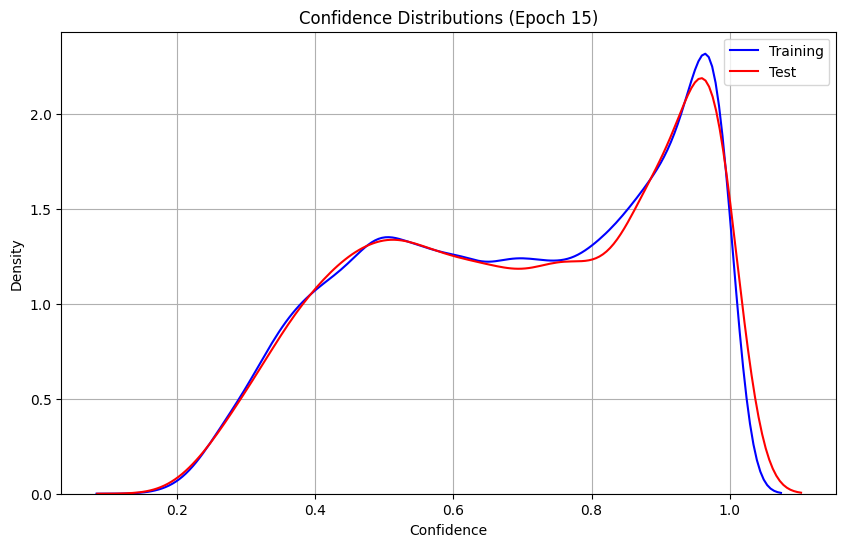

--------------------------------------------------
Epoch [316/400]
  Training: Loss: 0.7461, Accuracy: 74.48%, Confidence: 0.6929
  Testing:  Loss: 0.8162, Accuracy: 71.83%, Confidence: 0.6937
--------------------------------------------------
Epoch [317/400]
  Training: Loss: 0.7570, Accuracy: 73.84%, Confidence: 0.6909
  Testing:  Loss: 0.9697, Accuracy: 65.79%, Confidence: 0.6945
--------------------------------------------------
Epoch [318/400]
  Training: Loss: 0.7418, Accuracy: 74.64%, Confidence: 0.6947
  Testing:  Loss: 0.8802, Accuracy: 69.02%, Confidence: 0.6838
--------------------------------------------------
Epoch [319/400]
  Training: Loss: 0.7459, Accuracy: 74.53%, Confidence: 0.6945
  Testing:  Loss: 0.8892, Accuracy: 68.97%, Confidence: 0.6863
--------------------------------------------------
Epoch [320/400]
  Training: Loss: 0.7423, Accuracy: 74.47%, Confidence: 0.6967
  Testing:  Loss: 0.8534, Accuracy: 70.54%, Confidence: 0.7055
Model saved successfully to model_c

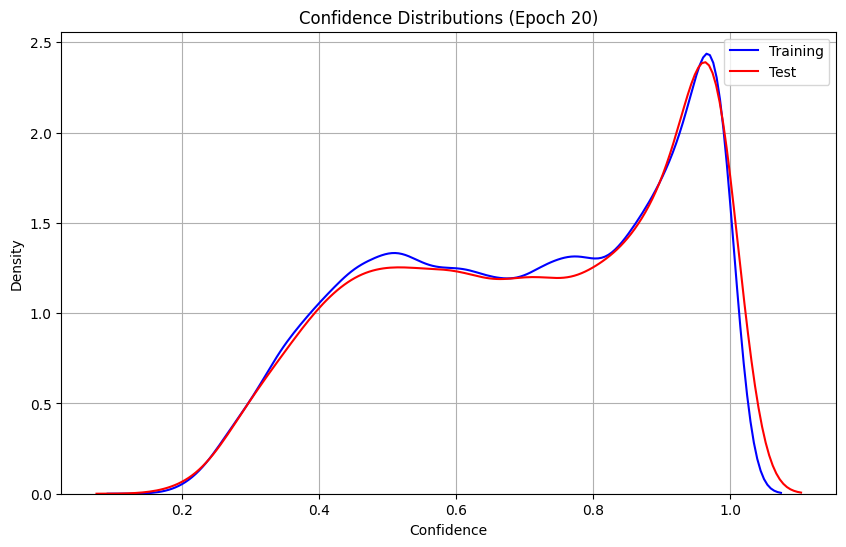

--------------------------------------------------
Epoch [321/400]
  Training: Loss: 0.7432, Accuracy: 74.46%, Confidence: 0.6949
  Testing:  Loss: 0.8530, Accuracy: 70.13%, Confidence: 0.7022
--------------------------------------------------
Epoch [322/400]
  Training: Loss: 0.7392, Accuracy: 74.72%, Confidence: 0.6955
  Testing:  Loss: 0.8669, Accuracy: 69.22%, Confidence: 0.7042
--------------------------------------------------
Epoch [323/400]
  Training: Loss: 0.7343, Accuracy: 75.07%, Confidence: 0.6979
  Testing:  Loss: 0.8932, Accuracy: 68.55%, Confidence: 0.6976
--------------------------------------------------
Epoch [324/400]
  Training: Loss: 0.7448, Accuracy: 74.51%, Confidence: 0.6946
  Testing:  Loss: 0.8053, Accuracy: 71.98%, Confidence: 0.7042
--------------------------------------------------
Epoch [325/400]
  Training: Loss: 0.7478, Accuracy: 74.46%, Confidence: 0.6959
  Testing:  Loss: 0.8655, Accuracy: 69.90%, Confidence: 0.6937
Stats: KS=0.0085(p=0.5777), MW=2514

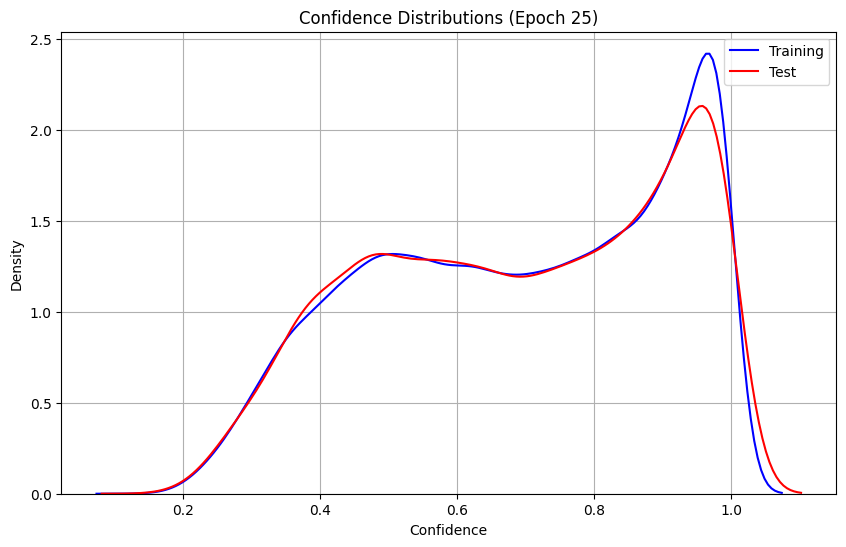

--------------------------------------------------
Epoch [326/400]
  Training: Loss: 0.7285, Accuracy: 75.07%, Confidence: 0.6993
  Testing:  Loss: 0.9286, Accuracy: 68.10%, Confidence: 0.6681
--------------------------------------------------
Epoch [327/400]
  Training: Loss: 0.7297, Accuracy: 75.10%, Confidence: 0.6996
  Testing:  Loss: 0.8164, Accuracy: 71.95%, Confidence: 0.7044
--------------------------------------------------
Epoch [328/400]
  Training: Loss: 0.7338, Accuracy: 74.88%, Confidence: 0.6992
  Testing:  Loss: 0.8213, Accuracy: 71.24%, Confidence: 0.7096
--------------------------------------------------
Epoch [329/400]
  Training: Loss: 0.7218, Accuracy: 75.22%, Confidence: 0.7021
  Testing:  Loss: 0.8126, Accuracy: 72.03%, Confidence: 0.7128
--------------------------------------------------
Epoch [330/400]
  Training: Loss: 0.7127, Accuracy: 75.56%, Confidence: 0.7047
  Testing:  Loss: 0.8055, Accuracy: 72.14%, Confidence: 0.7088
Stats: KS=0.0091(p=0.4866), MW=2473

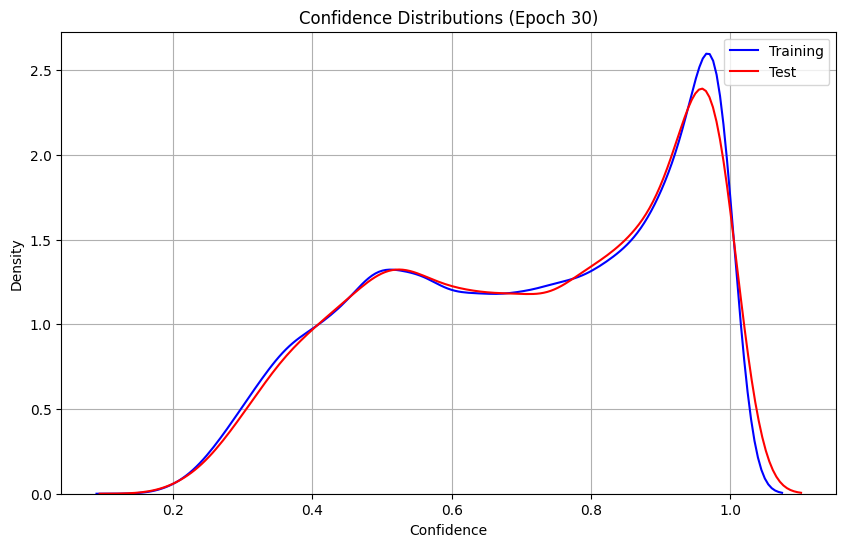

--------------------------------------------------
Epoch [331/400]
  Training: Loss: 0.7426, Accuracy: 74.67%, Confidence: 0.7020
  Testing:  Loss: 0.8260, Accuracy: 71.04%, Confidence: 0.6977
--------------------------------------------------
Epoch [332/400]
  Training: Loss: 0.7332, Accuracy: 74.78%, Confidence: 0.7025
  Testing:  Loss: 0.8168, Accuracy: 71.78%, Confidence: 0.7033
--------------------------------------------------
Epoch [333/400]
  Training: Loss: 0.7244, Accuracy: 75.31%, Confidence: 0.7042
  Testing:  Loss: 0.8214, Accuracy: 71.63%, Confidence: 0.7057
--------------------------------------------------
Epoch [334/400]
  Training: Loss: 0.7190, Accuracy: 75.35%, Confidence: 0.7055
  Testing:  Loss: 0.8502, Accuracy: 70.68%, Confidence: 0.7096
--------------------------------------------------
Epoch [335/400]
  Training: Loss: 0.7399, Accuracy: 74.72%, Confidence: 0.7011
  Testing:  Loss: 0.8199, Accuracy: 71.64%, Confidence: 0.7044
Stats: KS=0.0112(p=0.2468), MW=2480

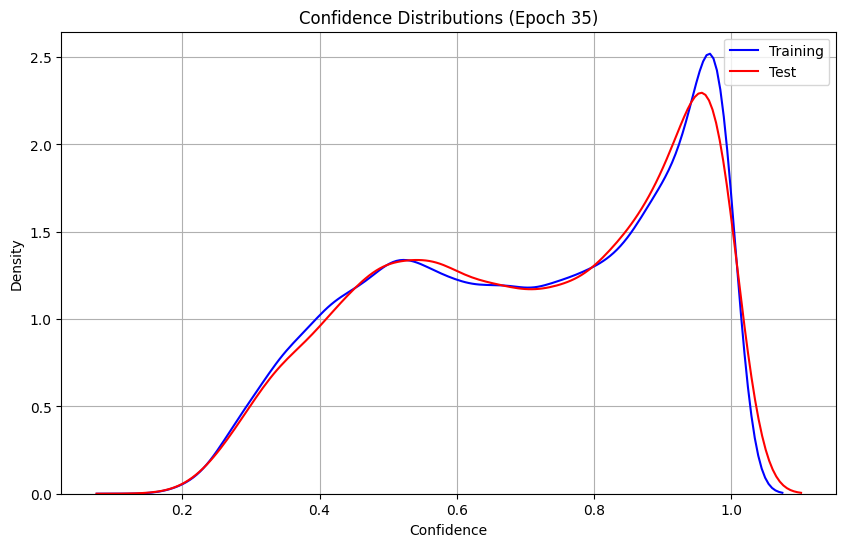

--------------------------------------------------
Epoch [336/400]
  Training: Loss: 0.7509, Accuracy: 74.39%, Confidence: 0.6966
  Testing:  Loss: 0.8827, Accuracy: 69.64%, Confidence: 0.6802
--------------------------------------------------
Epoch [337/400]
  Training: Loss: 0.7465, Accuracy: 74.33%, Confidence: 0.6987
  Testing:  Loss: 0.8167, Accuracy: 71.72%, Confidence: 0.7065
--------------------------------------------------
Epoch [338/400]
  Training: Loss: 0.7184, Accuracy: 75.09%, Confidence: 0.7059
  Testing:  Loss: 0.8194, Accuracy: 71.80%, Confidence: 0.7040
--------------------------------------------------
Epoch [339/400]
  Training: Loss: 0.7193, Accuracy: 75.32%, Confidence: 0.7045
  Testing:  Loss: 0.8066, Accuracy: 71.79%, Confidence: 0.7014
--------------------------------------------------
Epoch [340/400]
  Training: Loss: 0.7219, Accuracy: 75.34%, Confidence: 0.7029
  Testing:  Loss: 0.8453, Accuracy: 70.79%, Confidence: 0.7023
Model saved successfully to model_c

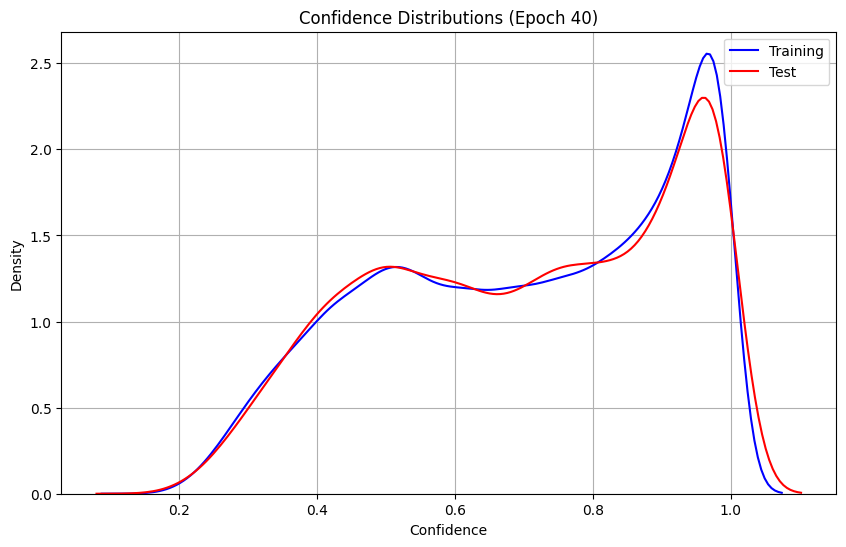

--------------------------------------------------
Epoch [341/400]
  Training: Loss: 0.7263, Accuracy: 75.00%, Confidence: 0.7036
  Testing:  Loss: 0.8146, Accuracy: 71.79%, Confidence: 0.7083
--------------------------------------------------
Epoch [342/400]
  Training: Loss: 0.7483, Accuracy: 74.40%, Confidence: 0.6978
  Testing:  Loss: 0.8167, Accuracy: 71.93%, Confidence: 0.7003
--------------------------------------------------
Epoch [343/400]
  Training: Loss: 0.7139, Accuracy: 75.52%, Confidence: 0.7066
  Testing:  Loss: 0.8592, Accuracy: 70.51%, Confidence: 0.7194
--------------------------------------------------
Epoch [344/400]
  Training: Loss: 0.7108, Accuracy: 75.47%, Confidence: 0.7086
  Testing:  Loss: 0.8259, Accuracy: 71.53%, Confidence: 0.7033
--------------------------------------------------
Epoch [345/400]
  Training: Loss: 0.7090, Accuracy: 75.79%, Confidence: 0.7072
  Testing:  Loss: 4.1164, Accuracy: 28.39%, Confidence: 0.8056
Stats: KS=0.1860(p=0.0000), MW=1792

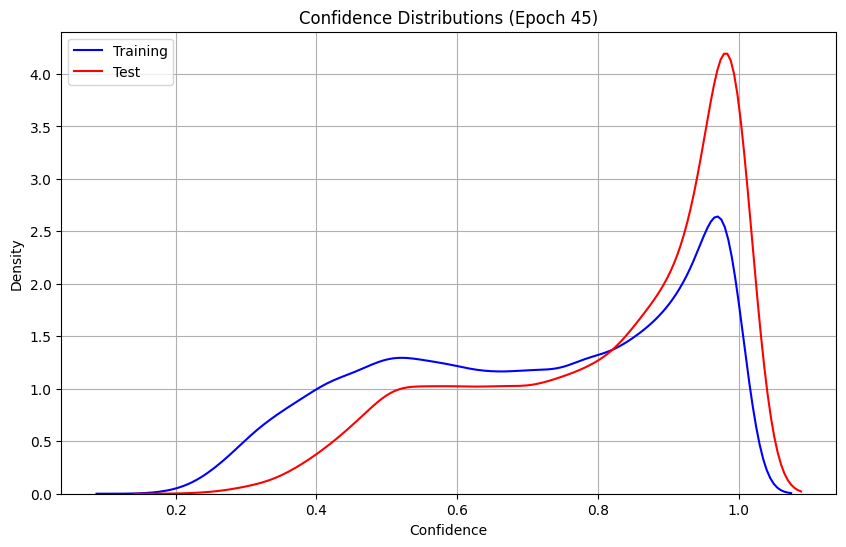

--------------------------------------------------
Epoch [346/400]
  Training: Loss: 0.7193, Accuracy: 75.30%, Confidence: 0.7066
  Testing:  Loss: 0.8571, Accuracy: 69.60%, Confidence: 0.7033
--------------------------------------------------
Epoch [347/400]
  Training: Loss: 0.7282, Accuracy: 74.99%, Confidence: 0.7039
  Testing:  Loss: 0.8244, Accuracy: 71.48%, Confidence: 0.7029
--------------------------------------------------
Epoch [348/400]
  Training: Loss: 0.7116, Accuracy: 75.91%, Confidence: 0.7080
  Testing:  Loss: 0.9132, Accuracy: 68.23%, Confidence: 0.7016
--------------------------------------------------
Epoch [349/400]
  Training: Loss: 0.7237, Accuracy: 75.27%, Confidence: 0.7053
  Testing:  Loss: 0.8457, Accuracy: 71.11%, Confidence: 0.7205
--------------------------------------------------
Epoch [350/400]
  Training: Loss: 0.7078, Accuracy: 75.73%, Confidence: 0.7102
  Testing:  Loss: 1.2959, Accuracy: 55.21%, Confidence: 0.7255
Stats: KS=0.0520(p=0.0000), MW=2414

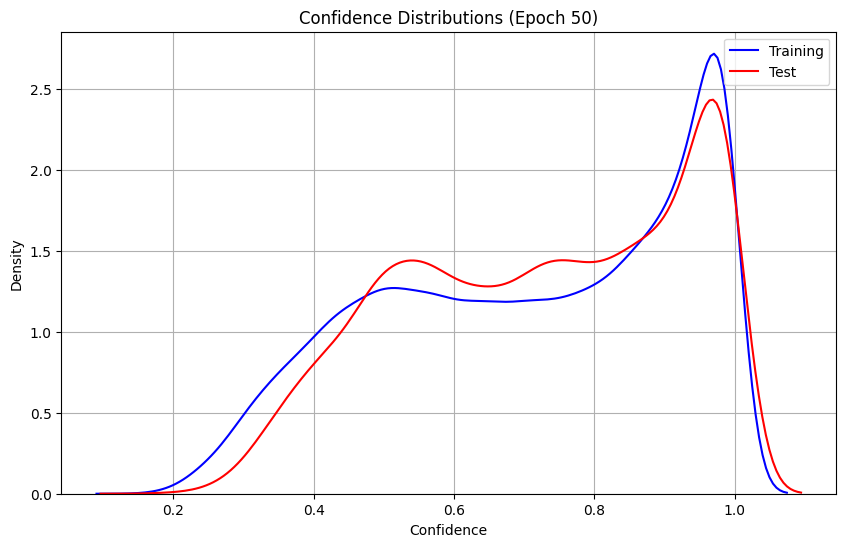

--------------------------------------------------
Epoch [351/400]
  Training: Loss: 0.7159, Accuracy: 75.38%, Confidence: 0.7075
  Testing:  Loss: 0.8203, Accuracy: 71.14%, Confidence: 0.7060
--------------------------------------------------
Epoch [352/400]
  Training: Loss: 0.7139, Accuracy: 75.63%, Confidence: 0.7063
  Testing:  Loss: 0.8255, Accuracy: 71.32%, Confidence: 0.7090
--------------------------------------------------
Epoch [353/400]
  Training: Loss: 0.7182, Accuracy: 75.40%, Confidence: 0.7097
  Testing:  Loss: 0.8724, Accuracy: 69.53%, Confidence: 0.7036
--------------------------------------------------
Epoch [354/400]
  Training: Loss: 0.7143, Accuracy: 75.46%, Confidence: 0.7093
  Testing:  Loss: 0.8035, Accuracy: 72.47%, Confidence: 0.7134
--------------------------------------------------
Epoch [355/400]
  Training: Loss: 0.7573, Accuracy: 73.87%, Confidence: 0.6973
  Testing:  Loss: 0.8911, Accuracy: 68.68%, Confidence: 0.6870
Stats: KS=0.0261(p=0.0000), MW=2571

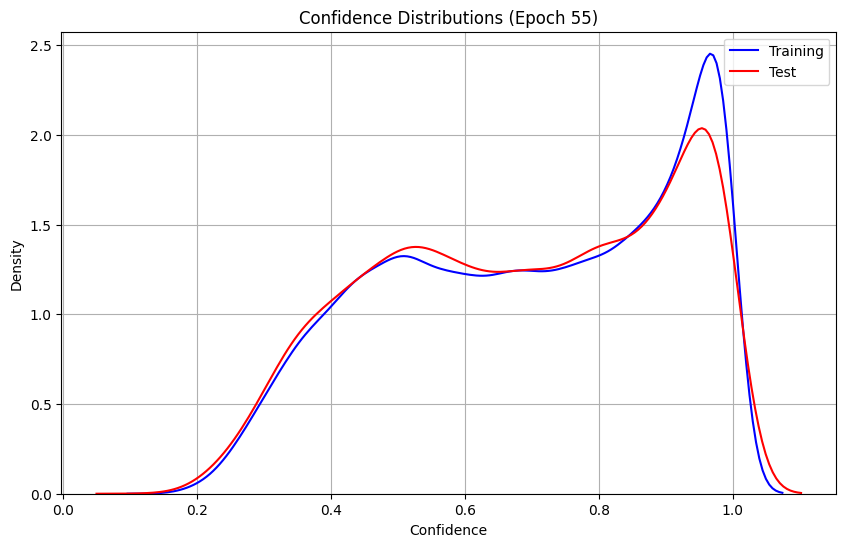

--------------------------------------------------
Epoch [356/400]
  Training: Loss: 0.7292, Accuracy: 74.99%, Confidence: 0.7043
  Testing:  Loss: 0.8101, Accuracy: 72.03%, Confidence: 0.7104
--------------------------------------------------
Epoch [357/400]
  Training: Loss: 0.7244, Accuracy: 75.16%, Confidence: 0.7089
  Testing:  Loss: 0.8101, Accuracy: 72.18%, Confidence: 0.7161
--------------------------------------------------
Epoch [358/400]
  Training: Loss: 0.7055, Accuracy: 75.77%, Confidence: 0.7120
  Testing:  Loss: 0.8499, Accuracy: 70.81%, Confidence: 0.6934
--------------------------------------------------
Epoch [359/400]
  Training: Loss: 0.7210, Accuracy: 75.36%, Confidence: 0.7059
  Testing:  Loss: 0.8121, Accuracy: 71.87%, Confidence: 0.7167
--------------------------------------------------
Epoch [360/400]
  Training: Loss: 0.7023, Accuracy: 75.97%, Confidence: 0.7103
  Testing:  Loss: 0.8089, Accuracy: 72.11%, Confidence: 0.7146
Model saved successfully to model_c

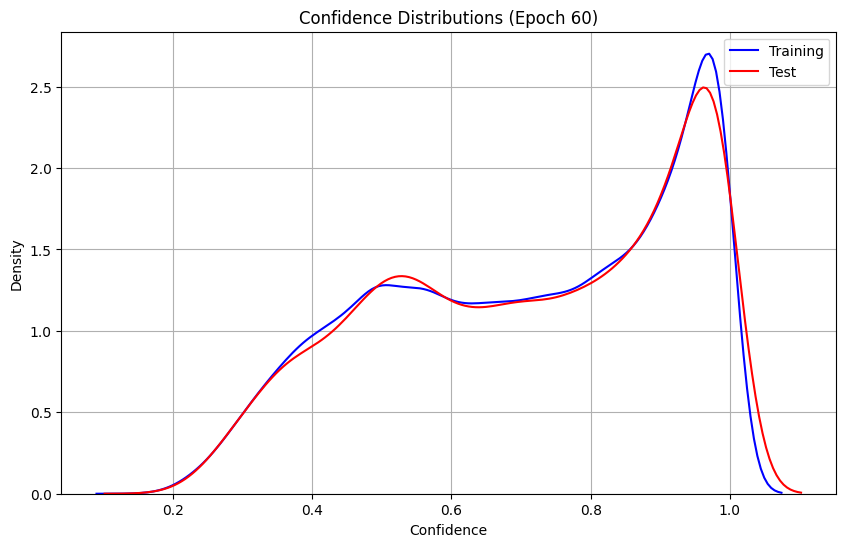

--------------------------------------------------
Epoch [361/400]
  Training: Loss: 0.7006, Accuracy: 76.02%, Confidence: 0.7130
  Testing:  Loss: 0.8155, Accuracy: 71.81%, Confidence: 0.7125
--------------------------------------------------
Epoch [362/400]
  Training: Loss: 0.6976, Accuracy: 76.13%, Confidence: 0.7160
  Testing:  Loss: 0.8096, Accuracy: 71.75%, Confidence: 0.7178
--------------------------------------------------
Epoch [363/400]
  Training: Loss: 0.6918, Accuracy: 76.22%, Confidence: 0.7169
  Testing:  Loss: 0.8061, Accuracy: 71.94%, Confidence: 0.7129
--------------------------------------------------
Epoch [364/400]
  Training: Loss: 0.7136, Accuracy: 75.55%, Confidence: 0.7137
  Testing:  Loss: 4.3899, Accuracy: 30.14%, Confidence: 0.8029
--------------------------------------------------
Epoch [365/400]
  Training: Loss: 0.7587, Accuracy: 73.77%, Confidence: 0.7013
  Testing:  Loss: 0.9303, Accuracy: 67.23%, Confidence: 0.6953
Stats: KS=0.0212(p=0.0011), MW=2546

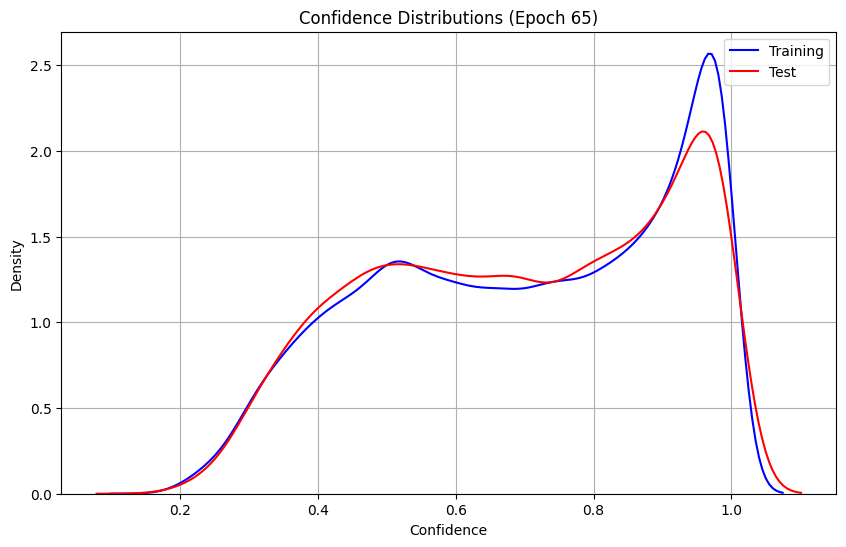

--------------------------------------------------
Epoch [366/400]
  Training: Loss: 0.7733, Accuracy: 73.22%, Confidence: 0.6909
  Testing:  Loss: 1.0858, Accuracy: 62.85%, Confidence: 0.7116
--------------------------------------------------
Epoch [367/400]
  Training: Loss: 0.7361, Accuracy: 74.46%, Confidence: 0.7004
  Testing:  Loss: 0.8736, Accuracy: 69.25%, Confidence: 0.6978
--------------------------------------------------
Epoch [368/400]
  Training: Loss: 0.7203, Accuracy: 75.08%, Confidence: 0.7044
  Testing:  Loss: 0.8123, Accuracy: 71.54%, Confidence: 0.7148
--------------------------------------------------
Epoch [369/400]
  Training: Loss: 0.7175, Accuracy: 75.25%, Confidence: 0.7075
  Testing:  Loss: 0.8308, Accuracy: 71.16%, Confidence: 0.7117
--------------------------------------------------
Epoch [370/400]
  Training: Loss: 0.7051, Accuracy: 76.01%, Confidence: 0.7106
  Testing:  Loss: 0.8040, Accuracy: 72.06%, Confidence: 0.7101
Stats: KS=0.0065(p=0.8753), MW=2499

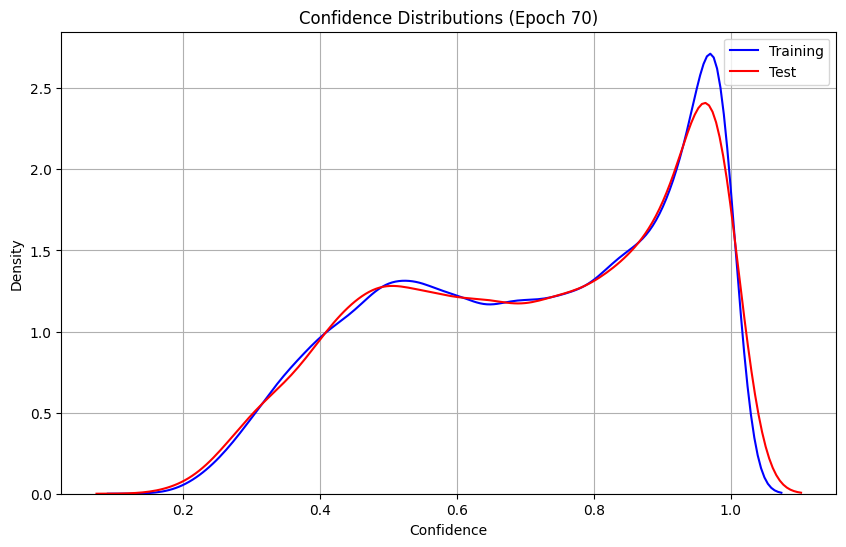

--------------------------------------------------
Epoch [371/400]
  Training: Loss: 0.7221, Accuracy: 75.19%, Confidence: 0.7076
  Testing:  Loss: 1.0684, Accuracy: 63.37%, Confidence: 0.7376
--------------------------------------------------
Epoch [372/400]
  Training: Loss: 0.7131, Accuracy: 75.59%, Confidence: 0.7091
  Testing:  Loss: 0.8330, Accuracy: 71.45%, Confidence: 0.7089
--------------------------------------------------
Epoch [373/400]
  Training: Loss: 0.7043, Accuracy: 75.81%, Confidence: 0.7102
  Testing:  Loss: 0.7997, Accuracy: 72.63%, Confidence: 0.7149
--------------------------------------------------
Epoch [374/400]
  Training: Loss: 0.7096, Accuracy: 75.63%, Confidence: 0.7102
  Testing:  Loss: 0.7982, Accuracy: 72.32%, Confidence: 0.7172
--------------------------------------------------
Epoch [375/400]
  Training: Loss: 0.7060, Accuracy: 75.69%, Confidence: 0.7100
  Testing:  Loss: 0.8600, Accuracy: 70.25%, Confidence: 0.7045
Stats: KS=0.0168(p=0.0175), MW=2532

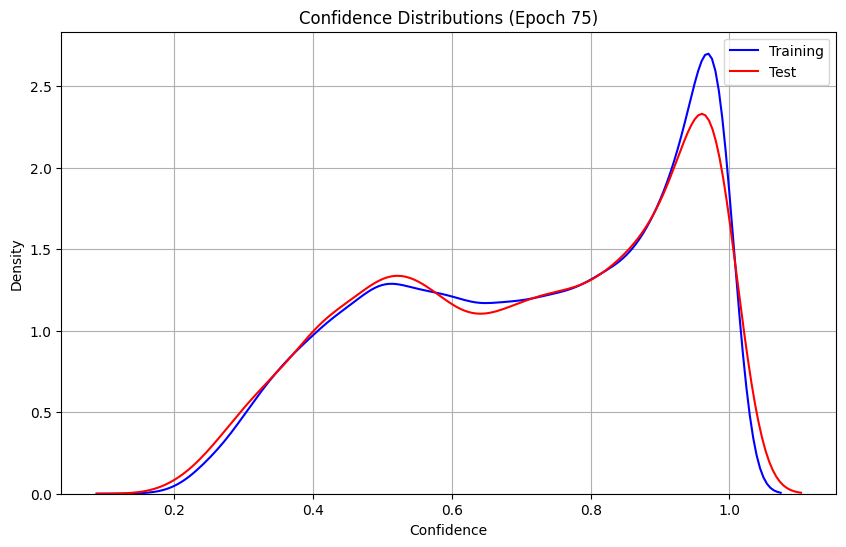

--------------------------------------------------
Epoch [376/400]
  Training: Loss: 0.7026, Accuracy: 75.88%, Confidence: 0.7118
  Testing:  Loss: 1.0774, Accuracy: 62.16%, Confidence: 0.7268
--------------------------------------------------
Epoch [377/400]
  Training: Loss: 0.7451, Accuracy: 74.27%, Confidence: 0.7025
  Testing:  Loss: 0.8674, Accuracy: 69.47%, Confidence: 0.6890
--------------------------------------------------
Epoch [378/400]
  Training: Loss: 0.7808, Accuracy: 72.90%, Confidence: 0.6944
  Testing:  Loss: 0.8408, Accuracy: 70.69%, Confidence: 0.7004
--------------------------------------------------
Epoch [379/400]
  Training: Loss: 0.7221, Accuracy: 75.21%, Confidence: 0.7064
  Testing:  Loss: 0.8723, Accuracy: 69.40%, Confidence: 0.7070
--------------------------------------------------
Epoch [380/400]
  Training: Loss: 0.7045, Accuracy: 75.78%, Confidence: 0.7116
  Testing:  Loss: 0.8023, Accuracy: 72.07%, Confidence: 0.7149
Model saved successfully to model_c

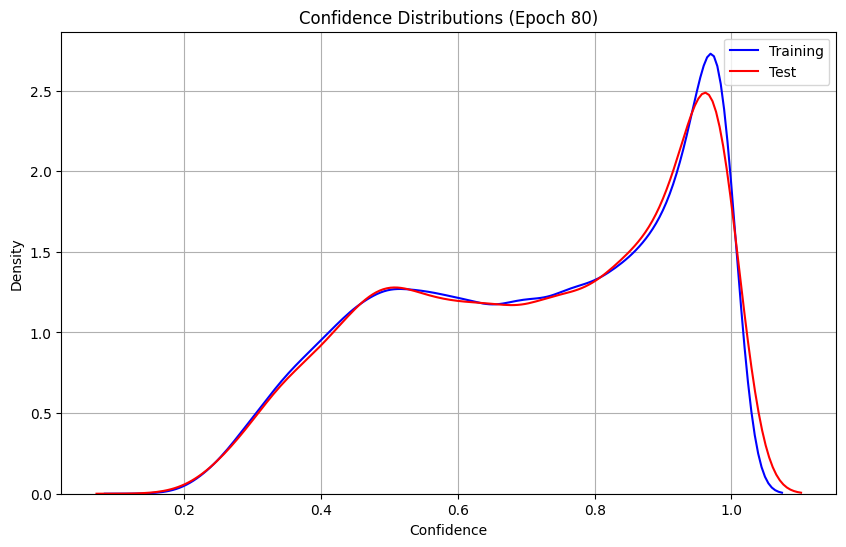

--------------------------------------------------
Epoch [381/400]
  Training: Loss: 0.7870, Accuracy: 72.51%, Confidence: 0.6951
  Testing:  Loss: 0.9624, Accuracy: 66.21%, Confidence: 0.6850
--------------------------------------------------
Epoch [382/400]
  Training: Loss: 0.7497, Accuracy: 74.08%, Confidence: 0.6977
  Testing:  Loss: 0.8273, Accuracy: 70.86%, Confidence: 0.7072
--------------------------------------------------
Epoch [383/400]
  Training: Loss: 0.7191, Accuracy: 75.11%, Confidence: 0.7056
  Testing:  Loss: 0.8173, Accuracy: 71.67%, Confidence: 0.7074
--------------------------------------------------
Epoch [384/400]
  Training: Loss: 0.7210, Accuracy: 75.30%, Confidence: 0.7062
  Testing:  Loss: 0.8536, Accuracy: 70.28%, Confidence: 0.7077
--------------------------------------------------
Epoch [385/400]
  Training: Loss: 0.7137, Accuracy: 75.45%, Confidence: 0.7091
  Testing:  Loss: 0.9260, Accuracy: 67.69%, Confidence: 0.7158
Stats: KS=0.0243(p=0.0001), MW=2448

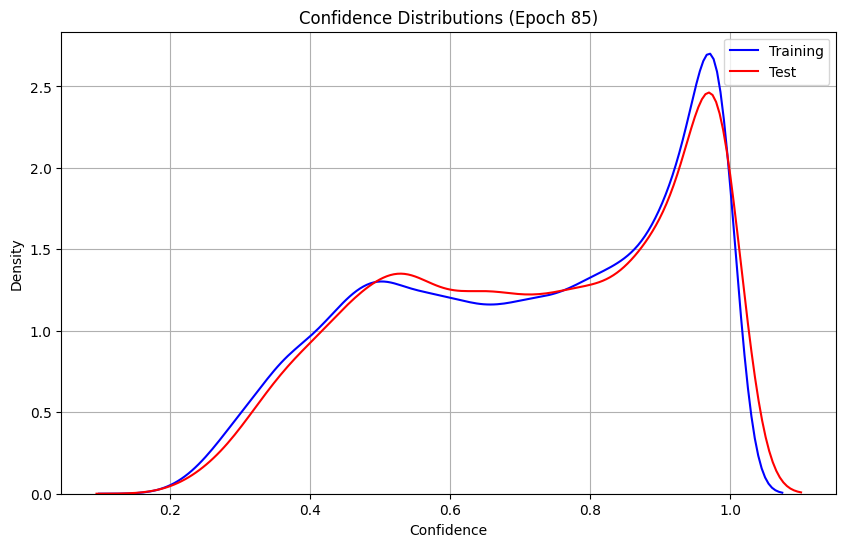

--------------------------------------------------
Epoch [386/400]
  Training: Loss: 0.7047, Accuracy: 75.83%, Confidence: 0.7101
  Testing:  Loss: 0.8256, Accuracy: 71.18%, Confidence: 0.7077
--------------------------------------------------
Epoch [387/400]
  Training: Loss: 0.7059, Accuracy: 75.93%, Confidence: 0.7093
  Testing:  Loss: 0.8680, Accuracy: 69.34%, Confidence: 0.7237
--------------------------------------------------
Epoch [388/400]
  Training: Loss: 0.7173, Accuracy: 75.38%, Confidence: 0.7089
  Testing:  Loss: 1.0292, Accuracy: 64.39%, Confidence: 0.6871
--------------------------------------------------
Epoch [389/400]
  Training: Loss: 0.7205, Accuracy: 75.15%, Confidence: 0.7074
  Testing:  Loss: 0.8707, Accuracy: 69.54%, Confidence: 0.7022
--------------------------------------------------
Epoch [390/400]
  Training: Loss: 0.7116, Accuracy: 75.60%, Confidence: 0.7088
  Testing:  Loss: 0.8021, Accuracy: 72.17%, Confidence: 0.7189
Stats: KS=0.0244(p=0.0001), MW=2429

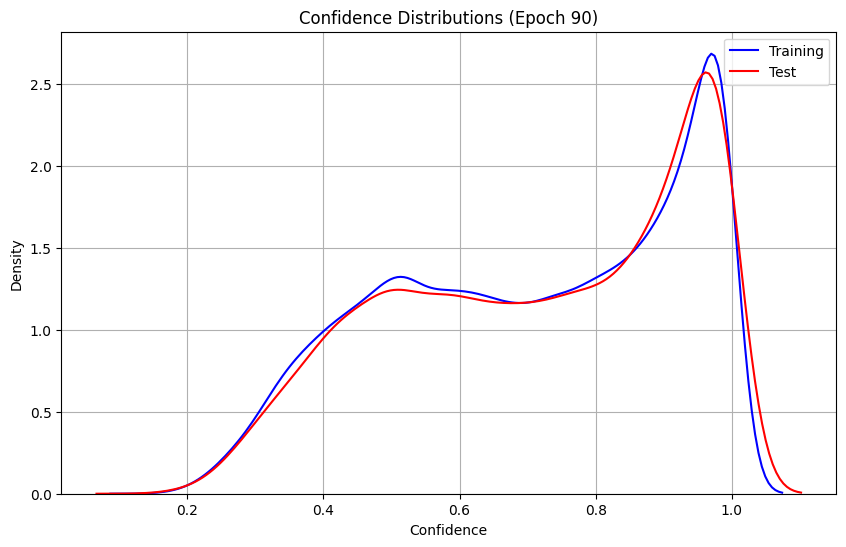

--------------------------------------------------
Epoch [391/400]
  Training: Loss: 0.7041, Accuracy: 75.88%, Confidence: 0.7113
  Testing:  Loss: 0.8245, Accuracy: 71.59%, Confidence: 0.7077
--------------------------------------------------
Epoch [392/400]
  Training: Loss: 0.7026, Accuracy: 75.79%, Confidence: 0.7108
  Testing:  Loss: 0.8448, Accuracy: 70.43%, Confidence: 0.7109
--------------------------------------------------
Epoch [393/400]
  Training: Loss: 0.7389, Accuracy: 74.60%, Confidence: 0.7079
  Testing:  Loss: 0.8714, Accuracy: 70.08%, Confidence: 0.7200
--------------------------------------------------
Epoch [394/400]
  Training: Loss: 0.7271, Accuracy: 74.94%, Confidence: 0.7084
  Testing:  Loss: 0.9590, Accuracy: 66.71%, Confidence: 0.7102
--------------------------------------------------
Epoch [395/400]
  Training: Loss: 0.7705, Accuracy: 73.48%, Confidence: 0.6991
  Testing:  Loss: 0.8712, Accuracy: 69.98%, Confidence: 0.6958
Stats: KS=0.0149(p=0.0485), MW=2521

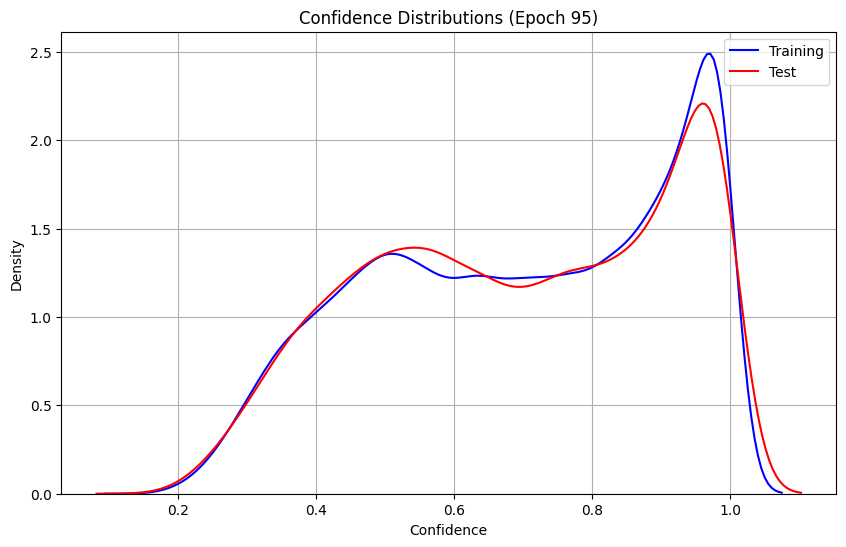

--------------------------------------------------
Epoch [396/400]
  Training: Loss: 0.7464, Accuracy: 74.03%, Confidence: 0.7043
  Testing:  Loss: 0.8648, Accuracy: 69.90%, Confidence: 0.7039
--------------------------------------------------
Epoch [397/400]
  Training: Loss: 0.7385, Accuracy: 74.60%, Confidence: 0.7050
  Testing:  Loss: 0.8417, Accuracy: 70.68%, Confidence: 0.7120
--------------------------------------------------
Epoch [398/400]
  Training: Loss: 0.7242, Accuracy: 75.21%, Confidence: 0.7105
  Testing:  Loss: 1.1369, Accuracy: 61.13%, Confidence: 0.7369
--------------------------------------------------
Epoch [399/400]
  Training: Loss: 0.7336, Accuracy: 74.55%, Confidence: 0.7063
  Testing:  Loss: 0.8516, Accuracy: 70.70%, Confidence: 0.7143
--------------------------------------------------
Epoch [400/400]
  Training: Loss: 0.7143, Accuracy: 75.37%, Confidence: 0.7112
  Testing:  Loss: 0.8249, Accuracy: 71.39%, Confidence: 0.7112
Model saved successfully to model_c

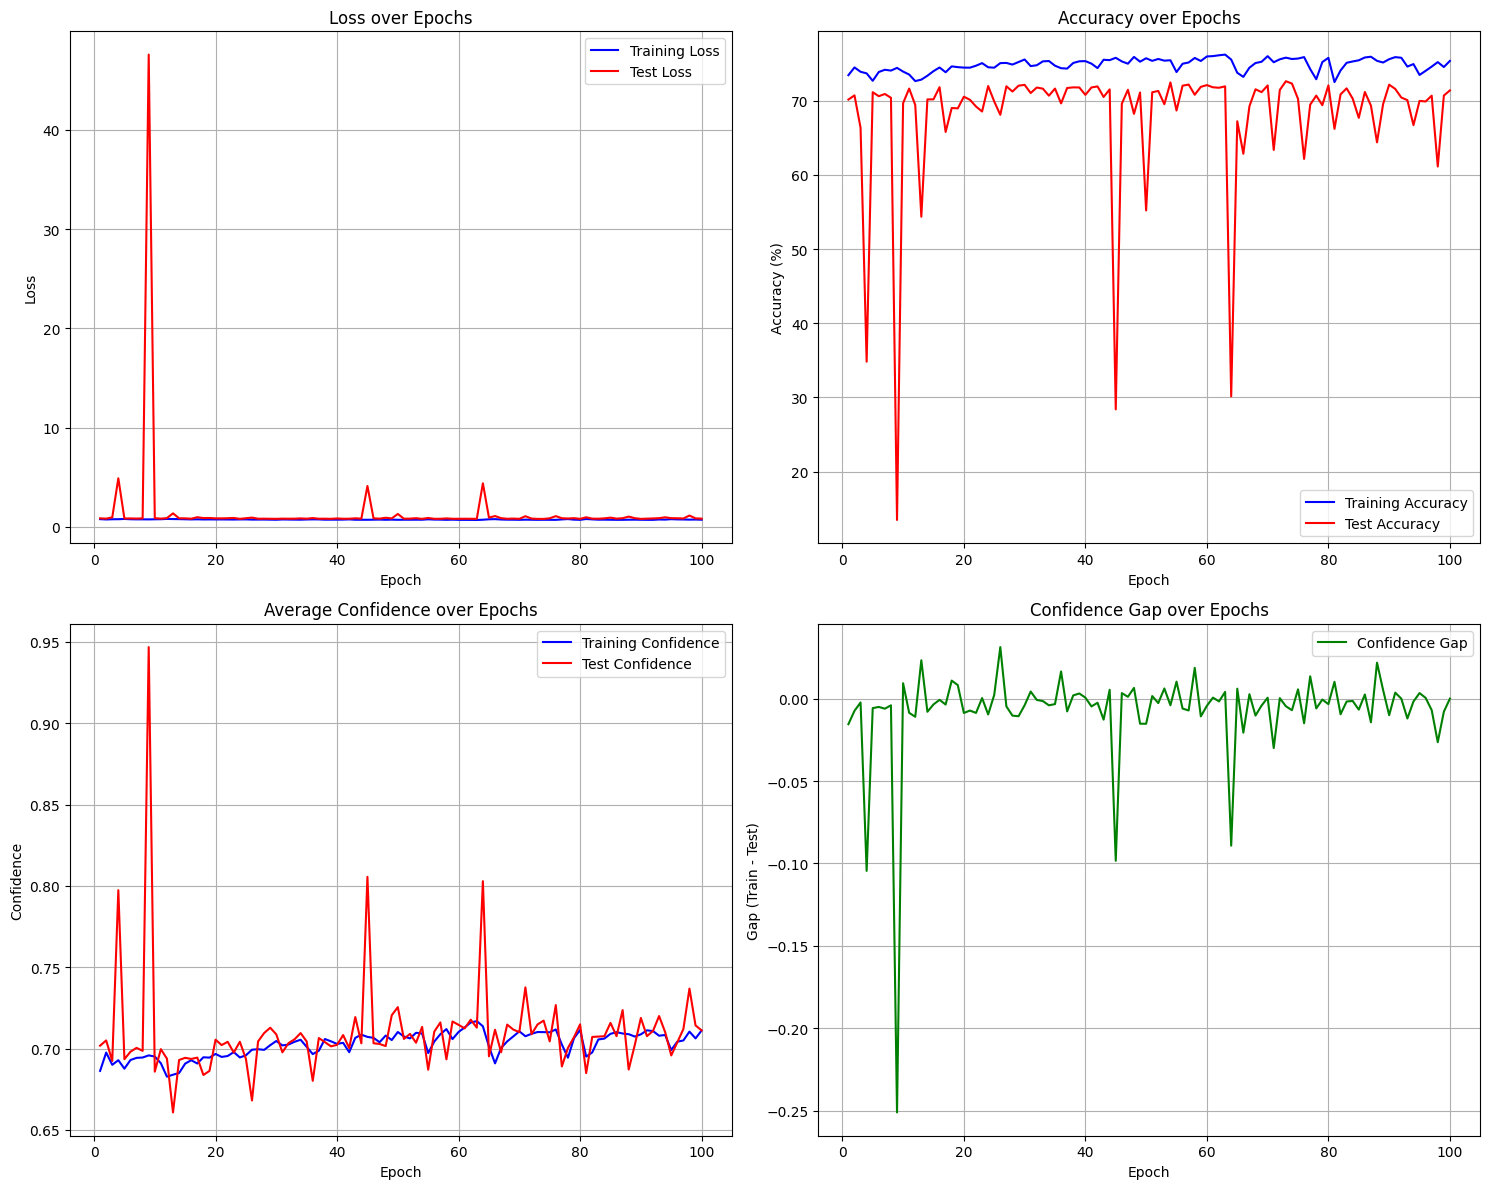

Saved plots for epochs 301-400
Stats: KS=0.0100(p=0.3777), MW=249974558.0000(p=0.9872), Cohen's d=-0.0002


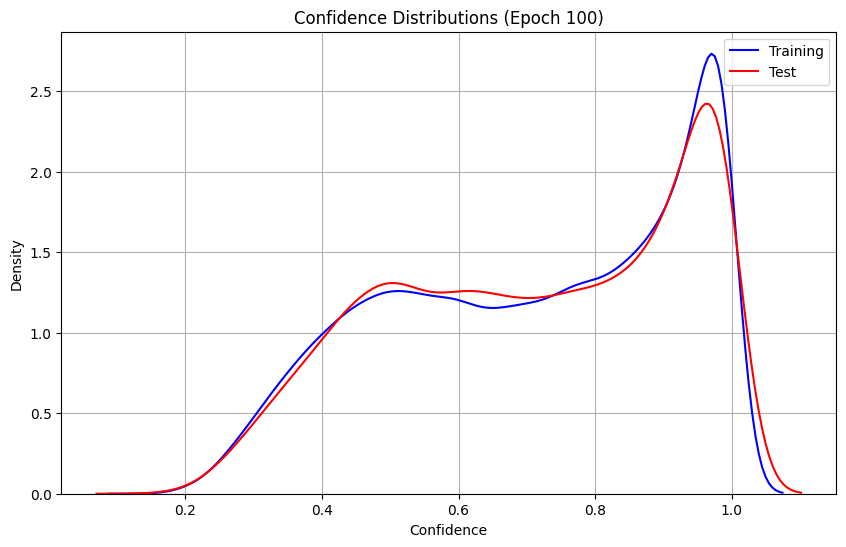

--------------------------------------------------


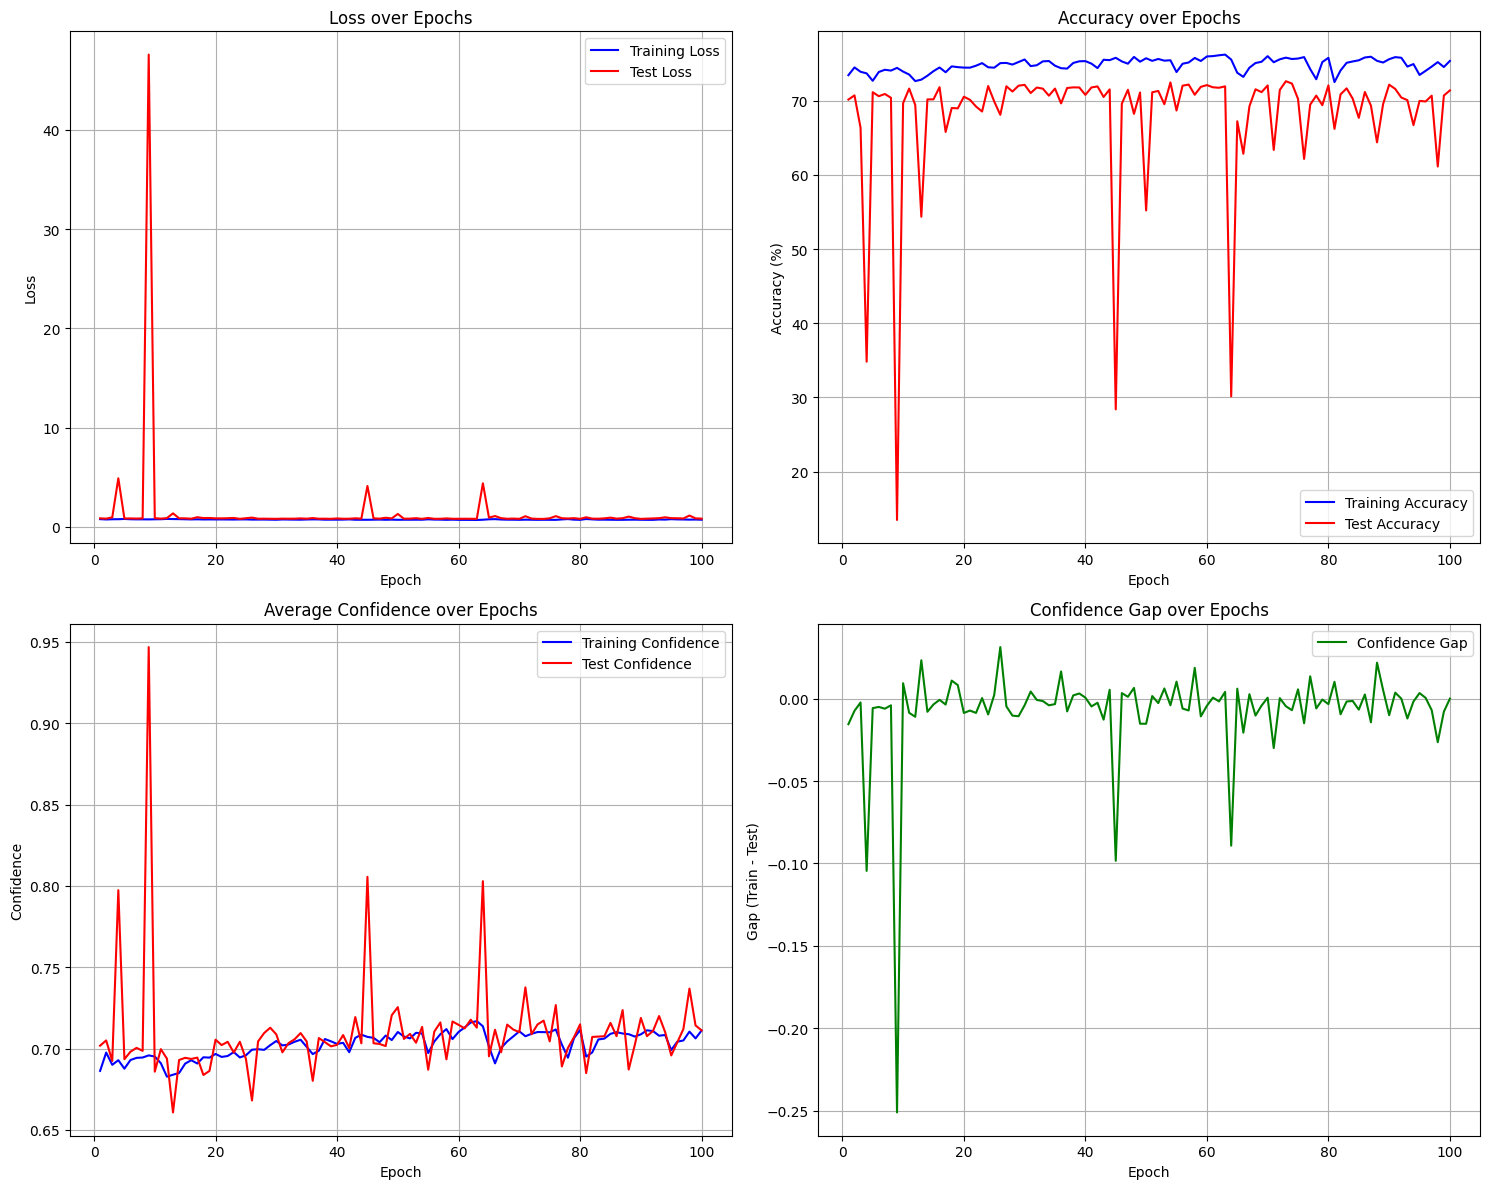

In [22]:
# First load the saved model from epoch 100
checkpoint_path = os.path.join('model_checkpoints', 'model_epoch_100.pt')
print(f"Loading model from {checkpoint_path}")
saved_model = torch.load(checkpoint_path)
model.load_state_dict(saved_model['model_state_dict'])

# Initialize metrics tracker
metrics_tracker = TrainingMetricsTracker()

# Create directories for model checkpoints and plots
checkpoint_dir = 'model_checkpoints_extended'
plots_dir = 'training_plots'
os.makedirs(checkpoint_dir, exist_ok=True)
os.makedirs(plots_dir, exist_ok=True)

# Training loop - start from epoch 101 to 400
start_epoch = 101
num_epochs = 400
last_plot_epoch = start_epoch - 1

for epoch in range(start_epoch, num_epochs + 1):
    model.train()
    running_loss = 0.0
    running_correct = 0
    total_samples = 0
    train_confidence_sum = 0
    train_epoch_confidences = []
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.view(-1)
        logits, probabilities = model(inputs)
        loss = criterion(logits, labels)
        _, predicted = torch.max(logits, 1)
        confidence, _ = torch.max(probabilities, 1)
        running_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)
        train_confidence_sum += confidence.sum().item()
        train_epoch_confidences.extend(confidence.detach().cpu().numpy())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    # Calculate training metrics
    train_loss = running_loss / len(train_loader)
    train_accuracy = (running_correct / total_samples) * 100
    train_avg_confidence = train_confidence_sum / total_samples
    
    # Evaluate on test set
    test_accuracy, test_loss, test_avg_confidence, test_epoch_confidences = evaluate_model(model, test_loader, device)
    
    # Update metrics tracker
    metrics_tracker.update(
        train_loss, test_loss,
        train_accuracy, test_accuracy,
        train_avg_confidence, test_avg_confidence,
        train_epoch_confidences, test_epoch_confidences
    )
    
    # Print metrics
    print(f'Epoch [{epoch}/{num_epochs}]')
    print(f'  Training: Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%, Confidence: {train_avg_confidence:.4f}')
    print(f'  Testing:  Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.2f}%, Confidence: {test_avg_confidence:.4f}')
    
    # Save model every 20 epochs
    if epoch % 20 == 0:
        checkpoint_path = os.path.join(checkpoint_dir, f'model_epoch_{epoch}.pt')
        save_pytorch_model(model, checkpoint_path, epoch=epoch)
        print(f'Saved checkpoint: epoch {epoch}')
    
    # Create summary plots every 100 epochs
    if epoch % 100 == 0:
        plot_filename = os.path.join(plots_dir, f'training_metrics_epoch_{epoch}.png')
        metrics_tracker.plot_metrics(save_path=plot_filename)
        print(f'Saved plots for epochs {last_plot_epoch+1}-{epoch}')
        
        if epoch < num_epochs:
            last_plot_epoch = epoch
            metrics_tracker = TrainingMetricsTracker()
    
    # Perform statistical tests every 5 epochs, but only after we have enough data
    if epoch % 5 == 0 and (epoch - last_plot_epoch) > 0:
        try:
            stats_results = metrics_tracker.statistical_tests(epoch - last_plot_epoch - 1)  # Use -1 to get last complete epoch
            print(f"Stats: KS={stats_results['ks_test']['statistic']:.4f}(p={stats_results['ks_test']['p_value']:.4f}), " 
                  f"MW={stats_results['mw_test']['statistic']:.4f}(p={stats_results['mw_test']['p_value']:.4f}), "
                  f"Cohen's d={stats_results['cohens_d']:.4f}")
            
            metrics_tracker.plot_confidence_distributions(epoch - last_plot_epoch - 1)
        except IndexError:
            print("Skipping statistical tests - not enough data yet")
    
    print('-' * 50)

# Final summary plot
final_plot_filename = os.path.join(plots_dir, 'training_metrics_final.png')
metrics_tracker.plot_metrics(save_path=final_plot_filename)

Tests from epochs

In [23]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt

def evaluate_saved_model(model_path, test_loader, train_loader, device):
    """Evaluate a saved model checkpoint"""
    # Load model
    saved_model = torch.load(model_path)
    model.load_state_dict(saved_model['model_state_dict'])
    model.eval()
    
    metrics = {}
    # Test set evaluation
    test_correct = 0
    test_total = 0
    test_loss = 0
    test_confidences = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.view(-1)
            logits, probabilities = model(inputs)
            loss = criterion(logits, labels)
            _, predicted = torch.max(logits, 1)
            confidence, _ = torch.max(probabilities, 1)
            test_correct += (predicted == labels).sum().item()
            test_total += labels.size(0)
            test_loss += loss.item()
            test_confidences.extend(confidence.detach().cpu().numpy())
    
    # Train set evaluation
    train_correct = 0
    train_total = 0
    train_loss = 0
    train_confidences = []
    
    with torch.no_grad():
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.view(-1)
            logits, probabilities = model(inputs)
            loss = criterion(logits, labels)
            _, predicted = torch.max(logits, 1)
            confidence, _ = torch.max(probabilities, 1)
            train_correct += (predicted == labels).sum().item()
            train_total += labels.size(0)
            train_loss += loss.item()
            train_confidences.extend(confidence.detach().cpu().numpy())
    
    metrics['test_accuracy'] = 100 * test_correct / test_total
    metrics['test_loss'] = test_loss / len(test_loader)
    metrics['test_confidence'] = np.mean(test_confidences)
    metrics['train_accuracy'] = 100 * train_correct / train_total
    metrics['train_loss'] = train_loss / len(train_loader)
    metrics['train_confidence'] = np.mean(train_confidences)
    
    return metrics

# Collect epochs and metrics
epochs = []
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
train_confidences = []
test_confidences = []

# Load and evaluate checkpoints
checkpoint_dir = 'model_checkpoints_extended'
for filename in sorted(os.listdir(checkpoint_dir)):
    if filename.startswith('model_epoch_'):
        epoch = int(filename.split('_')[-1].split('.')[0])
        print(f"Evaluating epoch {epoch}...")
        
        model_path = os.path.join(checkpoint_dir, filename)
        metrics = evaluate_saved_model(model_path, test_loader, train_loader, device)
        
        epochs.append(epoch)
        train_losses.append(metrics['train_loss'])
        test_losses.append(metrics['test_loss'])
        train_accuracies.append(metrics['train_accuracy'])
        test_accuracies.append(metrics['test_accuracy'])
        train_confidences.append(metrics['train_confidence'])
        test_confidences.append(metrics['test_confidence'])

# Create plots
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.plot(epochs, train_losses, 'b-', label='Training Loss')
plt.plot(epochs, test_losses, 'r-', label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(epochs, train_accuracies, 'b-', label='Training Accuracy')
plt.plot(epochs, test_accuracies, 'r-', label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(epochs, train_confidences, 'b-', label='Training Confidence')
plt.plot(epochs, test_confidences, 'r-', label='Test Confidence')
plt.xlabel('Epoch')
plt.ylabel('Confidence')
plt.title('Average Confidence over Epochs')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
confidence_gap = np.array(train_confidences) - np.array(test_confidences)
plt.plot(epochs, confidence_gap, 'g-', label='Confidence Gap')
plt.xlabel('Epoch')
plt.ylabel('Gap (Train - Test)')
plt.title('Confidence Gap over Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('complete_training_history.png')
plt.close()

print("Complete training history plot has been saved as 'complete_training_history.png'")

Evaluating epoch 120...


C:\Users\baris\AppData\Local\Temp\ipykernel_5476\142172299.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_model = torch.load(model_path)


Evaluating epoch 140...
Evaluating epoch 160...
Evaluating epoch 180...
Evaluating epoch 200...
Evaluating epoch 220...
Evaluating epoch 240...
Evaluating epoch 260...
Evaluating epoch 280...
Evaluating epoch 300...
Evaluating epoch 320...
Evaluating epoch 340...
Evaluating epoch 360...
Evaluating epoch 380...
Evaluating epoch 400...
Complete training history plot has been saved as 'complete_training_history.png'


# Test

In [ ]:
# Switch to evaluation mode
model.eval()
y_pred = []
y_true = []
y_prob = []  # List to store probabilities

# Test the model on the test dataset
with torch.no_grad():
    for inputs, labels in test_dataset:  # Use test_dataset directly
        inputs, labels = inputs.to(device), labels.to(device)
        logits, probabilities = model(inputs)  # Now get both logits and probabilities
        _, predicted = torch.max(logits, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())
        y_prob.extend(probabilities.cpu().numpy())  # Store probabilities

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy on the test set: {accuracy:.4f}')

# Convert probabilities to percentages
y_prob_percentages = np.array(y_prob) * 100  # Convert probabilities to percentages

# Display the first few predicted class names along with their probabilities and the correct class
print("First few predicted class names and their probabilities (in percentages):")
for i in range(5):
    print(f"Instance {i+1}:")
    print(f"  Correct Class: {class_names[y_true[i]]}")
    for class_index, class_name in enumerate(class_names):
        print(f"  Class: {class_name}, Probability: {y_prob_percentages[i][class_index]:.2f}%")

# Switch to evaluation mode for training data
model.eval()
y_pred_train = []
y_true_train = []
y_prob_train = []  # List to store probabilities

# Test the model on training data
with torch.no_grad():
    for inputs, labels in train_dataset:  # Use train_dataset directly
        inputs, labels = inputs.to(device), labels.to(device)
        logits, probabilities = model(inputs)  # Now get both logits and probabilities
        _, predicted = torch.max(logits, 1)
        y_pred_train.extend(predicted.cpu().numpy())
        y_true_train.extend(labels.cpu().numpy())
        y_prob_train.extend(probabilities.cpu().numpy())  # Store probabilities

# Calculate accuracy on training data
accuracy_train = accuracy_score(y_true_train, y_pred_train)
print(f'Accuracy on the training set: {accuracy_train:.4f}')

# Convert probabilities to percentages
y_prob_train_percentages = np.array(y_prob_train) * 100  # Convert probabilities to percentages

# Display the first few predicted class names along with their probabilities and the correct class
print("First few predicted class names and their probabilities (in percentages) for training data:")
for i in range(5):
    print(f"Instance {i+1}:")
    print(f"  Correct Class: {class_names[y_true_train[i]]}")
    for class_index, class_name in enumerate(class_names):
        print(f"  Class: {class_name}, Probability: {y_prob_train_percentages[i][class_index]:.2f}%")

In [ ]:
# Extract probabilities for the correct class on the test data
correct_class_probs_test = [y_prob[i][y_true[i]] for i in range(len(y_true))]
average_prob_correct_class_test = np.mean(correct_class_probs_test)
print(f'Average probability for the correct class on the test data: {average_prob_correct_class_test:.4f}')

# Extract probabilities for the correct class on the training data
correct_class_probs_train = [y_prob_train[i][y_true_train[i]] for i in range(len(y_true_train))]
average_prob_correct_class_train = np.mean(correct_class_probs_train)
print(f'Average probability for the correct class on the training data: {average_prob_correct_class_train:.4f}')

In [ ]:
print("Difference in percentage is: ", (average_prob_correct_class_train - average_prob_correct_class_test)/average_prob_correct_class_train*100)